In [1]:
import os

QUANTILES = [0.01, 0.1, 0.2, 0.5, 0.8, 0.9, 0.99] 

SPLIT = 0.9         # train/test %

FIGSIZE = (9, 6)


qL1, qL2 = 0.01, 0.10        # percentiles of predictions: lower bounds
qU1, qU2 = 1-qL1, 1-qL2,     # upper bounds derived from lower bounds
label_q1 = f'{int(qU1 * 100)} / {int(qL1 * 100)} percentile band'
label_q2 = f'{int(qU2 * 100)} / {int(qL2 * 100)} percentile band'

In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
import missingno as mno
import pywt
import warnings
warnings.filterwarnings("ignore")
import logging
logging.disable(logging.CRITICAL)
import random
import numpy as np
import torch
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
from darts import TimeSeries, concatenate
from darts.dataprocessing.transformers import Scaler
from darts.models import TransformerModel, NBEATSModel, NHiTSModel, XGBModel, RNNModel, BlockRNNModel
from darts.models import AutoARIMA, LinearRegressionModel, RegressionEnsembleModel
from darts.utils.statistics import check_seasonality, plot_acf, plot_residuals_analysis
from darts.metrics import mape, rmse, smape
from darts.utils.timeseries_generation import datetime_attribute_timeseries
from darts.utils.likelihood_models import QuantileRegression
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.tuner import lr_finder
import pytorch_lightning as pl
pl.seed_everything(42)
pd.set_option("display.precision",2)
np.set_printoptions(precision=2, suppress=True)
pd.options.display.float_format = '{:,.2f}'.format

In [3]:
xls = pd.ExcelFile('df_radon_combined.xlsx')

df_radon = {}
for num in xls.sheet_names[2:]:
    df_radon[num] = pd.read_excel(xls, num) 

#remove these indexes
devices = ['1', '2', '5', '9', '17', '23', '27', '28', '36', '44', '48']
for key in list(df_radon):
    if key in devices:
        del df_radon[key]

for key in df_radon:
    print(key)
    df_radon[key]['SyncDate'] = pd.to_datetime(df_radon[key]['SyncDate'])
    print(f"{df_radon[key]['SyncDate'].min()} - {df_radon[key]['SyncDate'].max()}")
    df_radon[key].sort_values(by='SyncDate', ascending=True, inplace=True)
    df_radon[key]['SyncDate'] = df_radon[key]['SyncDate'].dt.floor('H')
    df_radon[key] = df_radon[key].resample('H', on = 'SyncDate').mean()
    df_radon[key] = df_radon[key].interpolate(method='linear', limit_direction='both')
    start_time = pd.to_datetime('2022-05-11T18:29:00.000000000')
    end_time = pd.to_datetime('2023-06-06T12:00:00.000000000')
    df_radon[key] = df_radon[key][(df_radon[key].index >= start_time) & (df_radon[key].index <= end_time)]
    print(f"{df_radon[key].index.min()} - {df_radon[key].index.max()}")

3
2022-05-08 00:16:30 - 2023-06-06 12:25:38
2022-05-11 19:00:00 - 2023-06-06 12:00:00
4
2022-05-08 00:17:23 - 2023-06-06 12:26:06
2022-05-11 19:00:00 - 2023-06-06 12:00:00
7
2022-04-01 10:18:57 - 2023-06-06 12:30:25
2022-05-11 19:00:00 - 2023-06-06 12:00:00
8
2022-04-04 18:52:46 - 2023-06-06 12:27:12
2022-05-11 19:00:00 - 2023-06-06 12:00:00
10
2022-05-08 00:56:00 - 2023-06-06 23:02:00
2022-05-11 19:00:00 - 2023-06-06 12:00:00
11
2022-05-08 00:50:01 - 2023-06-07 12:13:32
2022-05-11 19:00:00 - 2023-06-06 12:00:00
13
2022-05-08 00:33:33 - 2023-06-06 23:09:00
2022-05-11 19:00:00 - 2023-06-06 12:00:00
15
2022-05-08 00:39:00 - 2023-06-06 23:59:00
2022-05-11 19:00:00 - 2023-06-06 12:00:00
16
2022-05-08 00:47:00 - 2023-06-06 23:00:00
2022-05-11 19:00:00 - 2023-06-06 12:00:00
18
2022-05-08 00:49:00 - 2023-06-06 23:07:00
2022-05-11 19:00:00 - 2023-06-06 12:00:00
19
2022-05-08 00:51:00 - 2023-06-06 23:36:00
2022-05-11 19:00:00 - 2023-06-06 12:00:00
20
2022-05-08 00:54:00 - 2023-06-07 12:40:49
20

# Radon 45

In [4]:
df = df_radon['45'].copy()

In [5]:
# Denoising the Radon signal
def madev(d, axis=None):
    """ Mean absolute deviation of a signal """
    return np.mean(np.absolute(d - np.mean(d, axis)), axis)

In [6]:
def wavelet_denoising(x, wavelet='db4', level=5):
    coeff = pywt.wavedec(x, wavelet, mode="per")
    n = len(x) 
    sigma = (1/0.6745) * madev(coeff[-level])
    uthresh = sigma * np.sqrt(2 * np.log(len(x)))
    coeff[1:] = (pywt.threshold(i, value=uthresh, mode='hard') for i in coeff[1:])
    if len(x) % 2 ==0:
        return pywt.waverec(coeff, wavelet, mode='per')
    else:
        return pywt.waverec(coeff, wavelet, mode='per')[:n]

In [7]:
signal = df['Radon'].copy()
wavelet_name='coif9'
filtered = wavelet_denoising(signal, wavelet=wavelet_name, level=4)
df['Radon'] = filtered

In [8]:
# create time series object for target variable
ts_P = TimeSeries.from_series(df["Radon"], fill_missing_dates=True, freq="H") 

# check attributes of the time series
print("components:", ts_P.components)
print("duration:",ts_P.duration)
print("frequency:",ts_P.freq)
print("frequency:",ts_P.freq_str)
print("has date time index? (or else, it must have an integer index):",ts_P.has_datetime_index)
print("deterministic:",ts_P.is_deterministic)
print("univariate:",ts_P.is_univariate)

components: Index(['Radon'], dtype='object', name='component')
duration: 390 days 17:00:00
frequency: <Hour>
frequency: H
has date time index? (or else, it must have an integer index): True
deterministic: True
univariate: True


In [9]:
# train/test split and scaling of target variable
ts_train, ts_test = ts_P.split_after(split_point=9210)

print("training start:", ts_train.start_time())
print("training end:", ts_train.end_time())
print("training duration:",ts_train.duration)
print("test start:", ts_test.start_time())
print("test end:", ts_test.end_time())
print("test duration:", ts_test.duration)


scalerP = Scaler()
scalerP.fit_transform(ts_train)
ts_ttrain = scalerP.transform(ts_train)
ts_ttest = scalerP.transform(ts_test)    
ts_t = scalerP.transform(ts_P)

# make sure data are of type float
ts_t = ts_t.astype(np.float32)
ts_ttrain = ts_ttrain.astype(np.float32)
ts_ttest = ts_ttest.astype(np.float32)

print("first and last row of scaled Radon time series:")
pd.options.display.float_format = '{:,.2f}'.format
ts_t.pd_dataframe().iloc[[0,-1]]

training start: 2022-05-11 19:00:00
training end: 2023-05-30 13:00:00
training duration: 383 days 18:00:00
test start: 2023-05-30 14:00:00
test end: 2023-06-06 12:00:00
test duration: 6 days 22:00:00
first and last row of scaled Radon time series:


component,Radon
SyncDate,
2022-05-11 19:00:00,0.04
2023-06-06 12:00:00,0.05


In [10]:
print("first and last row of scaled target variable in training set: price:")
ts_ttrain.pd_dataframe().iloc[[0,-1]]

first and last row of scaled target variable in training set: price:


component,Radon
SyncDate,
2022-05-11 19:00:00,0.04
2023-05-30 13:00:00,0.07


In [11]:
import torch
from ray.air import session
from darts.utils.losses import SmapeLoss
from torchmetrics import MetricCollection, SymmetricMeanAbsolutePercentageError, MeanAbsolutePercentageError
def build_fit_nhits_model(
    model_args,
    save_checkpoints=False,
    callbacks=None,
    save_model=False
):
#     BATCH_SIZE=64
    MAX_EPOCHS=500
    NR_EPOCHS_VAL_PERIOD=1

    torch_metrics = MetricCollection([MeanAbsolutePercentageError(), SymmetricMeanAbsolutePercentageError()])

#     early_stopper = EarlyStopping(
#         monitor="val_loss",
#         patience=5,
#         min_delta=0.001,
#         mode='min',
#     )

#     if callbacks is None:
#         callbacks = [early_stopper]
#     else:
#         callbacks.append(early_stopper)
    
    #detect if GPU is available
#     if torch.cuda.is_available():
#         pl_trainer_kwargs = {
#             "accelerator": "gpu",
#             "gpus": -1,
#             "auto_select_gpus": True,
#             "callbacks": callbacks,
#             "enable_progress_bar":False,
#         }
#         num_workers=8
#     else:
#         pl_trainer_kwargs={
#             "callbacks": callbacks,
#         }
#         num_workers=0
    pl_trainer_kwargs={
            "accelerator": "gpu",
            "gpus":-1,
            "auto_select_gpus": True,
            "callbacks": callbacks,
            "enable_progress_bar": False,
        }
   
   

    model = NHiTSModel(
        input_chunk_length=model_args['in_len'],
        output_chunk_length=model_args['out_len'],
        batch_size=model_args['batch_size'],
        n_epochs=MAX_EPOCHS,
        nr_epochs_val_period=NR_EPOCHS_VAL_PERIOD,
        model_name="NHiTS",
        num_stacks=model_args['num_stacks'],
        num_blocks = model_args['num_blocks'],
        num_layers = model_args['num_layers'],
        dropout=model_args['dropout'],
        activation = model_args['activation'],
        MaxPool1d=model_args['MaxPool1d'],
        loss_fn=SmapeLoss(),
        optimizer_kwargs={'lr': model_args['lr']},
        log_tensorboard=False,
        force_reset=True,
        save_checkpoints=save_checkpoints,
        pl_trainer_kwargs=pl_trainer_kwargs,
        torch_metrics=torch_metrics,
        random_state=42
        )
    val_len = len(ts_test)
    val_series = ts_ttrain[-((val_len) + model_args['in_len']) :]
    ts_ttrain_input = ts_ttrain[:-(val_len )]
    model.fit(  ts_ttrain_input, 
                val_series=val_series,
        )
#     model.load_from_checkpoint(f"{model_args['model']} RNN model", best=True)
    ts_tpred = model.predict(
                series = ts_ttrain,
                n = len(ts_ttest),
                verbose=True
    )
    ts_q = scalerP.inverse_transform(ts_tpred)
    q_smape = smape(ts_q, ts_test)
    session.report({'q_smape': q_smape})

In [12]:
def build_fit_nhits_model_return(
    model_args,
    save_checkpoints=False,
    callbacks=None,
    save_model=False
):
#     BATCH_SIZE=64
    MAX_EPOCHS=500
    NR_EPOCHS_VAL_PERIOD=1

    torch_metrics = MetricCollection([MeanAbsolutePercentageError(), SymmetricMeanAbsolutePercentageError()])

#     early_stopper = EarlyStopping(
#         monitor="val_loss",
#         patience=5,
#         min_delta=0.001,
#         mode='min',
#     )

#     if callbacks is None:
#         callbacks = [early_stopper]
#     else:
#         callbacks.append(early_stopper)
    
    #detect if GPU is available
#     if torch.cuda.is_available():
#         pl_trainer_kwargs = {
#             "accelerator": "gpu",
#             "gpus": -1,
#             "auto_select_gpus": True,
#             "callbacks": callbacks,
#             "enable_progress_bar":False,
#         }
#         num_workers=8
#     else:
#         pl_trainer_kwargs={
#             "callbacks": callbacks,
#         }
#         num_workers=0
    pl_trainer_kwargs={
            "accelerator": "gpu",
            "gpus":1,
            "auto_select_gpus": True,
            "callbacks": callbacks,
            "enable_progress_bar": False,
        }
    
    
    

    model = NHiTSModel(
        input_chunk_length=model_args['in_len'],
        output_chunk_length=model_args['out_len'],
        batch_size=model_args['batch_size'],
        n_epochs=MAX_EPOCHS,
        nr_epochs_val_period=NR_EPOCHS_VAL_PERIOD,
        model_name="NHiTS",
        num_stacks=model_args['num_stacks'],
        num_blocks = model_args['num_blocks'],
        num_layers = model_args['num_layers'],
        dropout=model_args['dropout'],
        activation = model_args['activation'],
        MaxPool1d=model_args['MaxPool1d'],
        loss_fn=SmapeLoss(),
        optimizer_kwargs={'lr': model_args['lr']},
        log_tensorboard=False,
        force_reset=True,
        save_checkpoints=save_checkpoints,
        pl_trainer_kwargs=pl_trainer_kwargs,
        torch_metrics=torch_metrics,
        random_state=42
        )
    val_len = len(ts_test)
    val_series = ts_ttrain[-((val_len) + model_args['in_len']) :]
    ts_ttrain_input = ts_ttrain[:-(val_len )]
    model.fit(  ts_ttrain_input, 
                
                val_series=val_series,
               )
#     model.load_from_checkpoint(f"{model_args['model']} RNN model", best=True)
#     ts_tpred = model.predict(
#                 series = ts_ttrain,
#                 past_covariates=covF_t,
#                 n = len(ts_ttest),
#                 verbose=True
#     )
#     ts_q = scalerP.inverse_transform(ts_tpred)
#     q_smape = smape(ts_q, ts_test)
#     session.report({'q_smape': q_smape})
    return model

In [13]:
from ray import tune
from ray.tune import CLIReporter
# from ray.tune.integration.pytorch_lightning import TuneReportCallback
from ray.tune.schedulers import ASHAScheduler, AsyncHyperBandScheduler
from ray.tune.search.optuna import OptunaSearch
from ray.tune.search import ConcurrencyLimiter
# tune_callback = TuneReportCallback(
#     {
#         "loss":"val_loss",
#         "sMAPE": "val_SymmetricMeanAbsolutePercentageError",
#     },
#     on="validation_end",
# )

early_stopper = EarlyStopping(
        monitor="val_SymmetricMeanAbsolutePercentageError",
        patience=3,
        mode='min',
    )

#define the hyperparameter search space
config = {
    "in_len": tune.randint(8,30),
    "out_len":tune.randint(1,4),
    "batch_size":tune.choice([32,64,128,256]),
    "num_stacks":tune.choice([1,2,3]),
    "num_blocks": tune.randint(1,10),
    "num_layers":tune.randint(1,5),
    "dropout":tune.uniform(0.1,0.5),
    "activation":tune.choice(['ReLU','RReLU', 'PReLU', 'Softplus', 'Tanh', 'SELU', 'LeakyReLU','Sigmoid']),
    "MaxPool1d":tune.choice([True, False]),
    "lr":tune.loguniform(1e-5,1e-1),
}

reporter = CLIReporter(
    parameter_columns=list(config.keys()),
    metric_columns=["q_smape"])
resources_per_trial = {"cpu": 5, "gpu": 0.4}

num_samples = 100

algo = OptunaSearch()

algo = ConcurrencyLimiter(algo, max_concurrent=10)

scheduler = AsyncHyperBandScheduler(max_t=100, grace_period=10, reduction_factor=2)

train_fn_with_parameters = tune.with_parameters(build_fit_nhits_model, callbacks=[early_stopper])

analysis = tune.run(
    train_fn_with_parameters,
    resources_per_trial=resources_per_trial,
    metric="q_smape",
    mode="min",
    config=config,
    num_samples=num_samples,
    search_alg=algo,
    scheduler = scheduler,
    progress_reporter=reporter,
    name="nhits_tune",
    raise_on_failed_trial=False
)

print("Best hyperparameters found were: ", analysis.best_config)

== Status ==
Current time: 2023-07-08 20:51:42 (running for 00:00:00.15)
Memory usage on this node: 27.9/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 5.0/48 CPUs, 0.4/4 GPUs, 0.0/104.83 GiB heap, 0.0/48.92 GiB objects (0.0/1.0 accelerator_type:A10G)
Result logdir: /home/ubuntu/ray_results/nhits_tune
Number of trials: 1/100 (1 RUNNING)
+--------------------------------+----------+----------------------+----------+-----------+--------------+--------------+--------------+--------------+-----------+--------------+-------------+-----------+
| Trial name                     | status   | loc                  |   in_len |   out_len |   batch_size |   num_stacks |   num_blocks |   num_layers |   dropout | activation   | MaxPool1d   |        lr |
|--------------------------------+----------+----------------------+----------+-----------+--------------+--------------+--------------+-------

(build_fit_nhits_model pid=1634379) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nhits_model pid=1634379)   rank_zero_deprecation(
(build_fit_nhits_model pid=1634379) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nhits_model pid=1634379)   rank_zero_deprecation(
(build_fit_nhits_model pid=1634379) Auto select gpus: [0]
(build_fit_nhits_model pid=1634379) GPU available: True (cuda), used: True
(build_fit_nhits_model pid=1634379) TPU availabl

== Status ==
Current time: 2023-07-08 20:51:51 (running for 00:00:09.69)
Memory usage on this node: 30.3/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/104.83 GiB heap, 0.0/48.92 GiB objects (0.0/1.0 accelerator_type:A10G)
Result logdir: /home/ubuntu/ray_results/nhits_tune
Number of trials: 9/100 (1 PENDING, 8 RUNNING)
+--------------------------------+----------+----------------------+----------+-----------+--------------+--------------+--------------+--------------+-----------+--------------+-------------+-------------+
| Trial name                     | status   | loc                  |   in_len |   out_len |   batch_size |   num_stacks |   num_blocks |   num_layers |   dropout | activation   | MaxPool1d   |          lr |
|--------------------------------+----------+----------------------+----------+-----------+--------------+------

(build_fit_nhits_model pid=1634631) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nhits_model pid=1634631)   rank_zero_deprecation(
(build_fit_nhits_model pid=1634631) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nhits_model pid=1634631)   rank_zero_deprecation(
(build_fit_nhits_model pid=1634625) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning

(build_fit_nhits_model pid=1634623) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
(build_fit_nhits_model pid=1634623) 
(build_fit_nhits_model pid=1634623)   | Name          | Type             | Params
(build_fit_nhits_model pid=1634623) ---------------------------------------------------
(build_fit_nhits_model pid=1634623) 0 | criterion     | SmapeLoss        | 0     
(build_fit_nhits_model pid=1634623) 1 | train_metrics | MetricCollection | 0     
(build_fit_nhits_model pid=1634623) 2 | val_metrics   | MetricCollection | 0     
(build_fit_nhits_model pid=1634623) 3 | stacks        | ModuleList       | 12.9 M
(build_fit_nhits_model pid=1634623) ---------------------------------------------------
(build_fit_nhits_model pid=1634623) 12.9 M    Trainable params
(build_fit_nhits_model pid=1634623) 6.2 K     Non-trainable params
(build_fit_nhits_model pid=1634623) 12.9 M    Total params
(build_fit_nhits_model pid=1634623) 51.496    Total estimated model params size (MB)
(build_fit_nhits_model pi

(build_fit_nhits_model pid=1634633) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('val_MeanAbsolutePercentageError', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
(build_fit_nhits_model pid=1634633)   rank_zero_warn(
(build_fit_nhits_model pid=1634633) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('val_SymmetricMeanAbsolutePercentageError', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
(build_fit_nhits_model pid=1634633)   rank_zero_warn(
(build_fit_nhits_model pid=1634633) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('train_MeanAbsolutePercentageError', ..., logger=True)` but have no logger configured. You can enable one by doing `Tr

== Status ==
Current time: 2023-07-08 20:51:56 (running for 00:00:14.78)
Memory usage on this node: 43.0/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/104.83 GiB heap, 0.0/48.92 GiB objects (0.0/1.0 accelerator_type:A10G)
Result logdir: /home/ubuntu/ray_results/nhits_tune
Number of trials: 9/100 (1 PENDING, 8 RUNNING)
+--------------------------------+----------+----------------------+----------+-----------+--------------+--------------+--------------+--------------+-----------+--------------+-------------+-------------+
| Trial name                     | status   | loc                  |   in_len |   out_len |   batch_size |   num_stacks |   num_blocks |   num_layers |   dropout | activation   | MaxPool1d   |          lr |
|--------------------------------+----------+----------------------+----------+-----------+--------------+------

(build_fit_nhits_model pid=1634379) Auto select gpus: [0]
(build_fit_nhits_model pid=1634379) GPU available: True (cuda), used: True
(build_fit_nhits_model pid=1634379) TPU available: False, using: 0 TPU cores
(build_fit_nhits_model pid=1634379) IPU available: False, using: 0 IPUs
(build_fit_nhits_model pid=1634379) HPU available: False, using: 0 HPUs
(build_fit_nhits_model pid=1634379) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nhits_model pid=1634379) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Trial name,date,done,episodes_total,experiment_id,experiment_tag,hostname,iterations_since_restore,node_ip,pid,q_smape,time_since_restore,time_this_iter_s,time_total_s,timestamp,timesteps_since_restore,timesteps_total,training_iteration,trial_id,warmup_time
build_fit_nhits_model_00dc3a3d,2023-07-08_20-57-59,True,,be72ad8b527143acb93d951d295afbff,"57_MaxPool1d=False,activation=Tanh,batch_size=32,dropout=0.2021,in_len=26,lr=0.0000,num_blocks=1,num_layers=3,num_stacks=1,out_len=3",ip-172-31-10-87,1,172.31.10.87,1657247,10.1176976314189,27.788323163986206,27.788323163986206,27.788323163986206,1688849879,0,,1,00dc3a3d,0.0032498836517333984
build_fit_nhits_model_028040cf,2023-07-08_20-56-40,True,,826dca52e99d46548e18e8b57d87289d,"45_MaxPool1d=False,activation=SELU,batch_size=32,dropout=0.1875,in_len=23,lr=0.0000,num_blocks=2,num_layers=1,num_stacks=1,out_len=3",ip-172-31-10-87,1,172.31.10.87,1653898,129.4608423243813,17.577128648757935,17.577128648757935,17.577128648757935,1688849800,0,,1,028040cf,0.003078937530517578
build_fit_nhits_model_03c9c2ab,2023-07-08_20-56-00,True,,6e95ab463b0848d1ab703498a3059e0b,"36_MaxPool1d=False,activation=SELU,batch_size=32,dropout=0.3308,in_len=22,lr=0.0000,num_blocks=2,num_layers=3,num_stacks=1,out_len=3",ip-172-31-10-87,1,172.31.10.87,1650145,100.40882289194155,53.4265513420105,53.4265513420105,53.4265513420105,1688849760,0,,1,03c9c2ab,0.003509521484375
build_fit_nhits_model_03d8facd,2023-07-08_20-53-44,True,,6b5aebe0c0cb4f428727903d8c856a4c,"20_MaxPool1d=True,activation=ReLU,batch_size=32,dropout=0.1073,in_len=20,lr=0.0013,num_blocks=7,num_layers=1,num_stacks=2,out_len=1",ip-172-31-10-87,1,172.31.10.87,1641948,nan,39.73162817955017,39.73162817955017,39.73162817955017,1688849624,0,,1,03d8facd,0.0031652450561523438
build_fit_nhits_model_093ded80,2023-07-08_20-59-20,True,,00d7dda9d082448e9455939d46a74efb,"69_MaxPool1d=False,activation=Tanh,batch_size=256,dropout=0.1980,in_len=29,lr=0.0001,num_blocks=1,num_layers=2,num_stacks=2,out_len=3",ip-172-31-10-87,1,172.31.10.87,1661084,10.452926502319592,46.14547681808472,46.14547681808472,46.14547681808472,1688849960,0,,1,093ded80,0.0032002925872802734
build_fit_nhits_model_0ac52977,2023-07-08_20-56-20,True,,a5dd6532c1a341308b2fedcd515ef760,"38_MaxPool1d=False,activation=SELU,batch_size=32,dropout=0.3199,in_len=21,lr=0.0000,num_blocks=2,num_layers=3,num_stacks=1,out_len=3",ip-172-31-10-87,1,172.31.10.87,1651440,122.85059528494197,50.6128249168396,50.6128249168396,50.6128249168396,1688849780,0,,1,0ac52977,0.002979755401611328
build_fit_nhits_model_0b704b73,2023-07-08_21-01-45,True,,72d51e8dd254472e9c0faaf550fc2166,"98_MaxPool1d=False,activation=Tanh,batch_size=32,dropout=0.2873,in_len=25,lr=0.0001,num_blocks=1,num_layers=2,num_stacks=1,out_len=3",ip-172-31-10-87,1,172.31.10.87,1671686,29.004170162519564,66.09563040733337,66.09563040733337,66.09563040733337,1688850105,0,,1,0b704b73,0.0033440589904785156
build_fit_nhits_model_10067555,2023-07-08_20-55-35,True,,04f757f41e0048a99aa941b3aa7a1847,"25_MaxPool1d=True,activation=PReLU,batch_size=32,dropout=0.2794,in_len=18,lr=0.0000,num_blocks=3,num_layers=2,num_stacks=1,out_len=3",ip-172-31-10-87,1,172.31.10.87,1644458,173.16247541110786,117.44587469100952,117.44587469100952,117.44587469100952,1688849735,0,,1,10067555,0.0034303665161132812
build_fit_nhits_model_10ca09e9,2023-07-08_21-00-11,True,,7cd65f2316584ee0870c5393e7126e26,"81_MaxPool1d=False,activation=Sigmoid,batch_size=64,dropout=0.2491,in_len=27,lr=0.0000,num_blocks=1,num_layers=3,num_stacks=2,out_len=3",ip-172-31-10-87,1,172.31.10.87,1665589,125.10472444966925,51.167123794555664,51.167123794555664,51.167123794555664,1688850011,0,,1,10ca09e9,0.003221273422241211
build_fit_nhits_model_1653d76a,2023-07-08_20-58-34,True,,5cb0474e5ef24ef682b492306f561efe,"54_MaxPool1d=False,activation=Softplus,batch_size=32,dropout=0.1007,in_len=24,lr=0.0000,num_blocks=4,num_layers=4,num_stacks=3,out_len=2",ip-172-31-10-87,1,172.31.10.87,1656044,140.17472866022553,106.96283173561

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  5.27it/s]


(build_fit_nhits_model pid=1634635) Auto select gpus: [0]
(build_fit_nhits_model pid=1634635) GPU available: True (cuda), used: True
(build_fit_nhits_model pid=1634635) TPU available: False, using: 0 TPU cores
(build_fit_nhits_model pid=1634635) IPU available: False, using: 0 IPUs
(build_fit_nhits_model pid=1634635) HPU available: False, using: 0 HPUs
(build_fit_nhits_model pid=1634635) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nhits_model pid=1634635) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  2.85it/s]


(build_fit_nhits_model pid=1634635) /home/ubuntu/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
(build_fit_nhits_model pid=1634635)   return _methods._mean(a, axis=axis, dtype=dtype,
(build_fit_nhits_model pid=1634635) /home/ubuntu/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
(build_fit_nhits_model pid=1634635)   ret = ret.dtype.type(ret / rcount)
(build_fit_nhits_model pid=1636718) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nhits_model pid=1636718)   rank_zero_deprecation(
(build_fit_nhits_model pid=1636718) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/ac

Predicting DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(build_fit_nhits_model pid=1634633) Auto select gpus: [0]
(build_fit_nhits_model pid=1634633) GPU available: True (cuda), used: True
(build_fit_nhits_model pid=1634633) TPU available: False, using: 0 TPU cores
(build_fit_nhits_model pid=1634633) IPU available: False, using: 0 IPUs
(build_fit_nhits_model pid=1634633) HPU available: False, using: 0 HPUs
(build_fit_nhits_model pid=1634633) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nhits_model pid=1634633) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]


== Status ==
Current time: 2023-07-08 20:52:05 (running for 00:00:23.19)
Memory usage on this node: 41.3/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/104.83 GiB heap, 0.0/48.92 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 4c8827ff with q_smape=200.0 and parameters={'in_len': 10, 'out_len': 2, 'batch_size': 128, 'num_stacks': 3, 'num_blocks': 4, 'num_layers': 1, 'dropout': 0.44457799726175884, 'activation': 'Softplus', 'MaxPool1d': False, 'lr': 0.05204810813117156}
Result logdir: /home/ubuntu/ray_results/nhits_tune
Number of trials: 11/100 (1 PENDING, 8 RUNNING, 2 TERMINATED)
+--------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+--------------+-----------+--------------+-------------+-------------+-----------+
| Trial name           

(build_fit_nhits_model pid=1636892) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nhits_model pid=1636892)   rank_zero_deprecation(
(build_fit_nhits_model pid=1636892) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nhits_model pid=1636892)   rank_zero_deprecation(
(build_fit_nhits_model pid=1636718) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('val_MeanAbsolutePerce

== Status ==
Current time: 2023-07-08 20:52:10 (running for 00:00:28.53)
Memory usage on this node: 41.5/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/104.83 GiB heap, 0.0/48.92 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 4c8827ff with q_smape=200.0 and parameters={'in_len': 10, 'out_len': 2, 'batch_size': 128, 'num_stacks': 3, 'num_blocks': 4, 'num_layers': 1, 'dropout': 0.44457799726175884, 'activation': 'Softplus', 'MaxPool1d': False, 'lr': 0.05204810813117156}
Result logdir: /home/ubuntu/ray_results/nhits_tune
Number of trials: 12/100 (1 PENDING, 8 RUNNING, 3 TERMINATED)
+--------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+--------------+-----------+--------------+-------------+-------------+-----------+
| Trial name           

(build_fit_nhits_model pid=1637364) Auto select gpus: [0]
(build_fit_nhits_model pid=1637364) GPU available: True (cuda), used: True
(build_fit_nhits_model pid=1637364) TPU available: False, using: 0 TPU cores
(build_fit_nhits_model pid=1637364) IPU available: False, using: 0 IPUs
(build_fit_nhits_model pid=1637364) HPU available: False, using: 0 HPUs
(build_fit_nhits_model pid=1637364) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nhits_model pid=1637364) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]
(build_fit_nhits_model pid=1637364) 
(build_fit_nhits_model pid=1637364)   | Name          | Type             | Params
(build_fit_nhits_model pid=1637364) -------------------------

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 11.91it/s]


(build_fit_nhits_model pid=1637364) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('val_MeanAbsolutePercentageError', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
(build_fit_nhits_model pid=1637364)   rank_zero_warn(
(build_fit_nhits_model pid=1637364) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('val_SymmetricMeanAbsolutePercentageError', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
(build_fit_nhits_model pid=1637364)   rank_zero_warn(
(build_fit_nhits_model pid=1637364) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('train_MeanAbsolutePercentageError', ..., logger=True)` but have no logger configured. You can enable one by doing `Tr

== Status ==
Current time: 2023-07-08 20:52:18 (running for 00:00:36.52)
Memory usage on this node: 41.4/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/104.83 GiB heap, 0.0/48.92 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 4c8827ff with q_smape=200.0 and parameters={'in_len': 10, 'out_len': 2, 'batch_size': 128, 'num_stacks': 3, 'num_blocks': 4, 'num_layers': 1, 'dropout': 0.44457799726175884, 'activation': 'Softplus', 'MaxPool1d': False, 'lr': 0.05204810813117156}
Result logdir: /home/ubuntu/ray_results/nhits_tune
Number of trials: 13/100 (1 ERROR, 1 PENDING, 8 RUNNING, 3 TERMINATED)
+--------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+--------------+-----------+--------------+-------------+-------------+-----------+
| Trial name  

(build_fit_nhits_model pid=1638081) Auto select gpus: [0]
(build_fit_nhits_model pid=1638081) GPU available: True (cuda), used: True
(build_fit_nhits_model pid=1638081) TPU available: False, using: 0 TPU cores
(build_fit_nhits_model pid=1638081) IPU available: False, using: 0 IPUs
(build_fit_nhits_model pid=1638081) HPU available: False, using: 0 HPUs
(build_fit_nhits_model pid=1638081) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nhits_model pid=1638081) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
(build_fit_nhits_model pid=1638081) 
(build_fit_nhits_model pid=1638081)   | Name          | Type             | Params
(build_fit_nhits_model pid=1638081) -------------------------

== Status ==
Current time: 2023-07-08 20:52:23 (running for 00:00:41.53)
Memory usage on this node: 42.8/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/104.83 GiB heap, 0.0/48.92 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 4c8827ff with q_smape=200.0 and parameters={'in_len': 10, 'out_len': 2, 'batch_size': 128, 'num_stacks': 3, 'num_blocks': 4, 'num_layers': 1, 'dropout': 0.44457799726175884, 'activation': 'Softplus', 'MaxPool1d': False, 'lr': 0.05204810813117156}
Result logdir: /home/ubuntu/ray_results/nhits_tune
Number of trials: 13/100 (1 ERROR, 1 PENDING, 8 RUNNING, 3 TERMINATED)
+--------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+--------------+-----------+--------------+-------------+-------------+-----------+
| Trial name  

(build_fit_nhits_model pid=1634623) Auto select gpus: [0]
(build_fit_nhits_model pid=1634623) GPU available: True (cuda), used: True
(build_fit_nhits_model pid=1634623) TPU available: False, using: 0 TPU cores
(build_fit_nhits_model pid=1634623) IPU available: False, using: 0 IPUs
(build_fit_nhits_model pid=1634623) HPU available: False, using: 0 HPUs
(build_fit_nhits_model pid=1634623) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nhits_model pid=1634623) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  1.53it/s]


(build_fit_nhits_model pid=1638804) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nhits_model pid=1638804)   rank_zero_deprecation(
(build_fit_nhits_model pid=1638804) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nhits_model pid=1638804)   rank_zero_deprecation(


== Status ==
Current time: 2023-07-08 20:52:30 (running for 00:00:48.53)
Memory usage on this node: 40.6/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/104.83 GiB heap, 0.0/48.92 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 277796a9 with q_smape=198.63149162801014 and parameters={'in_len': 12, 'out_len': 2, 'batch_size': 256, 'num_stacks': 3, 'num_blocks': 8, 'num_layers': 3, 'dropout': 0.13170833306055824, 'activation': 'Softplus', 'MaxPool1d': True, 'lr': 0.0009840168381138519}
Result logdir: /home/ubuntu/ray_results/nhits_tune
Number of trials: 14/100 (1 ERROR, 1 PENDING, 8 RUNNING, 4 TERMINATED)
+--------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+--------------+-----------+--------------+-------------+-------------+-----------+


(build_fit_nhits_model pid=1638804) Auto select gpus: [0]
(build_fit_nhits_model pid=1638804) GPU available: True (cuda), used: True
(build_fit_nhits_model pid=1638804) TPU available: False, using: 0 TPU cores
(build_fit_nhits_model pid=1638804) IPU available: False, using: 0 IPUs
(build_fit_nhits_model pid=1638804) HPU available: False, using: 0 HPUs
(build_fit_nhits_model pid=1638804) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nhits_model pid=1638804) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
(build_fit_nhits_model pid=1638804) 
(build_fit_nhits_model pid=1638804)   | Name          | Type             | Params
(build_fit_nhits_model pid=1638804) -------------------------

Predicting DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(build_fit_nhits_model pid=1638081) Auto select gpus: [0]
(build_fit_nhits_model pid=1638081) GPU available: True (cuda), used: True
(build_fit_nhits_model pid=1638081) TPU available: False, using: 0 TPU cores
(build_fit_nhits_model pid=1638081) IPU available: False, using: 0 IPUs
(build_fit_nhits_model pid=1638081) HPU available: False, using: 0 HPUs
(build_fit_nhits_model pid=1638081) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nhits_model pid=1638081) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(build_fit_nhits_model pid=1638804) Auto select gpus: [0]
(build_fit_nhits_model pid=1638804) GPU available: True (cuda), used: True
(build_fit_nhits_model pid=1638804) TPU available: False, using: 0 TPU cores
(build_fit_nhits_model pid=1638804) IPU available: False, using: 0 IPUs
(build_fit_nhits_model pid=1638804) HPU available: False, using: 0 HPUs
(build_fit_nhits_model pid=1638804) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nhits_model pid=1638804) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  8.69it/s]
== Status ==
Current time: 2023-07-08 20:52:37 (running for 00:00:55.34)
Memory usage on this node: 40.3/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 35.0/48 CPUs, 2.8/4 GPUs, 0.0/104.83 GiB heap, 0.0/48.92 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 18303e08 with q_smape=55.27635673012065 and parameters={'in_len': 11, 'out_len': 1, 'batch_size': 64, 'num_stacks': 2, 'num_blocks': 1, 'num_layers': 1, 'dropout': 0.18463758735962457, 'activation': 'ReLU', 'MaxPool1d': True, 'lr': 0.0018534668221158708}
Result logdir: /home/ubuntu/ray_results/nhits_tune
Number of trials: 15/100 (2 ERROR, 1 PENDING, 7 RUNNING, 5 TERMINATED)
+--------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+--------------+-----------+------

(build_fit_nhits_model pid=1639678) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nhits_model pid=1639678)   rank_zero_deprecation(
(build_fit_nhits_model pid=1639678) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nhits_model pid=1639678)   rank_zero_deprecation(
(build_fit_nhits_model pid=1639678) Auto select gpus: [0]
(build_fit_nhits_model pid=1639678) GPU available: True (cuda), used: True
(build_fit_nhits_model pid=1639678) TPU availabl

== Status ==
Current time: 2023-07-08 20:52:45 (running for 00:01:03.53)
Memory usage on this node: 42.0/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/104.83 GiB heap, 0.0/48.92 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 18303e08 with q_smape=55.27635673012065 and parameters={'in_len': 11, 'out_len': 1, 'batch_size': 64, 'num_stacks': 2, 'num_blocks': 1, 'num_layers': 1, 'dropout': 0.18463758735962457, 'activation': 'ReLU', 'MaxPool1d': True, 'lr': 0.0018534668221158708}
Result logdir: /home/ubuntu/ray_results/nhits_tune
Number of trials: 16/100 (2 ERROR, 1 PENDING, 8 RUNNING, 5 TERMINATED)
+--------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+--------------+-----------+--------------+-------------+-------------+-----------+
| Tria

(build_fit_nhits_model pid=1640276) Auto select gpus: [0]
(build_fit_nhits_model pid=1640276) GPU available: True (cuda), used: True
(build_fit_nhits_model pid=1640276) TPU available: False, using: 0 TPU cores
(build_fit_nhits_model pid=1640276) IPU available: False, using: 0 IPUs
(build_fit_nhits_model pid=1640276) HPU available: False, using: 0 HPUs
(build_fit_nhits_model pid=1640276) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nhits_model pid=1640276) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
(build_fit_nhits_model pid=1640276) 
(build_fit_nhits_model pid=1640276)   | Name          | Type             | Params
(build_fit_nhits_model pid=1640276) -------------------------

Predicting DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(build_fit_nhits_model pid=1636892) Auto select gpus: [0]
(build_fit_nhits_model pid=1636892) GPU available: True (cuda), used: True
(build_fit_nhits_model pid=1636892) TPU available: False, using: 0 TPU cores
(build_fit_nhits_model pid=1636892) IPU available: False, using: 0 IPUs
(build_fit_nhits_model pid=1636892) HPU available: False, using: 0 HPUs
(build_fit_nhits_model pid=1636892) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nhits_model pid=1636892) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


Predicting DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(build_fit_nhits_model pid=1639678) Auto select gpus: [0]
(build_fit_nhits_model pid=1639678) GPU available: True (cuda), used: True
(build_fit_nhits_model pid=1639678) TPU available: False, using: 0 TPU cores
(build_fit_nhits_model pid=1639678) IPU available: False, using: 0 IPUs
(build_fit_nhits_model pid=1639678) HPU available: False, using: 0 HPUs
(build_fit_nhits_model pid=1639678) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nhits_model pid=1639678) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
(build_fit_nhits_model pid=1634631) Auto select gpus: [0]
(build_fit_nhits_model pid=1634631) GPU available: True (cuda), used: True
(build_fit_nhits_model pid=1634631) TPU availab

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  1.43it/s]
== Status ==
Current time: 2023-07-08 20:52:50 (running for 00:01:08.87)
Memory usage on this node: 40.8/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/104.83 GiB heap, 0.0/48.92 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 18303e08 with q_smape=55.27635673012065 and parameters={'in_len': 11, 'out_len': 1, 'batch_size': 64, 'num_stacks': 2, 'num_blocks': 1, 'num_layers': 1, 'dropout': 0.18463758735962457, 'activation': 'ReLU', 'MaxPool1d': True, 'lr': 0.0018534668221158708}
Result logdir: /home/ubuntu/ray_results/nhits_tune
Number of trials: 17/100 (2 ERROR, 1 PENDING, 8 RUNNING, 6 TERMINATED)
+--------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+--------------+---

(build_fit_nhits_model pid=1640785) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nhits_model pid=1640785)   rank_zero_deprecation(
(build_fit_nhits_model pid=1640785) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nhits_model pid=1640785)   rank_zero_deprecation(
(build_fit_nhits_model pid=1640785) Auto select gpus: [0]
(build_fit_nhits_model pid=1640785) GPU available: True (cuda), used: True
(build_fit_nhits_model pid=1640785) TPU availabl

Predicting DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(build_fit_nhits_model pid=1637364) Auto select gpus: [0]
(build_fit_nhits_model pid=1637364) GPU available: True (cuda), used: True
(build_fit_nhits_model pid=1637364) TPU available: False, using: 0 TPU cores
(build_fit_nhits_model pid=1637364) IPU available: False, using: 0 IPUs
(build_fit_nhits_model pid=1637364) HPU available: False, using: 0 HPUs
(build_fit_nhits_model pid=1637364) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nhits_model pid=1637364) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 18.32it/s]


(build_fit_nhits_model pid=1640785) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('val_MeanAbsolutePercentageError', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
(build_fit_nhits_model pid=1640785)   rank_zero_warn(
(build_fit_nhits_model pid=1640785) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('val_SymmetricMeanAbsolutePercentageError', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
(build_fit_nhits_model pid=1640785)   rank_zero_warn(
(build_fit_nhits_model pid=1640785) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('train_MeanAbsolutePercentageError', ..., logger=True)` but have no logger configured. You can enable one by doing `Tr

== Status ==
Current time: 2023-07-08 20:52:57 (running for 00:01:15.28)
Memory usage on this node: 36.9/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/104.83 GiB heap, 0.0/48.92 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: f41299bd with q_smape=54.342172392181176 and parameters={'in_len': 12, 'out_len': 2, 'batch_size': 32, 'num_stacks': 2, 'num_blocks': 1, 'num_layers': 2, 'dropout': 0.26131216444317495, 'activation': 'ReLU', 'MaxPool1d': False, 'lr': 0.0010360111093999356}
Result logdir: /home/ubuntu/ray_results/nhits_tune
Number of trials: 20/100 (2 ERROR, 1 PENDING, 8 RUNNING, 9 TERMINATED)
+--------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+--------------+-----------+--------------+-------------+-------------+-----------+
| Tr

(build_fit_nhits_model pid=1641189) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nhits_model pid=1641189)   rank_zero_deprecation(
(build_fit_nhits_model pid=1641189) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nhits_model pid=1641189)   rank_zero_deprecation(
(build_fit_nhits_model pid=1641191) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning

(build_fit_nhits_model pid=1641191) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('val_MeanAbsolutePercentageError', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
(build_fit_nhits_model pid=1641191)   rank_zero_warn(
(build_fit_nhits_model pid=1641191) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('val_SymmetricMeanAbsolutePercentageError', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
(build_fit_nhits_model pid=1641191)   rank_zero_warn(
(build_fit_nhits_model pid=1641191) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('train_MeanAbsolutePercentageError', ..., logger=True)` but have no logger configured. You can enable one by doing `Tr

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  3.37it/s]
== Status ==
Current time: 2023-07-08 20:53:04 (running for 00:01:22.54)
Memory usage on this node: 41.3/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/104.83 GiB heap, 0.0/48.92 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: f41299bd with q_smape=54.342172392181176 and parameters={'in_len': 12, 'out_len': 2, 'batch_size': 32, 'num_stacks': 2, 'num_blocks': 1, 'num_layers': 2, 'dropout': 0.26131216444317495, 'activation': 'ReLU', 'MaxPool1d': False, 'lr': 0.0010360111093999356}
Result logdir: /home/ubuntu/ray_results/nhits_tune
Number of trials: 21/100 (2 ERROR, 1 PENDING, 8 RUNNING, 10 TERMINATED)
+--------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+--------------+

(build_fit_nhits_model pid=1641948) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nhits_model pid=1641948)   rank_zero_deprecation(
(build_fit_nhits_model pid=1641948) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nhits_model pid=1641948)   rank_zero_deprecation(
(build_fit_nhits_model pid=1641948) Auto select gpus: [0]
(build_fit_nhits_model pid=1641948) GPU available: True (cuda), used: True
(build_fit_nhits_model pid=1641948) TPU availabl

== Status ==
Current time: 2023-07-08 20:53:10 (running for 00:01:28.57)
Memory usage on this node: 43.3/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/104.83 GiB heap, 0.0/48.92 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: f41299bd with q_smape=54.342172392181176 and parameters={'in_len': 12, 'out_len': 2, 'batch_size': 32, 'num_stacks': 2, 'num_blocks': 1, 'num_layers': 2, 'dropout': 0.26131216444317495, 'activation': 'ReLU', 'MaxPool1d': False, 'lr': 0.0010360111093999356}
Result logdir: /home/ubuntu/ray_results/nhits_tune
Number of trials: 22/100 (2 ERROR, 1 PENDING, 8 RUNNING, 11 TERMINATED)
+--------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+--------------+-----------+--------------+-------------+-------------+-----------+
| T

(build_fit_nhits_model pid=1642357) Auto select gpus: [0]
(build_fit_nhits_model pid=1642357) GPU available: True (cuda), used: True
(build_fit_nhits_model pid=1642357) TPU available: False, using: 0 TPU cores
(build_fit_nhits_model pid=1642357) IPU available: False, using: 0 IPUs
(build_fit_nhits_model pid=1642357) HPU available: False, using: 0 HPUs
(build_fit_nhits_model pid=1642357) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nhits_model pid=1642357) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]
(build_fit_nhits_model pid=1642357) 
(build_fit_nhits_model pid=1642357)   | Name          | Type             | Params
(build_fit_nhits_model pid=1642357) -------------------------

== Status ==
Current time: 2023-07-08 20:53:15 (running for 00:01:33.58)
Memory usage on this node: 44.9/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/104.83 GiB heap, 0.0/48.92 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: f41299bd with q_smape=54.342172392181176 and parameters={'in_len': 12, 'out_len': 2, 'batch_size': 32, 'num_stacks': 2, 'num_blocks': 1, 'num_layers': 2, 'dropout': 0.26131216444317495, 'activation': 'ReLU', 'MaxPool1d': False, 'lr': 0.0010360111093999356}
Result logdir: /home/ubuntu/ray_results/nhits_tune
Number of trials: 22/100 (2 ERROR, 1 PENDING, 8 RUNNING, 11 TERMINATED)
+--------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+--------------+-----------+--------------+-------------+-------------+-----------+
| T

Predicting: 0it [00:00, ?it/s]
Predicting DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(build_fit_nhits_model pid=1641189) Auto select gpus: [0]
(build_fit_nhits_model pid=1641189) GPU available: True (cuda), used: True
(build_fit_nhits_model pid=1641189) TPU available: False, using: 0 TPU cores
(build_fit_nhits_model pid=1641189) IPU available: False, using: 0 IPUs
(build_fit_nhits_model pid=1641189) HPU available: False, using: 0 HPUs
(build_fit_nhits_model pid=1641189) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nhits_model pid=1641189) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  8.73it/s]


(build_fit_nhits_model pid=1634625) Auto select gpus: [0]
(build_fit_nhits_model pid=1634625) GPU available: True (cuda), used: True
(build_fit_nhits_model pid=1634625) TPU available: False, using: 0 TPU cores
(build_fit_nhits_model pid=1634625) IPU available: False, using: 0 IPUs
(build_fit_nhits_model pid=1634625) HPU available: False, using: 0 HPUs
(build_fit_nhits_model pid=1634625) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nhits_model pid=1634625) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  2.72it/s]


(build_fit_nhits_model pid=1642840) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nhits_model pid=1642840)   rank_zero_deprecation(
(build_fit_nhits_model pid=1642840) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nhits_model pid=1642840)   rank_zero_deprecation(
(build_fit_nhits_model pid=1642840) Auto select gpus: [0]
(build_fit_nhits_model pid=1642840) GPU available: True (cuda), used: True
(build_fit_nhits_model pid=1642840) TPU availabl

== Status ==
Current time: 2023-07-08 20:53:28 (running for 00:01:46.55)
Memory usage on this node: 36.9/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/104.83 GiB heap, 0.0/48.92 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: acb9eb37 with q_smape=43.543216284387235 and parameters={'in_len': 16, 'out_len': 3, 'batch_size': 64, 'num_stacks': 1, 'num_blocks': 7, 'num_layers': 3, 'dropout': 0.24719806064217997, 'activation': 'RReLU', 'MaxPool1d': True, 'lr': 0.000595418607336297}
Result logdir: /home/ubuntu/ray_results/nhits_tune
Number of trials: 24/100 (2 ERROR, 1 PENDING, 8 RUNNING, 13 TERMINATED)
+--------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+--------------+-----------+--------------+-------------+-------------+-----------+
| Tr

(build_fit_nhits_model pid=1640785) Auto select gpus: [0]
(build_fit_nhits_model pid=1640785) GPU available: True (cuda), used: True
(build_fit_nhits_model pid=1640785) TPU available: False, using: 0 TPU cores
(build_fit_nhits_model pid=1640785) IPU available: False, using: 0 IPUs
(build_fit_nhits_model pid=1640785) HPU available: False, using: 0 HPUs
(build_fit_nhits_model pid=1640785) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nhits_model pid=1642840) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('val_MeanAbsolutePercentageError', ..., logger=True)` but have no logger configured. You can enable

Predicting DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(build_fit_nhits_model pid=1642840) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('train_MeanAbsolutePercentageError', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
(build_fit_nhits_model pid=1642840)   rank_zero_warn(
(build_fit_nhits_model pid=1642840) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('train_SymmetricMeanAbsolutePercentageError', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
(build_fit_nhits_model pid=1642840)   rank_zero_warn(


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  3.61it/s]


(build_fit_nhits_model pid=1643112) Auto select gpus: [0]
(build_fit_nhits_model pid=1643112) GPU available: True (cuda), used: True
(build_fit_nhits_model pid=1643112) TPU available: False, using: 0 TPU cores
(build_fit_nhits_model pid=1643112) IPU available: False, using: 0 IPUs
(build_fit_nhits_model pid=1643112) HPU available: False, using: 0 HPUs
(build_fit_nhits_model pid=1643112) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nhits_model pid=1643112) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]
(build_fit_nhits_model pid=1643112) 
(build_fit_nhits_model pid=1643112)   | Name          | Type             | Params
(build_fit_nhits_model pid=1643112) -------------------------

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  2.09it/s]


(build_fit_nhits_model pid=1643912) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nhits_model pid=1643912)   rank_zero_deprecation(
(build_fit_nhits_model pid=1643912) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nhits_model pid=1643912)   rank_zero_deprecation(
(build_fit_nhits_model pid=1641191) Auto select gpus: [0]
(build_fit_nhits_model pid=1641191) GPU available: True (cuda), used: True
(build_fit_nhits_model pid=1641191) TPU availabl

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  2.79it/s]


(build_fit_nhits_model pid=1643912) Auto select gpus: [0]
(build_fit_nhits_model pid=1643912) GPU available: True (cuda), used: True
(build_fit_nhits_model pid=1643912) TPU available: False, using: 0 TPU cores
(build_fit_nhits_model pid=1643912) IPU available: False, using: 0 IPUs
(build_fit_nhits_model pid=1643912) HPU available: False, using: 0 HPUs
(build_fit_nhits_model pid=1643912) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nhits_model pid=1643912) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]
(build_fit_nhits_model pid=1643912) 
(build_fit_nhits_model pid=1643912)   | Name          | Type             | Params
(build_fit_nhits_model pid=1643912) -------------------------

== Status ==
Current time: 2023-07-08 20:53:35 (running for 00:01:53.45)
Memory usage on this node: 40.3/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/104.83 GiB heap, 0.0/48.92 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: acb9eb37 with q_smape=43.543216284387235 and parameters={'in_len': 16, 'out_len': 3, 'batch_size': 64, 'num_stacks': 1, 'num_blocks': 7, 'num_layers': 3, 'dropout': 0.24719806064217997, 'activation': 'RReLU', 'MaxPool1d': True, 'lr': 0.000595418607336297}
Result logdir: /home/ubuntu/ray_results/nhits_tune
Number of trials: 26/100 (2 ERROR, 1 PENDING, 8 RUNNING, 15 TERMINATED)
+--------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+--------------+-----------+--------------+-------------+-------------+-----------+
| Tr

(build_fit_nhits_model pid=1644458) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nhits_model pid=1644458)   rank_zero_deprecation(
(build_fit_nhits_model pid=1644458) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nhits_model pid=1644458)   rank_zero_deprecation(
(build_fit_nhits_model pid=1644458) Auto select gpus: [0]
(build_fit_nhits_model pid=1644458) GPU available: True (cuda), used: True
(build_fit_nhits_model pid=1644458) TPU availabl

== Status ==
Current time: 2023-07-08 20:53:43 (running for 00:02:01.58)
Memory usage on this node: 41.1/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/104.83 GiB heap, 0.0/48.92 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: acb9eb37 with q_smape=43.543216284387235 and parameters={'in_len': 16, 'out_len': 3, 'batch_size': 64, 'num_stacks': 1, 'num_blocks': 7, 'num_layers': 3, 'dropout': 0.24719806064217997, 'activation': 'RReLU', 'MaxPool1d': True, 'lr': 0.000595418607336297}
Result logdir: /home/ubuntu/ray_results/nhits_tune
Number of trials: 27/100 (2 ERROR, 1 PENDING, 8 RUNNING, 16 TERMINATED)
+--------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+--------------+-----------+--------------+-------------+-------------+-----------+
| Tr

(build_fit_nhits_model pid=1641948) Auto select gpus: [0]
(build_fit_nhits_model pid=1641948) GPU available: True (cuda), used: True
(build_fit_nhits_model pid=1641948) TPU available: False, using: 0 TPU cores
(build_fit_nhits_model pid=1641948) IPU available: False, using: 0 IPUs
(build_fit_nhits_model pid=1641948) HPU available: False, using: 0 HPUs
(build_fit_nhits_model pid=1641948) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nhits_model pid=1641948) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]


Predicting DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(build_fit_nhits_model pid=1645012) Auto select gpus: [0]
(build_fit_nhits_model pid=1645012) GPU available: True (cuda), used: True
(build_fit_nhits_model pid=1645012) TPU available: False, using: 0 TPU cores
(build_fit_nhits_model pid=1645012) IPU available: False, using: 0 IPUs
(build_fit_nhits_model pid=1645012) HPU available: False, using: 0 HPUs
(build_fit_nhits_model pid=1645012) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nhits_model pid=1645012) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]
(build_fit_nhits_model pid=1645012) 
(build_fit_nhits_model pid=1645012)   | Name          | Type             | Params
(build_fit_nhits_model pid=1645012) -------------------------

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  1.99it/s]


(build_fit_nhits_model pid=1641948) /home/ubuntu/anaconda3/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:530: RuntimeWarning: overflow encountered in true_divide
(build_fit_nhits_model pid=1641948)   X /= self.scale_
(build_fit_nhits_model pid=1641948) /home/ubuntu/anaconda3/lib/python3.9/site-packages/darts/metrics/metrics.py:665: RuntimeWarning: invalid value encountered in true_divide
(build_fit_nhits_model pid=1641948)   return 200.0 * np.mean(np.abs(y_true - y_hat) / (np.abs(y_true) + np.abs(y_hat)))
(build_fit_nhits_model pid=1645012) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('val_MeanAbsolutePercentageError', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
(build_fit_nhits_model pid=1645012)   rank_zero_warn(
(build_fit_nhits_model pid=1645012) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/core/module.py

== Status ==
Current time: 2023-07-08 20:53:51 (running for 00:02:09.56)
Memory usage on this node: 41.4/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/104.83 GiB heap, 0.0/48.92 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: acb9eb37 with q_smape=43.543216284387235 and parameters={'in_len': 16, 'out_len': 3, 'batch_size': 64, 'num_stacks': 1, 'num_blocks': 7, 'num_layers': 3, 'dropout': 0.24719806064217997, 'activation': 'RReLU', 'MaxPool1d': True, 'lr': 0.000595418607336297}
Result logdir: /home/ubuntu/ray_results/nhits_tune
Number of trials: 28/100 (2 ERROR, 1 PENDING, 8 RUNNING, 17 TERMINATED)
+--------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+--------------+-----------+--------------+-------------+-------------+-----------+
| Tr

(build_fit_nhits_model pid=1645495) Auto select gpus: [0]
(build_fit_nhits_model pid=1645495) GPU available: True (cuda), used: True
(build_fit_nhits_model pid=1645495) TPU available: False, using: 0 TPU cores
(build_fit_nhits_model pid=1645495) IPU available: False, using: 0 IPUs
(build_fit_nhits_model pid=1645495) HPU available: False, using: 0 HPUs
(build_fit_nhits_model pid=1645495) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nhits_model pid=1645495) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]
(build_fit_nhits_model pid=1645495) 
(build_fit_nhits_model pid=1645495)   | Name          | Type             | Params
(build_fit_nhits_model pid=1645495) -------------------------

Predicting DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
== Status ==
Current time: 2023-07-08 20:53:56 (running for 00:02:14.57)
Memory usage on this node: 43.2/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/104.83 GiB heap, 0.0/48.92 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: acb9eb37 with q_smape=43.543216284387235 and parameters={'in_len': 16, 'out_len': 3, 'batch_size': 64, 'num_stacks': 1, 'num_blocks': 7, 'num_layers': 3, 'dropout': 0.24719806064217997, 'activation': 'RReLU', 'MaxPool1d': True, 'lr': 0.000595418607336297}
Result logdir: /home/ubuntu/ray_results/nhits_tune
Number of trials: 28/100 (2 ERROR, 1 PENDING, 8 RUNNING, 17 TERMINATED)
+--------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+--------------+---------

(build_fit_nhits_model pid=1640276) Auto select gpus: [0]
(build_fit_nhits_model pid=1640276) GPU available: True (cuda), used: True
(build_fit_nhits_model pid=1640276) TPU available: False, using: 0 TPU cores
(build_fit_nhits_model pid=1640276) IPU available: False, using: 0 IPUs
(build_fit_nhits_model pid=1640276) HPU available: False, using: 0 HPUs
(build_fit_nhits_model pid=1640276) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nhits_model pid=1640276) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  1.22it/s]
== Status ==
Current time: 2023-07-08 20:54:01 (running for 00:02:19.60)
Memory usage on this node: 39.5/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/104.83 GiB heap, 0.0/48.92 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: acb9eb37 with q_smape=43.543216284387235 and parameters={'in_len': 16, 'out_len': 3, 'batch_size': 64, 'num_stacks': 1, 'num_blocks': 7, 'num_layers': 3, 'dropout': 0.24719806064217997, 'activation': 'RReLU', 'MaxPool1d': True, 'lr': 0.000595418607336297}
Result logdir: /home/ubuntu/ray_results/nhits_tune
Number of trials: 29/100 (2 ERROR, 1 PENDING, 8 RUNNING, 18 TERMINATED)
+--------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+--------------+-

(build_fit_nhits_model pid=1646605) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nhits_model pid=1646605)   rank_zero_deprecation(
(build_fit_nhits_model pid=1646605) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nhits_model pid=1646605)   rank_zero_deprecation(


Predicting DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(build_fit_nhits_model pid=1646605) Auto select gpus: [0]
(build_fit_nhits_model pid=1646605) GPU available: True (cuda), used: True
(build_fit_nhits_model pid=1646605) TPU available: False, using: 0 TPU cores
(build_fit_nhits_model pid=1646605) IPU available: False, using: 0 IPUs
(build_fit_nhits_model pid=1646605) HPU available: False, using: 0 HPUs
(build_fit_nhits_model pid=1646605) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nhits_model pid=1646605) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]
(build_fit_nhits_model pid=1646605) 
(build_fit_nhits_model pid=1646605)   | Name          | Type             | Params
(build_fit_nhits_model pid=1646605) -------------------------

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 21.71it/s]


(build_fit_nhits_model pid=1646605) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('val_MeanAbsolutePercentageError', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
(build_fit_nhits_model pid=1646605)   rank_zero_warn(
(build_fit_nhits_model pid=1646605) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('val_SymmetricMeanAbsolutePercentageError', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
(build_fit_nhits_model pid=1646605)   rank_zero_warn(
(build_fit_nhits_model pid=1646605) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('train_MeanAbsolutePercentageError', ..., logger=True)` but have no logger configured. You can enable one by doing `Tr

== Status ==
Current time: 2023-07-08 20:54:10 (running for 00:02:28.57)
Memory usage on this node: 39.7/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/104.83 GiB heap, 0.0/48.92 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: acb9eb37 with q_smape=43.543216284387235 and parameters={'in_len': 16, 'out_len': 3, 'batch_size': 64, 'num_stacks': 1, 'num_blocks': 7, 'num_layers': 3, 'dropout': 0.24719806064217997, 'activation': 'RReLU', 'MaxPool1d': True, 'lr': 0.000595418607336297}
Result logdir: /home/ubuntu/ray_results/nhits_tune
Number of trials: 31/100 (2 ERROR, 1 PENDING, 8 RUNNING, 20 TERMINATED)
+--------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+--------------+-----------+--------------+-------------+-------------+-----------+
| Tr

(build_fit_nhits_model pid=1647150) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('val_MeanAbsolutePercentageError', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
(build_fit_nhits_model pid=1647150)   rank_zero_warn(
(build_fit_nhits_model pid=1647150) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('val_SymmetricMeanAbsolutePercentageError', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
(build_fit_nhits_model pid=1647150)   rank_zero_warn(
(build_fit_nhits_model pid=1647150) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('train_MeanAbsolutePercentageError', ..., logger=True)` but have no logger configured. You can enable one by doing `Tr

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 47.74it/s]


(build_fit_nhits_model pid=1645012) Auto select gpus: [0]
(build_fit_nhits_model pid=1645012) GPU available: True (cuda), used: True
(build_fit_nhits_model pid=1645012) TPU available: False, using: 0 TPU cores
(build_fit_nhits_model pid=1645012) IPU available: False, using: 0 IPUs
(build_fit_nhits_model pid=1645012) HPU available: False, using: 0 HPUs
(build_fit_nhits_model pid=1645012) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nhits_model pid=1645012) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]
(build_fit_nhits_model pid=1648114) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarnin

== Status ==
Current time: 2023-07-08 20:54:18 (running for 00:02:36.56)
Memory usage on this node: 41.3/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/104.83 GiB heap, 0.0/48.92 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 8a23cff6 with q_smape=25.55848711709049 and parameters={'in_len': 19, 'out_len': 3, 'batch_size': 32, 'num_stacks': 1, 'num_blocks': 1, 'num_layers': 2, 'dropout': 0.2781948065504554, 'activation': 'SELU', 'MaxPool1d': False, 'lr': 3.923473534789846e-05}
Result logdir: /home/ubuntu/ray_results/nhits_tune
Number of trials: 32/100 (2 ERROR, 1 PENDING, 8 RUNNING, 21 TERMINATED)
+--------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+--------------+-----------+--------------+-------------+-------------+-----------+
| Tri

(build_fit_nhits_model pid=1648114) Auto select gpus: [0]
(build_fit_nhits_model pid=1648114) GPU available: True (cuda), used: True
(build_fit_nhits_model pid=1648114) TPU available: False, using: 0 TPU cores
(build_fit_nhits_model pid=1648114) IPU available: False, using: 0 IPUs
(build_fit_nhits_model pid=1648114) HPU available: False, using: 0 HPUs
(build_fit_nhits_model pid=1648114) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nhits_model pid=1648114) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]
(build_fit_nhits_model pid=1648114) 
(build_fit_nhits_model pid=1648114)   | Name          | Type             | Params
(build_fit_nhits_model pid=1648114) -------------------------

== Status ==
Current time: 2023-07-08 20:54:23 (running for 00:02:41.58)
Memory usage on this node: 44.9/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/104.83 GiB heap, 0.0/48.92 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 8a23cff6 with q_smape=25.55848711709049 and parameters={'in_len': 19, 'out_len': 3, 'batch_size': 32, 'num_stacks': 1, 'num_blocks': 1, 'num_layers': 2, 'dropout': 0.2781948065504554, 'activation': 'SELU', 'MaxPool1d': False, 'lr': 3.923473534789846e-05}
Result logdir: /home/ubuntu/ray_results/nhits_tune
Number of trials: 32/100 (2 ERROR, 1 PENDING, 8 RUNNING, 21 TERMINATED)
+--------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+--------------+-----------+--------------+-------------+-------------+-----------+
| Tri

(build_fit_nhits_model pid=1643912) Auto select gpus: [0]
(build_fit_nhits_model pid=1643912) GPU available: True (cuda), used: True
(build_fit_nhits_model pid=1643912) TPU available: False, using: 0 TPU cores
(build_fit_nhits_model pid=1643912) IPU available: False, using: 0 IPUs
(build_fit_nhits_model pid=1643912) HPU available: False, using: 0 HPUs
(build_fit_nhits_model pid=1643912) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nhits_model pid=1643912) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 22.66it/s]


(build_fit_nhits_model pid=1648662) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nhits_model pid=1648662)   rank_zero_deprecation(
(build_fit_nhits_model pid=1648662) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nhits_model pid=1648662)   rank_zero_deprecation(


== Status ==
Current time: 2023-07-08 20:54:32 (running for 00:02:50.57)
Memory usage on this node: 43.5/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/104.83 GiB heap, 0.0/48.92 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 8a23cff6 with q_smape=25.55848711709049 and parameters={'in_len': 19, 'out_len': 3, 'batch_size': 32, 'num_stacks': 1, 'num_blocks': 1, 'num_layers': 2, 'dropout': 0.2781948065504554, 'activation': 'SELU', 'MaxPool1d': False, 'lr': 3.923473534789846e-05}
Result logdir: /home/ubuntu/ray_results/nhits_tune
Number of trials: 33/100 (2 ERROR, 1 PENDING, 8 RUNNING, 22 TERMINATED)
+--------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+--------------+-----------+--------------+-------------+-------------+-----------+
| Tri

(build_fit_nhits_model pid=1648662) Auto select gpus: [0]
(build_fit_nhits_model pid=1648662) GPU available: True (cuda), used: True
(build_fit_nhits_model pid=1648662) TPU available: False, using: 0 TPU cores
(build_fit_nhits_model pid=1648662) IPU available: False, using: 0 IPUs
(build_fit_nhits_model pid=1648662) HPU available: False, using: 0 HPUs
(build_fit_nhits_model pid=1648662) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nhits_model pid=1648662) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]
(build_fit_nhits_model pid=1648662) 
(build_fit_nhits_model pid=1648662)   | Name          | Type             | Params
(build_fit_nhits_model pid=1648662) -------------------------

== Status ==
Current time: 2023-07-08 20:54:37 (running for 00:02:55.59)
Memory usage on this node: 43.0/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/104.83 GiB heap, 0.0/48.92 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 8a23cff6 with q_smape=25.55848711709049 and parameters={'in_len': 19, 'out_len': 3, 'batch_size': 32, 'num_stacks': 1, 'num_blocks': 1, 'num_layers': 2, 'dropout': 0.2781948065504554, 'activation': 'SELU', 'MaxPool1d': False, 'lr': 3.923473534789846e-05}
Result logdir: /home/ubuntu/ray_results/nhits_tune
Number of trials: 33/100 (2 ERROR, 1 PENDING, 8 RUNNING, 22 TERMINATED)
+--------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+--------------+-----------+--------------+-------------+-------------+-----------+
| Tri

(build_fit_nhits_model pid=1642840) Auto select gpus: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 25.31it/s]


(build_fit_nhits_model pid=1642840) GPU available: True (cuda), used: True
(build_fit_nhits_model pid=1642840) TPU available: False, using: 0 TPU cores
(build_fit_nhits_model pid=1642840) IPU available: False, using: 0 IPUs
(build_fit_nhits_model pid=1642840) HPU available: False, using: 0 HPUs
(build_fit_nhits_model pid=1642840) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nhits_model pid=1642840) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 47.97it/s]


(build_fit_nhits_model pid=1648114) Auto select gpus: [0]
(build_fit_nhits_model pid=1648114) GPU available: True (cuda), used: True
(build_fit_nhits_model pid=1648114) TPU available: False, using: 0 TPU cores
(build_fit_nhits_model pid=1648114) IPU available: False, using: 0 IPUs
(build_fit_nhits_model pid=1648114) HPU available: False, using: 0 HPUs
(build_fit_nhits_model pid=1648114) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nhits_model pid=1648114) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]
(build_fit_nhits_model pid=1647375) Auto select gpus: [0]
(build_fit_nhits_model pid=1647375) GPU available: True (cuda), used: True
(build_fit_nhits_model pid=1647375) TPU availab

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 50.89it/s]
== Status ==
Current time: 2023-07-08 20:54:44 (running for 00:03:02.20)
Memory usage on this node: 39.1/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/104.83 GiB heap, 0.0/48.92 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 99c7ce14 with q_smape=15.745419146108578 and parameters={'in_len': 18, 'out_len': 3, 'batch_size': 32, 'num_stacks': 1, 'num_blocks': 1, 'num_layers': 2, 'dropout': 0.26705376496661215, 'activation': 'SELU', 'MaxPool1d': False, 'lr': 1.9840176396943083e-05}
Result logdir: /home/ubuntu/ray_results/nhits_tune
Number of trials: 35/100 (2 ERROR, 1 PENDING, 8 RUNNING, 24 TERMINATED)
+--------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+--------------

(build_fit_nhits_model pid=1649305) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nhits_model pid=1649305)   rank_zero_deprecation(
(build_fit_nhits_model pid=1649305) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nhits_model pid=1649305)   rank_zero_deprecation(
(build_fit_nhits_model pid=1649307) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning

(build_fit_nhits_model pid=1649837) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nhits_model pid=1649837)   rank_zero_deprecation(
(build_fit_nhits_model pid=1649837) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nhits_model pid=1649837)   rank_zero_deprecation(


== Status ==
Current time: 2023-07-08 20:54:51 (running for 00:03:09.59)
Memory usage on this node: 43.5/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/104.83 GiB heap, 0.0/48.92 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 99c7ce14 with q_smape=15.745419146108578 and parameters={'in_len': 18, 'out_len': 3, 'batch_size': 32, 'num_stacks': 1, 'num_blocks': 1, 'num_layers': 2, 'dropout': 0.26705376496661215, 'activation': 'SELU', 'MaxPool1d': False, 'lr': 1.9840176396943083e-05}
Result logdir: /home/ubuntu/ray_results/nhits_tune
Number of trials: 36/100 (2 ERROR, 1 PENDING, 8 RUNNING, 25 TERMINATED)
+--------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+--------------+-----------+--------------+-------------+-------------+-----------+
| 

(build_fit_nhits_model pid=1649837) Auto select gpus: [0]
(build_fit_nhits_model pid=1649837) GPU available: True (cuda), used: True
(build_fit_nhits_model pid=1649837) TPU available: False, using: 0 TPU cores
(build_fit_nhits_model pid=1649837) IPU available: False, using: 0 IPUs
(build_fit_nhits_model pid=1649837) HPU available: False, using: 0 HPUs
(build_fit_nhits_model pid=1649837) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nhits_model pid=1649837) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]
(build_fit_nhits_model pid=1649837) 
(build_fit_nhits_model pid=1649837)   | Name          | Type             | Params
(build_fit_nhits_model pid=1649837) -------------------------

== Status ==
Current time: 2023-07-08 20:54:56 (running for 00:03:14.59)
Memory usage on this node: 44.9/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/104.83 GiB heap, 0.0/48.92 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 99c7ce14 with q_smape=15.745419146108578 and parameters={'in_len': 18, 'out_len': 3, 'batch_size': 32, 'num_stacks': 1, 'num_blocks': 1, 'num_layers': 2, 'dropout': 0.26705376496661215, 'activation': 'SELU', 'MaxPool1d': False, 'lr': 1.9840176396943083e-05}
Result logdir: /home/ubuntu/ray_results/nhits_tune
Number of trials: 36/100 (2 ERROR, 1 PENDING, 8 RUNNING, 25 TERMINATED)
+--------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+--------------+-----------+--------------+-------------+-------------+-----------+
| 

(build_fit_nhits_model pid=1647150) Auto select gpus: [0]
(build_fit_nhits_model pid=1647150) GPU available: True (cuda), used: True
(build_fit_nhits_model pid=1647150) TPU available: False, using: 0 TPU cores
(build_fit_nhits_model pid=1647150) IPU available: False, using: 0 IPUs
(build_fit_nhits_model pid=1647150) HPU available: False, using: 0 HPUs
(build_fit_nhits_model pid=1647150) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nhits_model pid=1647150) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 22.51it/s]


(build_fit_nhits_model pid=1649305) Auto select gpus: [0]
(build_fit_nhits_model pid=1649305) GPU available: True (cuda), used: True
(build_fit_nhits_model pid=1649305) TPU available: False, using: 0 TPU cores
(build_fit_nhits_model pid=1649305) IPU available: False, using: 0 IPUs
(build_fit_nhits_model pid=1649305) HPU available: False, using: 0 HPUs
(build_fit_nhits_model pid=1649305) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nhits_model pid=1649305) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 27.25it/s]
== Status ==
Current time: 2023-07-08 20:55:02 (running for 00:03:20.55)
Memory usage on this node: 40.7/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/104.83 GiB heap, 0.0/48.92 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 99c7ce14 with q_smape=15.745419146108578 and parameters={'in_len': 18, 'out_len': 3, 'batch_size': 32, 'num_stacks': 1, 'num_blocks': 1, 'num_layers': 2, 'dropout': 0.26705376496661215, 'activation': 'SELU', 'MaxPool1d': False, 'lr': 1.9840176396943083e-05}
Result logdir: /home/ubuntu/ray_results/nhits_tune
Number of trials: 36/100 (2 ERROR, 8 RUNNING, 26 TERMINATED)
+--------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+--------------+----------

(build_fit_nhits_model pid=1650145) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nhits_model pid=1650145)   rank_zero_deprecation(
(build_fit_nhits_model pid=1650145) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nhits_model pid=1650145)   rank_zero_deprecation(
(build_fit_nhits_model pid=1650145) Auto select gpus: [0]
(build_fit_nhits_model pid=1650145) GPU available: True (cuda), used: True
(build_fit_nhits_model pid=1650145) TPU availabl

== Status ==
Current time: 2023-07-08 20:55:12 (running for 00:03:30.59)
Memory usage on this node: 41.3/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/104.83 GiB heap, 0.0/48.92 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 99c7ce14 with q_smape=15.745419146108578 and parameters={'in_len': 18, 'out_len': 3, 'batch_size': 32, 'num_stacks': 1, 'num_blocks': 1, 'num_layers': 2, 'dropout': 0.26705376496661215, 'activation': 'SELU', 'MaxPool1d': False, 'lr': 1.9840176396943083e-05}
Result logdir: /home/ubuntu/ray_results/nhits_tune
Number of trials: 38/100 (2 ERROR, 1 PENDING, 8 RUNNING, 27 TERMINATED)
+--------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+--------------+-----------+--------------+-------------+-------------+-----------+
| 

(build_fit_nhits_model pid=1650716) Auto select gpus: [0]
(build_fit_nhits_model pid=1650716) GPU available: True (cuda), used: True
(build_fit_nhits_model pid=1650716) TPU available: False, using: 0 TPU cores
(build_fit_nhits_model pid=1650716) IPU available: False, using: 0 IPUs
(build_fit_nhits_model pid=1650716) HPU available: False, using: 0 HPUs
(build_fit_nhits_model pid=1650716) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nhits_model pid=1650716) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
(build_fit_nhits_model pid=1650716) 
(build_fit_nhits_model pid=1650716)   | Name          | Type             | Params
(build_fit_nhits_model pid=1650716) -------------------------

== Status ==
Current time: 2023-07-08 20:55:17 (running for 00:03:35.59)
Memory usage on this node: 44.9/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/104.83 GiB heap, 0.0/48.92 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 99c7ce14 with q_smape=15.745419146108578 and parameters={'in_len': 18, 'out_len': 3, 'batch_size': 32, 'num_stacks': 1, 'num_blocks': 1, 'num_layers': 2, 'dropout': 0.26705376496661215, 'activation': 'SELU', 'MaxPool1d': False, 'lr': 1.9840176396943083e-05}
Result logdir: /home/ubuntu/ray_results/nhits_tune
Number of trials: 38/100 (2 ERROR, 1 PENDING, 8 RUNNING, 27 TERMINATED)
+--------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+--------------+-----------+--------------+-------------+-------------+-----------+
| 

(build_fit_nhits_model pid=1646605) Auto select gpus: [0]
(build_fit_nhits_model pid=1646605) GPU available: True (cuda), used: True
(build_fit_nhits_model pid=1646605) TPU available: False, using: 0 TPU cores
(build_fit_nhits_model pid=1646605) IPU available: False, using: 0 IPUs
(build_fit_nhits_model pid=1646605) HPU available: False, using: 0 HPUs
(build_fit_nhits_model pid=1646605) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 23.14it/s]


(build_fit_nhits_model pid=1646605) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(build_fit_nhits_model pid=1650716) Auto select gpus: [0]
(build_fit_nhits_model pid=1650716) GPU available: True (cuda), used: True
(build_fit_nhits_model pid=1650716) TPU available: False, using: 0 TPU cores
(build_fit_nhits_model pid=1650716) IPU available: False, using: 0 IPUs
(build_fit_nhits_model pid=1650716) HPU available: False, using: 0 HPUs
(build_fit_nhits_model pid=1650716) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nhits_model pid=1650716) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 27.07it/s]
== Status ==
Current time: 2023-07-08 20:55:28 (running for 00:03:46.74)
Memory usage on this node: 43.0/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/104.83 GiB heap, 0.0/48.92 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 99c7ce14 with q_smape=15.745419146108578 and parameters={'in_len': 18, 'out_len': 3, 'batch_size': 32, 'num_stacks': 1, 'num_blocks': 1, 'num_layers': 2, 'dropout': 0.26705376496661215, 'activation': 'SELU', 'MaxPool1d': False, 'lr': 1.9840176396943083e-05}
Result logdir: /home/ubuntu/ray_results/nhits_tune
Number of trials: 39/100 (2 ERROR, 1 PENDING, 8 RUNNING, 28 TERMINATED)
+--------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+--------------

(build_fit_nhits_model pid=1651440) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nhits_model pid=1651440)   rank_zero_deprecation(
(build_fit_nhits_model pid=1651440) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nhits_model pid=1651440)   rank_zero_deprecation(
(build_fit_nhits_model pid=1651440) Auto select gpus: [0]
(build_fit_nhits_model pid=1651440) GPU available: True (cuda), used: True
(build_fit_nhits_model pid=1651440) TPU availabl

== Status ==
Current time: 2023-07-08 20:55:35 (running for 00:03:53.60)
Memory usage on this node: 43.4/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/104.83 GiB heap, 0.0/48.92 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 99c7ce14 with q_smape=15.745419146108578 and parameters={'in_len': 18, 'out_len': 3, 'batch_size': 32, 'num_stacks': 1, 'num_blocks': 1, 'num_layers': 2, 'dropout': 0.26705376496661215, 'activation': 'SELU', 'MaxPool1d': False, 'lr': 1.9840176396943083e-05}
Result logdir: /home/ubuntu/ray_results/nhits_tune
Number of trials: 40/100 (2 ERROR, 1 PENDING, 8 RUNNING, 29 TERMINATED)
+--------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+--------------+-----------+--------------+-------------+-------------+-----------+
| 

(build_fit_nhits_model pid=1644458) Auto select gpus: [0]
(build_fit_nhits_model pid=1644458) GPU available: True (cuda), used: True
(build_fit_nhits_model pid=1644458) TPU available: False, using: 0 TPU cores
(build_fit_nhits_model pid=1644458) IPU available: False, using: 0 IPUs
(build_fit_nhits_model pid=1644458) HPU available: False, using: 0 HPUs
(build_fit_nhits_model pid=1644458) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nhits_model pid=1644458) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 22.33it/s]


(build_fit_nhits_model pid=1651748) Auto select gpus: [0]
(build_fit_nhits_model pid=1651748) GPU available: True (cuda), used: True
(build_fit_nhits_model pid=1651748) TPU available: False, using: 0 TPU cores
(build_fit_nhits_model pid=1651748) IPU available: False, using: 0 IPUs
(build_fit_nhits_model pid=1651748) HPU available: False, using: 0 HPUs
(build_fit_nhits_model pid=1651748) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nhits_model pid=1651748) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
(build_fit_nhits_model pid=1651748) 
(build_fit_nhits_model pid=1651748)   | Name          | Type             | Params
(build_fit_nhits_model pid=1651748) -------------------------

== Status ==
Current time: 2023-07-08 20:55:41 (running for 00:03:59.58)
Memory usage on this node: 37.4/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/104.83 GiB heap, 0.0/48.92 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 99c7ce14 with q_smape=15.745419146108578 and parameters={'in_len': 18, 'out_len': 3, 'batch_size': 32, 'num_stacks': 1, 'num_blocks': 1, 'num_layers': 2, 'dropout': 0.26705376496661215, 'activation': 'SELU', 'MaxPool1d': False, 'lr': 1.9840176396943083e-05}
Result logdir: /home/ubuntu/ray_results/nhits_tune
Number of trials: 41/100 (2 ERROR, 1 PENDING, 8 RUNNING, 30 TERMINATED)
+--------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+--------------+-----------+--------------+-------------+-------------+-----------+
| 

(build_fit_nhits_model pid=1651995) Auto select gpus: [0]
(build_fit_nhits_model pid=1651995) GPU available: True (cuda), used: True
(build_fit_nhits_model pid=1651995) TPU available: False, using: 0 TPU cores
(build_fit_nhits_model pid=1651995) IPU available: False, using: 0 IPUs
(build_fit_nhits_model pid=1651995) HPU available: False, using: 0 HPUs
(build_fit_nhits_model pid=1651995) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nhits_model pid=1651995) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]
(build_fit_nhits_model pid=1651995) 
(build_fit_nhits_model pid=1651995)   | Name          | Type             | Params
(build_fit_nhits_model pid=1651995) -------------------------

== Status ==
Current time: 2023-07-08 20:55:46 (running for 00:04:04.59)
Memory usage on this node: 43.6/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/104.83 GiB heap, 0.0/48.92 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 99c7ce14 with q_smape=15.745419146108578 and parameters={'in_len': 18, 'out_len': 3, 'batch_size': 32, 'num_stacks': 1, 'num_blocks': 1, 'num_layers': 2, 'dropout': 0.26705376496661215, 'activation': 'SELU', 'MaxPool1d': False, 'lr': 1.9840176396943083e-05}
Result logdir: /home/ubuntu/ray_results/nhits_tune
Number of trials: 41/100 (2 ERROR, 1 PENDING, 8 RUNNING, 30 TERMINATED)
+--------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+--------------+-----------+--------------+-------------+-------------+-----------+
| 

== Status ==
Current time: 2023-07-08 20:55:56 (running for 00:04:14.61)
Memory usage on this node: 44.9/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/104.83 GiB heap, 0.0/48.92 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 99c7ce14 with q_smape=15.745419146108578 and parameters={'in_len': 18, 'out_len': 3, 'batch_size': 32, 'num_stacks': 1, 'num_blocks': 1, 'num_layers': 2, 'dropout': 0.26705376496661215, 'activation': 'SELU', 'MaxPool1d': False, 'lr': 1.9840176396943083e-05}
Result logdir: /home/ubuntu/ray_results/nhits_tune
Number of trials: 41/100 (2 ERROR, 1 PENDING, 8 RUNNING, 30 TERMINATED)
+--------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+--------------+-----------+--------------+-------------+-------------+-----------+
| 

(build_fit_nhits_model pid=1648662) Auto select gpus: [0]
(build_fit_nhits_model pid=1648662) GPU available: True (cuda), used: True
(build_fit_nhits_model pid=1648662) TPU available: False, using: 0 TPU cores
(build_fit_nhits_model pid=1648662) IPU available: False, using: 0 IPUs
(build_fit_nhits_model pid=1648662) HPU available: False, using: 0 HPUs
(build_fit_nhits_model pid=1648662) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nhits_model pid=1648662) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 19.53it/s]


(build_fit_nhits_model pid=1650145) Auto select gpus: [0]
(build_fit_nhits_model pid=1650145) GPU available: True (cuda), used: True
(build_fit_nhits_model pid=1650145) TPU available: False, using: 0 TPU cores
(build_fit_nhits_model pid=1650145) IPU available: False, using: 0 IPUs
(build_fit_nhits_model pid=1650145) HPU available: False, using: 0 HPUs
(build_fit_nhits_model pid=1650145) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nhits_model pid=1650145) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 28.61it/s]


(build_fit_nhits_model pid=1652948) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nhits_model pid=1652948)   rank_zero_deprecation(
(build_fit_nhits_model pid=1652948) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nhits_model pid=1652948)   rank_zero_deprecation(
(build_fit_nhits_model pid=1652948) Auto select gpus: [0]
(build_fit_nhits_model pid=1652948) GPU available: True (cuda), used: True
(build_fit_nhits_model pid=1652948) TPU availabl

Predicting DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(build_fit_nhits_model pid=1652948) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('train_MeanAbsolutePercentageError', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
(build_fit_nhits_model pid=1652948)   rank_zero_warn(
(build_fit_nhits_model pid=1652948) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('train_SymmetricMeanAbsolutePercentageError', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
(build_fit_nhits_model pid=1652948)   rank_zero_warn(
(build_fit_nhits_model pid=1649307) Auto select gpus: [0]
(build_fit_nhits_model pid=1649307) GPU available: True (cuda), used: True
(build_fit_nhits_model pid=1649307) TPU available: False, using: 0 TPU cores
(build_fit_nhits_model pid=1649307) IPU available: False, using

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 27.79it/s]
== Status ==
Current time: 2023-07-08 20:56:05 (running for 00:04:23.94)
Memory usage on this node: 43.0/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/104.83 GiB heap, 0.0/48.92 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 99c7ce14 with q_smape=15.745419146108578 and parameters={'in_len': 18, 'out_len': 3, 'batch_size': 32, 'num_stacks': 1, 'num_blocks': 1, 'num_layers': 2, 'dropout': 0.26705376496661215, 'activation': 'SELU', 'MaxPool1d': False, 'lr': 1.9840176396943083e-05}
Result logdir: /home/ubuntu/ray_results/nhits_tune
Number of trials: 43/100 (2 ERROR, 1 PENDING, 8 RUNNING, 32 TERMINATED)
+--------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+--------------

(build_fit_nhits_model pid=1653111) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nhits_model pid=1653111)   rank_zero_deprecation(
(build_fit_nhits_model pid=1653111) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nhits_model pid=1653111)   rank_zero_deprecation(
(build_fit_nhits_model pid=1653111) Auto select gpus: [0]
(build_fit_nhits_model pid=1653111) GPU available: True (cuda), used: True
(build_fit_nhits_model pid=1653111) TPU availabl

== Status ==
Current time: 2023-07-08 20:56:11 (running for 00:04:29.58)
Memory usage on this node: 43.4/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/104.83 GiB heap, 0.0/48.92 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 99c7ce14 with q_smape=15.745419146108578 and parameters={'in_len': 18, 'out_len': 3, 'batch_size': 32, 'num_stacks': 1, 'num_blocks': 1, 'num_layers': 2, 'dropout': 0.26705376496661215, 'activation': 'SELU', 'MaxPool1d': False, 'lr': 1.9840176396943083e-05}
Result logdir: /home/ubuntu/ray_results/nhits_tune
Number of trials: 44/100 (2 ERROR, 1 PENDING, 8 RUNNING, 33 TERMINATED)
+--------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+--------------+-----------+--------------+-------------+-------------+-----------+
| 

(build_fit_nhits_model pid=1649837) Auto select gpus: [0]
(build_fit_nhits_model pid=1649837) GPU available: True (cuda), used: True
(build_fit_nhits_model pid=1649837) TPU available: False, using: 0 TPU cores
(build_fit_nhits_model pid=1649837) IPU available: False, using: 0 IPUs
(build_fit_nhits_model pid=1649837) HPU available: False, using: 0 HPUs
(build_fit_nhits_model pid=1649837) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nhits_model pid=1649837) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]
(build_fit_nhits_model pid=1653421) Auto select gpus: [0]
(build_fit_nhits_model pid=1653421) GPU available: True (cuda), used: True
(build_fit_nhits_model pid=1653421) TPU availab

== Status ==
Current time: 2023-07-08 20:56:17 (running for 00:04:35.59)
Memory usage on this node: 43.4/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/104.83 GiB heap, 0.0/48.92 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 99c7ce14 with q_smape=15.745419146108578 and parameters={'in_len': 18, 'out_len': 3, 'batch_size': 32, 'num_stacks': 1, 'num_blocks': 1, 'num_layers': 2, 'dropout': 0.26705376496661215, 'activation': 'SELU', 'MaxPool1d': False, 'lr': 1.9840176396943083e-05}
Result logdir: /home/ubuntu/ray_results/nhits_tune
Number of trials: 45/100 (2 ERROR, 1 PENDING, 8 RUNNING, 34 TERMINATED)
+--------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+--------------+-----------+--------------+-------------+-------------+-----------+
| 

(build_fit_nhits_model pid=1653111) Auto select gpus: [0]
(build_fit_nhits_model pid=1653111) GPU available: True (cuda), used: True
(build_fit_nhits_model pid=1653111) TPU available: False, using: 0 TPU cores
(build_fit_nhits_model pid=1653111) IPU available: False, using: 0 IPUs
(build_fit_nhits_model pid=1653111) HPU available: False, using: 0 HPUs
(build_fit_nhits_model pid=1653111) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nhits_model pid=1653111) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 21.35it/s]


(build_fit_nhits_model pid=1653660) Auto select gpus: [0]
(build_fit_nhits_model pid=1653660) GPU available: True (cuda), used: True
(build_fit_nhits_model pid=1653660) TPU available: False, using: 0 TPU cores
(build_fit_nhits_model pid=1653660) IPU available: False, using: 0 IPUs
(build_fit_nhits_model pid=1653660) HPU available: False, using: 0 HPUs
(build_fit_nhits_model pid=1653660) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nhits_model pid=1653660) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]
(build_fit_nhits_model pid=1653660) 
(build_fit_nhits_model pid=1653660)   | Name          | Type             | Params
(build_fit_nhits_model pid=1653660) -------------------------

Predicting DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(build_fit_nhits_model pid=1645495) Auto select gpus: [0]
(build_fit_nhits_model pid=1645495) GPU available: True (cuda), used: True
(build_fit_nhits_model pid=1645495) TPU available: False, using: 0 TPU cores
(build_fit_nhits_model pid=1645495) IPU available: False, using: 0 IPUs
(build_fit_nhits_model pid=1645495) HPU available: False, using: 0 HPUs
(build_fit_nhits_model pid=1645495) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nhits_model pid=1645495) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 18.19it/s]


(build_fit_nhits_model pid=1653660) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('val_MeanAbsolutePercentageError', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
(build_fit_nhits_model pid=1653660)   rank_zero_warn(
(build_fit_nhits_model pid=1653660) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('val_SymmetricMeanAbsolutePercentageError', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
(build_fit_nhits_model pid=1653660)   rank_zero_warn(
(build_fit_nhits_model pid=1653660) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('train_MeanAbsolutePercentageError', ..., logger=True)` but have no logger configured. You can enable one by doing `Tr

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 26.18it/s]


(build_fit_nhits_model pid=1651440) GPU available: True (cuda), used: True
(build_fit_nhits_model pid=1651440) TPU available: False, using: 0 TPU cores
(build_fit_nhits_model pid=1651440) IPU available: False, using: 0 IPUs
(build_fit_nhits_model pid=1651440) HPU available: False, using: 0 HPUs
(build_fit_nhits_model pid=1651440) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nhits_model pid=1651440) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(build_fit_nhits_model pid=1653421) Auto select gpus: [0]
(build_fit_nhits_model pid=1653421) GPU available: True (cuda), used: True
(build_fit_nhits_model pid=1653421) TPU available: False, using: 0 TPU cores
(build_fit_nhits_model pid=1653421) IPU available: False, using: 0 IPUs
(build_fit_nhits_model pid=1653421) HPU available: False, using: 0 HPUs
(build_fit_nhits_model pid=1653421) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nhits_model pid=1653421) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 20.77it/s]


(build_fit_nhits_model pid=1653421) /home/ubuntu/anaconda3/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:530: RuntimeWarning: overflow encountered in true_divide
(build_fit_nhits_model pid=1653421)   X /= self.scale_
(build_fit_nhits_model pid=1653421) /home/ubuntu/anaconda3/lib/python3.9/site-packages/darts/metrics/metrics.py:665: RuntimeWarning: invalid value encountered in true_divide
(build_fit_nhits_model pid=1653421)   return 200.0 * np.mean(np.abs(y_true - y_hat) / (np.abs(y_true) + np.abs(y_hat)))
(build_fit_nhits_model pid=1653898) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nhits_model pid=1653898)   rank_zero_deprecation(
(build_fit_nhits_model pid=1653898) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorc

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 27.18it/s]


(build_fit_nhits_model pid=1652948) Auto select gpus: [0]
(build_fit_nhits_model pid=1652948) GPU available: True (cuda), used: True
(build_fit_nhits_model pid=1652948) TPU available: False, using: 0 TPU cores
(build_fit_nhits_model pid=1652948) IPU available: False, using: 0 IPUs
(build_fit_nhits_model pid=1652948) HPU available: False, using: 0 HPUs
(build_fit_nhits_model pid=1652948) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nhits_model pid=1652948) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]
(build_fit_nhits_model pid=1653898) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('val_MeanAbsolutePerc

Predicting DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(build_fit_nhits_model pid=1651748) Auto select gpus: [0]
(build_fit_nhits_model pid=1651748) GPU available: True (cuda), used: True
(build_fit_nhits_model pid=1651748) TPU available: False, using: 0 TPU cores
(build_fit_nhits_model pid=1651748) IPU available: False, using: 0 IPUs
(build_fit_nhits_model pid=1651748) HPU available: False, using: 0 HPUs
(build_fit_nhits_model pid=1651748) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nhits_model pid=1651748) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
(build_fit_nhits_model pid=1653898) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('train_MeanAbsolutePe

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 28.03it/s]


(build_fit_nhits_model pid=1651995) Auto select gpus: [0]
(build_fit_nhits_model pid=1651995) GPU available: True (cuda), used: True
(build_fit_nhits_model pid=1651995) TPU available: False, using: 0 TPU cores
(build_fit_nhits_model pid=1651995) IPU available: False, using: 0 IPUs
(build_fit_nhits_model pid=1651995) HPU available: False, using: 0 HPUs
(build_fit_nhits_model pid=1651995) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nhits_model pid=1651995) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]
(build_fit_nhits_model pid=1654225) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarnin

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 28.15it/s]


(build_fit_nhits_model pid=1654061) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('val_MeanAbsolutePercentageError', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
(build_fit_nhits_model pid=1654061)   rank_zero_warn(
(build_fit_nhits_model pid=1654061) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('val_SymmetricMeanAbsolutePercentageError', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
(build_fit_nhits_model pid=1654061)   rank_zero_warn(
(build_fit_nhits_model pid=1654061) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('train_MeanAbsolutePercentageError', ..., logger=True)` but have no logger configured. You can enable one by doing `Tr

== Status ==
Current time: 2023-07-08 20:56:25 (running for 00:04:43.61)
Memory usage on this node: 38.3/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/104.83 GiB heap, 0.0/48.92 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 99c7ce14 with q_smape=15.745419146108578 and parameters={'in_len': 18, 'out_len': 3, 'batch_size': 32, 'num_stacks': 1, 'num_blocks': 1, 'num_layers': 2, 'dropout': 0.26705376496661215, 'activation': 'SELU', 'MaxPool1d': False, 'lr': 1.9840176396943083e-05}
Result logdir: /home/ubuntu/ray_results/nhits_tune
Number of trials: 49/100 (2 ERROR, 1 PENDING, 8 RUNNING, 38 TERMINATED)
+--------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+--------------+-----------+--------------+-------------+-------------+-----------+
| 

(build_fit_nhits_model pid=1654225) Auto select gpus: [0]
(build_fit_nhits_model pid=1654225) GPU available: True (cuda), used: True
(build_fit_nhits_model pid=1654225) TPU available: False, using: 0 TPU cores
(build_fit_nhits_model pid=1654225) IPU available: False, using: 0 IPUs
(build_fit_nhits_model pid=1654225) HPU available: False, using: 0 HPUs
(build_fit_nhits_model pid=1654225) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nhits_model pid=1654225) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]
(build_fit_nhits_model pid=1654225) 
(build_fit_nhits_model pid=1654225)   | Name          | Type             | Params
(build_fit_nhits_model pid=1654225) -------------------------

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 27.45it/s]


(build_fit_nhits_model pid=1653660) Auto select gpus: [0]
(build_fit_nhits_model pid=1653660) GPU available: True (cuda), used: True
(build_fit_nhits_model pid=1653660) TPU available: False, using: 0 TPU cores
(build_fit_nhits_model pid=1653660) IPU available: False, using: 0 IPUs
(build_fit_nhits_model pid=1653660) HPU available: False, using: 0 HPUs
(build_fit_nhits_model pid=1653660) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nhits_model pid=1653660) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]
(build_fit_nhits_model pid=1654225) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('val_MeanAbsolutePerc

(build_fit_nhits_model pid=1655481) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nhits_model pid=1655481)   rank_zero_deprecation(
(build_fit_nhits_model pid=1655481) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nhits_model pid=1655481)   rank_zero_deprecation(


== Status ==
Current time: 2023-07-08 20:56:33 (running for 00:04:51.62)
Memory usage on this node: 40.9/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/104.83 GiB heap, 0.0/48.92 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 99c7ce14 with q_smape=15.745419146108578 and parameters={'in_len': 18, 'out_len': 3, 'batch_size': 32, 'num_stacks': 1, 'num_blocks': 1, 'num_layers': 2, 'dropout': 0.26705376496661215, 'activation': 'SELU', 'MaxPool1d': False, 'lr': 1.9840176396943083e-05}
Result logdir: /home/ubuntu/ray_results/nhits_tune
Number of trials: 53/100 (3 ERROR, 1 PENDING, 8 RUNNING, 41 TERMINATED)
+--------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+--------------+-----------+--------------+-------------+-------------+-----------+
| 

(build_fit_nhits_model pid=1655017) Auto select gpus: [0]
(build_fit_nhits_model pid=1655017) GPU available: True (cuda), used: True
(build_fit_nhits_model pid=1655017) TPU available: False, using: 0 TPU cores
(build_fit_nhits_model pid=1655017) IPU available: False, using: 0 IPUs
(build_fit_nhits_model pid=1655017) HPU available: False, using: 0 HPUs
(build_fit_nhits_model pid=1655017) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nhits_model pid=1655017) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
(build_fit_nhits_model pid=1655017) 
(build_fit_nhits_model pid=1655017)   | Name          | Type             | Params
(build_fit_nhits_model pid=1655017) -------------------------

(build_fit_nhits_model pid=1655017) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('train_MeanAbsolutePercentageError', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
(build_fit_nhits_model pid=1655017)   rank_zero_warn(
(build_fit_nhits_model pid=1655017) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('train_SymmetricMeanAbsolutePercentageError', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
(build_fit_nhits_model pid=1655017)   rank_zero_warn(
(build_fit_nhits_model pid=1655019) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('val_MeanAbsolutePercentageError', ..., logger=True)` but have no logger configured. You can enable one by doing `

== Status ==
Current time: 2023-07-08 20:56:38 (running for 00:04:56.63)
Memory usage on this node: 45.0/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/104.83 GiB heap, 0.0/48.92 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 99c7ce14 with q_smape=15.745419146108578 and parameters={'in_len': 18, 'out_len': 3, 'batch_size': 32, 'num_stacks': 1, 'num_blocks': 1, 'num_layers': 2, 'dropout': 0.26705376496661215, 'activation': 'SELU', 'MaxPool1d': False, 'lr': 1.9840176396943083e-05}
Result logdir: /home/ubuntu/ray_results/nhits_tune
Number of trials: 53/100 (3 ERROR, 1 PENDING, 8 RUNNING, 41 TERMINATED)
+--------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+--------------+-----------+--------------+-------------+-------------+-----------+
| 

(build_fit_nhits_model pid=1653898) Auto select gpus: [0]
(build_fit_nhits_model pid=1653898) GPU available: True (cuda), used: True
(build_fit_nhits_model pid=1653898) TPU available: False, using: 0 TPU cores
(build_fit_nhits_model pid=1653898) IPU available: False, using: 0 IPUs
(build_fit_nhits_model pid=1653898) HPU available: False, using: 0 HPUs
(build_fit_nhits_model pid=1653898) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nhits_model pid=1653898) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(build_fit_nhits_model pid=1654387) Auto select gpus: [0]
(build_fit_nhits_model pid=1654387) GPU available: True (cuda), used: True
(build_fit_nhits_model pid=1654387) TPU available: False, using: 0 TPU cores
(build_fit_nhits_model pid=1654387) IPU available: False, using: 0 IPUs
(build_fit_nhits_model pid=1654387) HPU available: False, using: 0 HPUs
(build_fit_nhits_model pid=1654387) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nhits_model pid=1654387) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 27.88it/s]


(build_fit_nhits_model pid=1654387) /home/ubuntu/anaconda3/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:530: RuntimeWarning: overflow encountered in true_divide
(build_fit_nhits_model pid=1654387)   X /= self.scale_
(build_fit_nhits_model pid=1654387) /home/ubuntu/anaconda3/lib/python3.9/site-packages/darts/metrics/metrics.py:665: RuntimeWarning: invalid value encountered in true_divide
(build_fit_nhits_model pid=1654387)   return 200.0 * np.mean(np.abs(y_true - y_hat) / (np.abs(y_true) + np.abs(y_hat)))
(build_fit_nhits_model pid=1656042) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nhits_model pid=1656042)   rank_zero_deprecation(
(build_fit_nhits_model pid=1656042) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorc

== Status ==
Current time: 2023-07-08 20:56:47 (running for 00:05:05.63)
Memory usage on this node: 41.6/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/104.83 GiB heap, 0.0/48.92 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 99c7ce14 with q_smape=15.745419146108578 and parameters={'in_len': 18, 'out_len': 3, 'batch_size': 32, 'num_stacks': 1, 'num_blocks': 1, 'num_layers': 2, 'dropout': 0.26705376496661215, 'activation': 'SELU', 'MaxPool1d': False, 'lr': 1.9840176396943083e-05}
Result logdir: /home/ubuntu/ray_results/nhits_tune
Number of trials: 55/100 (3 ERROR, 1 PENDING, 8 RUNNING, 43 TERMINATED)
+--------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+--------------+-----------+--------------+-------------+-------------+-----------+
| 

(build_fit_nhits_model pid=1656042) Auto select gpus: [0]
(build_fit_nhits_model pid=1656042) GPU available: True (cuda), used: True
(build_fit_nhits_model pid=1656042) TPU available: False, using: 0 TPU cores
(build_fit_nhits_model pid=1656042) IPU available: False, using: 0 IPUs
(build_fit_nhits_model pid=1656042) HPU available: False, using: 0 HPUs
(build_fit_nhits_model pid=1656042) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nhits_model pid=1656042) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
(build_fit_nhits_model pid=1656042) 
(build_fit_nhits_model pid=1656042)   | Name          | Type             | Params
(build_fit_nhits_model pid=1656042) -------------------------

== Status ==
Current time: 2023-07-08 20:56:52 (running for 00:05:10.64)
Memory usage on this node: 45.0/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/104.83 GiB heap, 0.0/48.92 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 99c7ce14 with q_smape=15.745419146108578 and parameters={'in_len': 18, 'out_len': 3, 'batch_size': 32, 'num_stacks': 1, 'num_blocks': 1, 'num_layers': 2, 'dropout': 0.26705376496661215, 'activation': 'SELU', 'MaxPool1d': False, 'lr': 1.9840176396943083e-05}
Result logdir: /home/ubuntu/ray_results/nhits_tune
Number of trials: 55/100 (3 ERROR, 1 PENDING, 8 RUNNING, 43 TERMINATED)
+--------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+--------------+-----------+--------------+-------------+-------------+-----------+
| 

(build_fit_nhits_model pid=1655021) Auto select gpus: [0]
(build_fit_nhits_model pid=1655021) GPU available: True (cuda), used: True
(build_fit_nhits_model pid=1655021) TPU available: False, using: 0 TPU cores
(build_fit_nhits_model pid=1655021) IPU available: False, using: 0 IPUs
(build_fit_nhits_model pid=1655021) HPU available: False, using: 0 HPUs
(build_fit_nhits_model pid=1655021) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nhits_model pid=1655021) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  5.43it/s]


(build_fit_nhits_model pid=1656520) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nhits_model pid=1656520)   rank_zero_deprecation(
(build_fit_nhits_model pid=1656520) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nhits_model pid=1656520)   rank_zero_deprecation(


== Status ==
Current time: 2023-07-08 20:57:05 (running for 00:05:23.61)
Memory usage on this node: 41.4/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/104.83 GiB heap, 0.0/48.92 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 99c7ce14 with q_smape=15.745419146108578 and parameters={'in_len': 18, 'out_len': 3, 'batch_size': 32, 'num_stacks': 1, 'num_blocks': 1, 'num_layers': 2, 'dropout': 0.26705376496661215, 'activation': 'SELU', 'MaxPool1d': False, 'lr': 1.9840176396943083e-05}
Result logdir: /home/ubuntu/ray_results/nhits_tune
Number of trials: 56/100 (3 ERROR, 1 PENDING, 8 RUNNING, 44 TERMINATED)
+--------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+--------------+-----------+--------------+-------------+-------------+-----------+
| 

(build_fit_nhits_model pid=1656520) Auto select gpus: [0]
(build_fit_nhits_model pid=1656520) GPU available: True (cuda), used: True
(build_fit_nhits_model pid=1656520) TPU available: False, using: 0 TPU cores
(build_fit_nhits_model pid=1656520) IPU available: False, using: 0 IPUs
(build_fit_nhits_model pid=1656520) HPU available: False, using: 0 HPUs
(build_fit_nhits_model pid=1656520) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nhits_model pid=1656520) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]
(build_fit_nhits_model pid=1656520) 
(build_fit_nhits_model pid=1656520)   | Name          | Type             | Params
(build_fit_nhits_model pid=1656520) -------------------------

== Status ==
Current time: 2023-07-08 20:57:10 (running for 00:05:28.63)
Memory usage on this node: 45.0/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/104.83 GiB heap, 0.0/48.92 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 99c7ce14 with q_smape=15.745419146108578 and parameters={'in_len': 18, 'out_len': 3, 'batch_size': 32, 'num_stacks': 1, 'num_blocks': 1, 'num_layers': 2, 'dropout': 0.26705376496661215, 'activation': 'SELU', 'MaxPool1d': False, 'lr': 1.9840176396943083e-05}
Result logdir: /home/ubuntu/ray_results/nhits_tune
Number of trials: 56/100 (3 ERROR, 1 PENDING, 8 RUNNING, 44 TERMINATED)
+--------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+--------------+-----------+--------------+-------------+-------------+-----------+
| 

== Status ==
Current time: 2023-07-08 20:57:20 (running for 00:05:38.66)
Memory usage on this node: 43.1/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/104.83 GiB heap, 0.0/48.92 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 99c7ce14 with q_smape=15.745419146108578 and parameters={'in_len': 18, 'out_len': 3, 'batch_size': 32, 'num_stacks': 1, 'num_blocks': 1, 'num_layers': 2, 'dropout': 0.26705376496661215, 'activation': 'SELU', 'MaxPool1d': False, 'lr': 1.9840176396943083e-05}
Result logdir: /home/ubuntu/ray_results/nhits_tune
Number of trials: 56/100 (3 ERROR, 1 PENDING, 8 RUNNING, 44 TERMINATED)
+--------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+--------------+-----------+--------------+-------------+-------------+-----------+
| 

(build_fit_nhits_model pid=1654225) Auto select gpus: [0]
(build_fit_nhits_model pid=1654225) GPU available: True (cuda), used: True
(build_fit_nhits_model pid=1654225) TPU available: False, using: 0 TPU cores
(build_fit_nhits_model pid=1654225) IPU available: False, using: 0 IPUs
(build_fit_nhits_model pid=1654225) HPU available: False, using: 0 HPUs
(build_fit_nhits_model pid=1654225) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nhits_model pid=1654225) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 28.10it/s]


(build_fit_nhits_model pid=1655481) Auto select gpus: [0]
(build_fit_nhits_model pid=1655481) GPU available: True (cuda), used: True
(build_fit_nhits_model pid=1655481) TPU available: False, using: 0 TPU cores
(build_fit_nhits_model pid=1655481) IPU available: False, using: 0 IPUs
(build_fit_nhits_model pid=1655481) HPU available: False, using: 0 HPUs
(build_fit_nhits_model pid=1655481) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


Predicting DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(build_fit_nhits_model pid=1655481) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 27.51it/s]


(build_fit_nhits_model pid=1654061) Auto select gpus: [0]
(build_fit_nhits_model pid=1654061) GPU available: True (cuda), used: True
(build_fit_nhits_model pid=1654061) TPU available: False, using: 0 TPU cores
(build_fit_nhits_model pid=1654061) IPU available: False, using: 0 IPUs
(build_fit_nhits_model pid=1654061) HPU available: False, using: 0 HPUs
(build_fit_nhits_model pid=1654061) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nhits_model pid=1654061) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]
(build_fit_nhits_model pid=1657247) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarnin

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  3.39it/s]


(build_fit_nhits_model pid=1657247) Auto select gpus: [0]
(build_fit_nhits_model pid=1657247) GPU available: True (cuda), used: True
(build_fit_nhits_model pid=1657247) TPU available: False, using: 0 TPU cores
(build_fit_nhits_model pid=1657247) IPU available: False, using: 0 IPUs
(build_fit_nhits_model pid=1657247) HPU available: False, using: 0 HPUs
(build_fit_nhits_model pid=1657247) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nhits_model pid=1657247) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]
(build_fit_nhits_model pid=1657247) 
(build_fit_nhits_model pid=1657247)   | Name          | Type             | Params
(build_fit_nhits_model pid=1657247) -------------------------

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 27.76it/s]
== Status ==
Current time: 2023-07-08 20:57:32 (running for 00:05:50.33)
Memory usage on this node: 40.8/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/104.83 GiB heap, 0.0/48.92 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 99c7ce14 with q_smape=15.745419146108578 and parameters={'in_len': 18, 'out_len': 3, 'batch_size': 32, 'num_stacks': 1, 'num_blocks': 1, 'num_layers': 2, 'dropout': 0.26705376496661215, 'activation': 'SELU', 'MaxPool1d': False, 'lr': 1.9840176396943083e-05}
Result logdir: /home/ubuntu/ray_results/nhits_tune
Number of trials: 59/100 (3 ERROR, 1 PENDING, 8 RUNNING, 47 TERMINATED)
+--------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+--------------

(build_fit_nhits_model pid=1657560) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nhits_model pid=1657560)   rank_zero_deprecation(
(build_fit_nhits_model pid=1657560) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nhits_model pid=1657560)   rank_zero_deprecation(
(build_fit_nhits_model pid=1657560) Auto select gpus: [0]
(build_fit_nhits_model pid=1657560) GPU available: True (cuda), used: True
(build_fit_nhits_model pid=1657560) TPU availabl

Predicting DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(build_fit_nhits_model pid=1657560) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('val_MeanAbsolutePercentageError', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
(build_fit_nhits_model pid=1657560)   rank_zero_warn(
(build_fit_nhits_model pid=1657560) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('val_SymmetricMeanAbsolutePercentageError', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
(build_fit_nhits_model pid=1657560)   rank_zero_warn(
(build_fit_nhits_model pid=1657245) Auto select gpus: [0]
(build_fit_nhits_model pid=1657245) GPU available: True (cuda), used: True
(build_fit_nhits_model pid=1657245) TPU available: False, using: 0 TPU cores
(build_fit_nhits_model pid=1657245) IPU available: False, using: 0 

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 29.90it/s]


(build_fit_nhits_model pid=1657560) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('train_MeanAbsolutePercentageError', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
(build_fit_nhits_model pid=1657560)   rank_zero_warn(
(build_fit_nhits_model pid=1657560) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('train_SymmetricMeanAbsolutePercentageError', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
(build_fit_nhits_model pid=1657560)   rank_zero_warn(


== Status ==
Current time: 2023-07-08 20:57:37 (running for 00:05:55.98)
Memory usage on this node: 38.9/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/104.83 GiB heap, 0.0/48.92 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 99c7ce14 with q_smape=15.745419146108578 and parameters={'in_len': 18, 'out_len': 3, 'batch_size': 32, 'num_stacks': 1, 'num_blocks': 1, 'num_layers': 2, 'dropout': 0.26705376496661215, 'activation': 'SELU', 'MaxPool1d': False, 'lr': 1.9840176396943083e-05}
Result logdir: /home/ubuntu/ray_results/nhits_tune
Number of trials: 61/100 (3 ERROR, 1 PENDING, 8 RUNNING, 49 TERMINATED)
+--------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+--------------+-----------+--------------+-------------+-------------+-----------+
| 

(build_fit_nhits_model pid=1657959) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nhits_model pid=1657959)   rank_zero_deprecation(
(build_fit_nhits_model pid=1657959) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nhits_model pid=1657959)   rank_zero_deprecation(
(build_fit_nhits_model pid=1657961) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning

(build_fit_nhits_model pid=1658576) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nhits_model pid=1658576)   rank_zero_deprecation(
(build_fit_nhits_model pid=1658576) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nhits_model pid=1658576)   rank_zero_deprecation(


== Status ==
Current time: 2023-07-08 20:57:45 (running for 00:06:03.62)
Memory usage on this node: 43.5/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/104.83 GiB heap, 0.0/48.92 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 99c7ce14 with q_smape=15.745419146108578 and parameters={'in_len': 18, 'out_len': 3, 'batch_size': 32, 'num_stacks': 1, 'num_blocks': 1, 'num_layers': 2, 'dropout': 0.26705376496661215, 'activation': 'SELU', 'MaxPool1d': False, 'lr': 1.9840176396943083e-05}
Result logdir: /home/ubuntu/ray_results/nhits_tune
Number of trials: 62/100 (3 ERROR, 1 PENDING, 8 RUNNING, 50 TERMINATED)
+--------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+--------------+-----------+--------------+-------------+-------------+-----------+
| 

(build_fit_nhits_model pid=1658576) Auto select gpus: [0]
(build_fit_nhits_model pid=1658576) GPU available: True (cuda), used: True
(build_fit_nhits_model pid=1658576) TPU available: False, using: 0 TPU cores
(build_fit_nhits_model pid=1658576) IPU available: False, using: 0 IPUs
(build_fit_nhits_model pid=1658576) HPU available: False, using: 0 HPUs
(build_fit_nhits_model pid=1658576) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nhits_model pid=1658576) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]
(build_fit_nhits_model pid=1658576) 
(build_fit_nhits_model pid=1658576)   | Name          | Type             | Params
(build_fit_nhits_model pid=1658576) -------------------------

Predicting DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(build_fit_nhits_model pid=1658576) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('val_MeanAbsolutePercentageError', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
(build_fit_nhits_model pid=1658576)   rank_zero_warn(
(build_fit_nhits_model pid=1658576) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('val_SymmetricMeanAbsolutePercentageError', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
(build_fit_nhits_model pid=1658576)   rank_zero_warn(
(build_fit_nhits_model pid=1657959) Auto select gpus: [0]
(build_fit_nhits_model pid=1657959) GPU available: True (cuda), used: True
(build_fit_nhits_model pid=1657959) TPU available: False, using: 0 TPU cores
(build_fit_nhits_model pid=1657959) IPU available: False, using: 0 

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 44.62it/s]


(build_fit_nhits_model pid=1658576) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('train_MeanAbsolutePercentageError', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
(build_fit_nhits_model pid=1658576)   rank_zero_warn(
(build_fit_nhits_model pid=1658576) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('train_SymmetricMeanAbsolutePercentageError', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
(build_fit_nhits_model pid=1658576)   rank_zero_warn(
(build_fit_nhits_model pid=1658899) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `

== Status ==
Current time: 2023-07-08 20:57:53 (running for 00:06:11.61)
Memory usage on this node: 43.3/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/104.83 GiB heap, 0.0/48.92 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 99c7ce14 with q_smape=15.745419146108578 and parameters={'in_len': 18, 'out_len': 3, 'batch_size': 32, 'num_stacks': 1, 'num_blocks': 1, 'num_layers': 2, 'dropout': 0.26705376496661215, 'activation': 'SELU', 'MaxPool1d': False, 'lr': 1.9840176396943083e-05}
Result logdir: /home/ubuntu/ray_results/nhits_tune
Number of trials: 63/100 (3 ERROR, 1 PENDING, 8 RUNNING, 51 TERMINATED)
+--------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+--------------+-----------+--------------+-------------+-------------+-----------+
| 

(build_fit_nhits_model pid=1658899) Auto select gpus: [0]
(build_fit_nhits_model pid=1658899) GPU available: True (cuda), used: True
(build_fit_nhits_model pid=1658899) TPU available: False, using: 0 TPU cores
(build_fit_nhits_model pid=1658899) IPU available: False, using: 0 IPUs
(build_fit_nhits_model pid=1658899) HPU available: False, using: 0 HPUs
(build_fit_nhits_model pid=1658899) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nhits_model pid=1658899) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
(build_fit_nhits_model pid=1658899) 
(build_fit_nhits_model pid=1658899)   | Name          | Type             | Params
(build_fit_nhits_model pid=1658899) -------------------------

== Status ==
Current time: 2023-07-08 20:57:58 (running for 00:06:16.63)
Memory usage on this node: 44.9/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/104.83 GiB heap, 0.0/48.92 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 99c7ce14 with q_smape=15.745419146108578 and parameters={'in_len': 18, 'out_len': 3, 'batch_size': 32, 'num_stacks': 1, 'num_blocks': 1, 'num_layers': 2, 'dropout': 0.26705376496661215, 'activation': 'SELU', 'MaxPool1d': False, 'lr': 1.9840176396943083e-05}
Result logdir: /home/ubuntu/ray_results/nhits_tune
Number of trials: 63/100 (3 ERROR, 1 PENDING, 8 RUNNING, 51 TERMINATED)
+--------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+--------------+-----------+--------------+-------------+-------------+-----------+
| 

(build_fit_nhits_model pid=1657247) Auto select gpus: [0]
(build_fit_nhits_model pid=1657247) GPU available: True (cuda), used: True
(build_fit_nhits_model pid=1657247) TPU available: False, using: 0 TPU cores
(build_fit_nhits_model pid=1657247) IPU available: False, using: 0 IPUs
(build_fit_nhits_model pid=1657247) HPU available: False, using: 0 HPUs
(build_fit_nhits_model pid=1657247) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nhits_model pid=1657247) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(build_fit_nhits_model pid=1658576) Auto select gpus: [0]
(build_fit_nhits_model pid=1658576) GPU available: True (cuda), used: True
(build_fit_nhits_model pid=1658576) TPU available: False, using: 0 TPU cores
(build_fit_nhits_model pid=1658576) IPU available: False, using: 0 IPUs
(build_fit_nhits_model pid=1658576) HPU available: False, using: 0 HPUs
(build_fit_nhits_model pid=1658576) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nhits_model pid=1658576) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 45.76it/s]


(build_fit_nhits_model pid=1658899) Auto select gpus: [0]
(build_fit_nhits_model pid=1658899) GPU available: True (cuda), used: True
(build_fit_nhits_model pid=1658899) TPU available: False, using: 0 TPU cores
(build_fit_nhits_model pid=1658899) IPU available: False, using: 0 IPUs
(build_fit_nhits_model pid=1658899) HPU available: False, using: 0 HPUs
(build_fit_nhits_model pid=1658899) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nhits_model pid=1658899) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 45.43it/s]


(build_fit_nhits_model pid=1657961) Auto select gpus: [0]
(build_fit_nhits_model pid=1657961) GPU available: True (cuda), used: True
(build_fit_nhits_model pid=1657961) TPU available: False, using: 0 TPU cores
(build_fit_nhits_model pid=1657961) IPU available: False, using: 0 IPUs
(build_fit_nhits_model pid=1657961) HPU available: False, using: 0 HPUs
(build_fit_nhits_model pid=1657961) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nhits_model pid=1657961) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
(build_fit_nhits_model pid=1659140) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarnin

== Status ==
Current time: 2023-07-08 20:58:03 (running for 00:06:21.89)
Memory usage on this node: 41.1/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/104.83 GiB heap, 0.0/48.92 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 3b6e722a with q_smape=8.512340125648693 and parameters={'in_len': 26, 'out_len': 3, 'batch_size': 256, 'num_stacks': 1, 'num_blocks': 1, 'num_layers': 3, 'dropout': 0.15134608700674637, 'activation': 'Tanh', 'MaxPool1d': False, 'lr': 3.560198529843288e-05}
Result logdir: /home/ubuntu/ray_results/nhits_tune
Number of trials: 65/100 (3 ERROR, 1 PENDING, 8 RUNNING, 53 TERMINATED)
+--------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+--------------+-----------+--------------+-------------+-------------+-----------+
| T

(build_fit_nhits_model pid=1659301) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nhits_model pid=1659301)   rank_zero_deprecation(
(build_fit_nhits_model pid=1659301) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nhits_model pid=1659301)   rank_zero_deprecation(
(build_fit_nhits_model pid=1659140) Auto select gpus: [0]
(build_fit_nhits_model pid=1659140) GPU available: True (cuda), used: True
(build_fit_nhits_model pid=1659140) TPU availabl

Predicting DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(build_fit_nhits_model pid=1659140) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('val_MeanAbsolutePercentageError', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
(build_fit_nhits_model pid=1659140)   rank_zero_warn(
(build_fit_nhits_model pid=1659140) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('val_SymmetricMeanAbsolutePercentageError', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
(build_fit_nhits_model pid=1659140)   rank_zero_warn(


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  3.11it/s]


(build_fit_nhits_model pid=1659140) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('train_MeanAbsolutePercentageError', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
(build_fit_nhits_model pid=1659140)   rank_zero_warn(
(build_fit_nhits_model pid=1659140) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('train_SymmetricMeanAbsolutePercentageError', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
(build_fit_nhits_model pid=1659140)   rank_zero_warn(
(build_fit_nhits_model pid=1659301) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('val_MeanAbsolutePercentageError', ..., logger=True)` but have no logger configured. You can enable one by doing `

(build_fit_nhits_model pid=1659778) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('val_MeanAbsolutePercentageError', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
(build_fit_nhits_model pid=1659778)   rank_zero_warn(
(build_fit_nhits_model pid=1659778) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('val_SymmetricMeanAbsolutePercentageError', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
(build_fit_nhits_model pid=1659778)   rank_zero_warn(
(build_fit_nhits_model pid=1659776) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('val_MeanAbsolutePercentageError', ..., logger=True)` but have no logger configured. You can enable one by doing `Trai

== Status ==
Current time: 2023-07-08 20:58:13 (running for 00:06:31.63)
Memory usage on this node: 43.4/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/104.83 GiB heap, 0.0/48.92 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 3b6e722a with q_smape=8.512340125648693 and parameters={'in_len': 26, 'out_len': 3, 'batch_size': 256, 'num_stacks': 1, 'num_blocks': 1, 'num_layers': 3, 'dropout': 0.15134608700674637, 'activation': 'Tanh', 'MaxPool1d': False, 'lr': 3.560198529843288e-05}
Result logdir: /home/ubuntu/ray_results/nhits_tune
Number of trials: 68/100 (3 ERROR, 1 PENDING, 8 RUNNING, 56 TERMINATED)
+--------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+--------------+-----------+--------------+-------------+-------------+-----------+
| T

(build_fit_nhits_model pid=1659778) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('train_MeanAbsolutePercentageError', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
(build_fit_nhits_model pid=1659778)   rank_zero_warn(
(build_fit_nhits_model pid=1659778) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('train_SymmetricMeanAbsolutePercentageError', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
(build_fit_nhits_model pid=1659778)   rank_zero_warn(
(build_fit_nhits_model pid=1659776) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('train_MeanAbsolutePercentageError', ..., logger=True)` but have no logger configured. You can enable one by doing

== Status ==
Current time: 2023-07-08 20:58:18 (running for 00:06:36.64)
Memory usage on this node: 44.9/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/104.83 GiB heap, 0.0/48.92 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 3b6e722a with q_smape=8.512340125648693 and parameters={'in_len': 26, 'out_len': 3, 'batch_size': 256, 'num_stacks': 1, 'num_blocks': 1, 'num_layers': 3, 'dropout': 0.15134608700674637, 'activation': 'Tanh', 'MaxPool1d': False, 'lr': 3.560198529843288e-05}
Result logdir: /home/ubuntu/ray_results/nhits_tune
Number of trials: 68/100 (3 ERROR, 1 PENDING, 8 RUNNING, 56 TERMINATED)
+--------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+--------------+-----------+--------------+-------------+-------------+-----------+
| T

(build_fit_nhits_model pid=1657560) Auto select gpus: [0]
(build_fit_nhits_model pid=1657560) GPU available: True (cuda), used: True
(build_fit_nhits_model pid=1657560) TPU available: False, using: 0 TPU cores
(build_fit_nhits_model pid=1657560) IPU available: False, using: 0 IPUs
(build_fit_nhits_model pid=1657560) HPU available: False, using: 0 HPUs
(build_fit_nhits_model pid=1657560) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nhits_model pid=1657560) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 46.59it/s]


(build_fit_nhits_model pid=1659301) Auto select gpus: [0]
(build_fit_nhits_model pid=1659301) GPU available: True (cuda), used: True
(build_fit_nhits_model pid=1659301) TPU available: False, using: 0 TPU cores
(build_fit_nhits_model pid=1659301) IPU available: False, using: 0 IPUs
(build_fit_nhits_model pid=1659301) HPU available: False, using: 0 HPUs
(build_fit_nhits_model pid=1659301) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nhits_model pid=1659301) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 29.68it/s]
== Status ==
Current time: 2023-07-08 20:58:24 (running for 00:06:42.59)
Memory usage on this node: 41.4/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/104.83 GiB heap, 0.0/48.92 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 3b6e722a with q_smape=8.512340125648693 and parameters={'in_len': 26, 'out_len': 3, 'batch_size': 256, 'num_stacks': 1, 'num_blocks': 1, 'num_layers': 3, 'dropout': 0.15134608700674637, 'activation': 'Tanh', 'MaxPool1d': False, 'lr': 3.560198529843288e-05}
Result logdir: /home/ubuntu/ray_results/nhits_tune
Number of trials: 68/100 (3 ERROR, 8 RUNNING, 57 TERMINATED)
+--------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+--------------+-----------

(build_fit_nhits_model pid=1660842) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nhits_model pid=1660842)   rank_zero_deprecation(
(build_fit_nhits_model pid=1660842) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nhits_model pid=1660842)   rank_zero_deprecation(
(build_fit_nhits_model pid=1660842) Auto select gpus: [0]
(build_fit_nhits_model pid=1660842) GPU available: True (cuda), used: True
(build_fit_nhits_model pid=1660842) TPU availabl

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  3.39it/s]


(build_fit_nhits_model pid=1661084) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nhits_model pid=1661084)   rank_zero_deprecation(
(build_fit_nhits_model pid=1661084) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nhits_model pid=1661084)   rank_zero_deprecation(


== Status ==
Current time: 2023-07-08 20:58:34 (running for 00:06:52.38)
Memory usage on this node: 41.4/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/104.83 GiB heap, 0.0/48.92 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 3b6e722a with q_smape=8.512340125648693 and parameters={'in_len': 26, 'out_len': 3, 'batch_size': 256, 'num_stacks': 1, 'num_blocks': 1, 'num_layers': 3, 'dropout': 0.15134608700674637, 'activation': 'Tanh', 'MaxPool1d': False, 'lr': 3.560198529843288e-05}
Result logdir: /home/ubuntu/ray_results/nhits_tune
Number of trials: 70/100 (3 ERROR, 1 PENDING, 8 RUNNING, 58 TERMINATED)
+--------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+--------------+-----------+--------------+-------------+-------------+-----------+
| T

(build_fit_nhits_model pid=1661084) Auto select gpus: [0]
(build_fit_nhits_model pid=1661084) GPU available: True (cuda), used: True
(build_fit_nhits_model pid=1661084) TPU available: False, using: 0 TPU cores
(build_fit_nhits_model pid=1661084) IPU available: False, using: 0 IPUs
(build_fit_nhits_model pid=1661084) HPU available: False, using: 0 HPUs
(build_fit_nhits_model pid=1661084) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nhits_model pid=1661084) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]
(build_fit_nhits_model pid=1661084) 
(build_fit_nhits_model pid=1661084)   | Name          | Type             | Params
(build_fit_nhits_model pid=1661084) -------------------------

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 52.07it/s]


(build_fit_nhits_model pid=1661479) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nhits_model pid=1661479)   rank_zero_deprecation(
(build_fit_nhits_model pid=1661479) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nhits_model pid=1661479)   rank_zero_deprecation(
(build_fit_nhits_model pid=1661479) Auto select gpus: [0]
(build_fit_nhits_model pid=1661479) GPU available: True (cuda), used: True
(build_fit_nhits_model pid=1661479) TPU availabl

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 31.49it/s]


(build_fit_nhits_model pid=1660842) Auto select gpus: [0]
(build_fit_nhits_model pid=1660842) GPU available: True (cuda), used: True
(build_fit_nhits_model pid=1660842) TPU available: False, using: 0 TPU cores
(build_fit_nhits_model pid=1660842) IPU available: False, using: 0 IPUs
(build_fit_nhits_model pid=1660842) HPU available: False, using: 0 HPUs
(build_fit_nhits_model pid=1660842) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nhits_model pid=1660842) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]


== Status ==
Current time: 2023-07-08 20:58:39 (running for 00:06:57.59)
Memory usage on this node: 38.9/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/104.83 GiB heap, 0.0/48.92 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 3b6e722a with q_smape=8.512340125648693 and parameters={'in_len': 26, 'out_len': 3, 'batch_size': 256, 'num_stacks': 1, 'num_blocks': 1, 'num_layers': 3, 'dropout': 0.15134608700674637, 'activation': 'Tanh', 'MaxPool1d': False, 'lr': 3.560198529843288e-05}
Result logdir: /home/ubuntu/ray_results/nhits_tune
Number of trials: 71/100 (3 ERROR, 8 RUNNING, 60 TERMINATED)
+--------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+--------------+-----------+--------------+-------------+-------------+-----------+
| Trial name  

(build_fit_nhits_model pid=1661797) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nhits_model pid=1661797)   rank_zero_deprecation(
(build_fit_nhits_model pid=1661797) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nhits_model pid=1661797)   rank_zero_deprecation(
(build_fit_nhits_model pid=1661797) Auto select gpus: [0]
(build_fit_nhits_model pid=1661797) GPU available: True (cuda), used: True
(build_fit_nhits_model pid=1661797) TPU availabl

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 30.63it/s]


(build_fit_nhits_model pid=1659778) Auto select gpus: [0]
(build_fit_nhits_model pid=1659778) GPU available: True (cuda), used: True
(build_fit_nhits_model pid=1659778) TPU available: False, using: 0 TPU cores
(build_fit_nhits_model pid=1659778) IPU available: False, using: 0 IPUs
(build_fit_nhits_model pid=1659778) HPU available: False, using: 0 HPUs
(build_fit_nhits_model pid=1659778) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nhits_model pid=1659778) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 29.93it/s]
== Status ==
Current time: 2023-07-08 20:58:44 (running for 00:07:02.59)
Memory usage on this node: 39.3/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/104.83 GiB heap, 0.0/48.92 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 3b6e722a with q_smape=8.512340125648693 and parameters={'in_len': 26, 'out_len': 3, 'batch_size': 256, 'num_stacks': 1, 'num_blocks': 1, 'num_layers': 3, 'dropout': 0.15134608700674637, 'activation': 'Tanh', 'MaxPool1d': False, 'lr': 3.560198529843288e-05}
Result logdir: /home/ubuntu/ray_results/nhits_tune
Number of trials: 72/100 (3 ERROR, 8 RUNNING, 61 TERMINATED)
+--------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+--------------+-----------

(build_fit_nhits_model pid=1662188) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nhits_model pid=1662188)   rank_zero_deprecation(
(build_fit_nhits_model pid=1662188) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nhits_model pid=1662188)   rank_zero_deprecation(
(build_fit_nhits_model pid=1662188) Auto select gpus: [0]
(build_fit_nhits_model pid=1662188) GPU available: True (cuda), used: True
(build_fit_nhits_model pid=1662188) TPU availabl

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 29.99it/s]


(build_fit_nhits_model pid=1659776) Auto select gpus: [0]
(build_fit_nhits_model pid=1659776) GPU available: True (cuda), used: True
(build_fit_nhits_model pid=1659776) TPU available: False, using: 0 TPU cores
(build_fit_nhits_model pid=1659776) IPU available: False, using: 0 IPUs
(build_fit_nhits_model pid=1659776) HPU available: False, using: 0 HPUs
(build_fit_nhits_model pid=1659776) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nhits_model pid=1659776) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


== Status ==
Current time: 2023-07-08 20:58:49 (running for 00:07:07.63)
Memory usage on this node: 37.1/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/104.83 GiB heap, 0.0/48.92 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 3b6e722a with q_smape=8.512340125648693 and parameters={'in_len': 26, 'out_len': 3, 'batch_size': 256, 'num_stacks': 1, 'num_blocks': 1, 'num_layers': 3, 'dropout': 0.15134608700674637, 'activation': 'Tanh', 'MaxPool1d': False, 'lr': 3.560198529843288e-05}
Result logdir: /home/ubuntu/ray_results/nhits_tune
Number of trials: 74/100 (3 ERROR, 8 RUNNING, 63 TERMINATED)
+--------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+--------------+-----------+--------------+-------------+-------------+-----------+
| Trial name  

(build_fit_nhits_model pid=1662671) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nhits_model pid=1662671)   rank_zero_deprecation(
(build_fit_nhits_model pid=1662671) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nhits_model pid=1662671)   rank_zero_deprecation(
(build_fit_nhits_model pid=1662673) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning

(build_fit_nhits_model pid=1661479) Auto select gpus: [0]
(build_fit_nhits_model pid=1661479) GPU available: True (cuda), used: True
(build_fit_nhits_model pid=1661479) TPU available: False, using: 0 TPU cores
(build_fit_nhits_model pid=1661479) IPU available: False, using: 0 IPUs
(build_fit_nhits_model pid=1661479) HPU available: False, using: 0 HPUs
(build_fit_nhits_model pid=1661479) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nhits_model pid=1661479) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 50.02it/s]
== Status ==
Current time: 2023-07-08 20:58:58 (running for 00:07:16.90)
Memory usage on this node: 39.3/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/104.83 GiB heap, 0.0/48.92 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 3b6e722a with q_smape=8.512340125648693 and parameters={'in_len': 26, 'out_len': 3, 'batch_size': 256, 'num_stacks': 1, 'num_blocks': 1, 'num_layers': 3, 'dropout': 0.15134608700674637, 'activation': 'Tanh', 'MaxPool1d': False, 'lr': 3.560198529843288e-05}
Result logdir: /home/ubuntu/ray_results/nhits_tune
Number of trials: 77/100 (3 ERROR, 1 PENDING, 8 RUNNING, 65 TERMINATED)
+--------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+--------------+

(build_fit_nhits_model pid=1663223) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nhits_model pid=1663223)   rank_zero_deprecation(
(build_fit_nhits_model pid=1663223) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nhits_model pid=1663223)   rank_zero_deprecation(
(build_fit_nhits_model pid=1663221) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 41.40it/s]


(build_fit_nhits_model pid=1661797) Auto select gpus: [0]
(build_fit_nhits_model pid=1661797) GPU available: True (cuda), used: True
(build_fit_nhits_model pid=1661797) TPU available: False, using: 0 TPU cores
(build_fit_nhits_model pid=1661797) IPU available: False, using: 0 IPUs
(build_fit_nhits_model pid=1661797) HPU available: False, using: 0 HPUs
(build_fit_nhits_model pid=1661797) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nhits_model pid=1661797) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]
(build_fit_nhits_model pid=1663223) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('train_MeanAbsolutePe

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 28.14it/s]


(build_fit_nhits_model pid=1662673) Auto select gpus: [0]
(build_fit_nhits_model pid=1662673) GPU available: True (cuda), used: True
(build_fit_nhits_model pid=1662673) TPU available: False, using: 0 TPU cores
(build_fit_nhits_model pid=1662673) IPU available: False, using: 0 IPUs
(build_fit_nhits_model pid=1662673) HPU available: False, using: 0 HPUs
(build_fit_nhits_model pid=1662673) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nhits_model pid=1662673) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  8.15it/s]


(build_fit_nhits_model pid=1662671) Auto select gpus: [0]
(build_fit_nhits_model pid=1662671) GPU available: True (cuda), used: True
(build_fit_nhits_model pid=1662671) TPU available: False, using: 0 TPU cores
(build_fit_nhits_model pid=1662671) IPU available: False, using: 0 IPUs
(build_fit_nhits_model pid=1662671) HPU available: False, using: 0 HPUs
(build_fit_nhits_model pid=1662671) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nhits_model pid=1662671) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
(build_fit_nhits_model pid=1663851) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarnin

== Status ==
Current time: 2023-07-08 20:59:08 (running for 00:07:26.62)
Memory usage on this node: 38.6/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/104.83 GiB heap, 0.0/48.92 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 3b6e722a with q_smape=8.512340125648693 and parameters={'in_len': 26, 'out_len': 3, 'batch_size': 256, 'num_stacks': 1, 'num_blocks': 1, 'num_layers': 3, 'dropout': 0.15134608700674637, 'activation': 'Tanh', 'MaxPool1d': False, 'lr': 3.560198529843288e-05}
Result logdir: /home/ubuntu/ray_results/nhits_tune
Number of trials: 81/100 (3 ERROR, 1 PENDING, 8 RUNNING, 69 TERMINATED)
+--------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+--------------+-----------+--------------+-------------+-------------+-----------+
| T

(build_fit_nhits_model pid=1664261) Auto select gpus: [0]
(build_fit_nhits_model pid=1664261) GPU available: True (cuda), used: True
(build_fit_nhits_model pid=1664261) TPU available: False, using: 0 TPU cores
(build_fit_nhits_model pid=1664261) IPU available: False, using: 0 IPUs
(build_fit_nhits_model pid=1664261) HPU available: False, using: 0 HPUs
(build_fit_nhits_model pid=1664261) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nhits_model pid=1664261) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]
(build_fit_nhits_model pid=1664261) 
(build_fit_nhits_model pid=1664261)   | Name          | Type             | Params
(build_fit_nhits_model pid=1664261) -------------------------

(build_fit_nhits_model pid=1664259) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('train_MeanAbsolutePercentageError', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
(build_fit_nhits_model pid=1664259)   rank_zero_warn(
(build_fit_nhits_model pid=1664259) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('train_SymmetricMeanAbsolutePercentageError', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
(build_fit_nhits_model pid=1664259)   rank_zero_warn(
(build_fit_nhits_model pid=1664686) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('val_MeanAbsolutePercentageError', ..., logger=True)` but have no logger configured. You can enable one by doing `

== Status ==
Current time: 2023-07-08 20:59:13 (running for 00:07:31.64)
Memory usage on this node: 45.0/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/104.83 GiB heap, 0.0/48.92 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 3b6e722a with q_smape=8.512340125648693 and parameters={'in_len': 26, 'out_len': 3, 'batch_size': 256, 'num_stacks': 1, 'num_blocks': 1, 'num_layers': 3, 'dropout': 0.15134608700674637, 'activation': 'Tanh', 'MaxPool1d': False, 'lr': 3.560198529843288e-05}
Result logdir: /home/ubuntu/ray_results/nhits_tune
Number of trials: 81/100 (3 ERROR, 1 PENDING, 8 RUNNING, 69 TERMINATED)
+--------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+--------------+-----------+--------------+-------------+-------------+-----------+
| T

(build_fit_nhits_model pid=1664261) Auto select gpus: [0]
(build_fit_nhits_model pid=1664261) GPU available: True (cuda), used: True
(build_fit_nhits_model pid=1664261) TPU available: False, using: 0 TPU cores
(build_fit_nhits_model pid=1664261) IPU available: False, using: 0 IPUs
(build_fit_nhits_model pid=1664261) HPU available: False, using: 0 HPUs
(build_fit_nhits_model pid=1664261) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nhits_model pid=1664261) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


Predicting DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(build_fit_nhits_model pid=1662188) Auto select gpus: [0]
(build_fit_nhits_model pid=1662188) GPU available: True (cuda), used: True
(build_fit_nhits_model pid=1662188) TPU available: False, using: 0 TPU cores
(build_fit_nhits_model pid=1662188) IPU available: False, using: 0 IPUs
(build_fit_nhits_model pid=1662188) HPU available: False, using: 0 HPUs
(build_fit_nhits_model pid=1662188) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nhits_model pid=1662188) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]


Predicting DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(build_fit_nhits_model pid=1663221) Auto select gpus: [0]
(build_fit_nhits_model pid=1663221) GPU available: True (cuda), used: True
(build_fit_nhits_model pid=1663221) TPU available: False, using: 0 TPU cores
(build_fit_nhits_model pid=1663221) IPU available: False, using: 0 IPUs
(build_fit_nhits_model pid=1663221) HPU available: False, using: 0 HPUs
(build_fit_nhits_model pid=1663221) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nhits_model pid=1663221) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 31.40it/s]


(build_fit_nhits_model pid=1663223) Auto select gpus: [0]
(build_fit_nhits_model pid=1663223) GPU available: True (cuda), used: True
(build_fit_nhits_model pid=1663223) TPU available: False, using: 0 TPU cores
(build_fit_nhits_model pid=1663223) IPU available: False, using: 0 IPUs
(build_fit_nhits_model pid=1663223) HPU available: False, using: 0 HPUs
(build_fit_nhits_model pid=1663223) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nhits_model pid=1663223) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]
(build_fit_nhits_model pid=1661084) Auto select gpus: [0]
(build_fit_nhits_model pid=1661084) GPU available: True (cuda), used: True
(build_fit_nhits_model pid=1661084) TPU availab

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 29.38it/s]


(build_fit_nhits_model pid=1665589) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nhits_model pid=1665589)   rank_zero_deprecation(
(build_fit_nhits_model pid=1665589) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nhits_model pid=1665589)   rank_zero_deprecation(
(build_fit_nhits_model pid=1665751) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning

== Status ==
Current time: 2023-07-08 20:59:19 (running for 00:07:37.20)
Memory usage on this node: 39.1/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/104.83 GiB heap, 0.0/48.92 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 3b6e722a with q_smape=8.512340125648693 and parameters={'in_len': 26, 'out_len': 3, 'batch_size': 256, 'num_stacks': 1, 'num_blocks': 1, 'num_layers': 3, 'dropout': 0.15134608700674637, 'activation': 'Tanh', 'MaxPool1d': False, 'lr': 3.560198529843288e-05}
Result logdir: /home/ubuntu/ray_results/nhits_tune
Number of trials: 84/100 (3 ERROR, 1 PENDING, 8 RUNNING, 72 TERMINATED)
+--------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+--------------+-----------+--------------+-------------+-------------+-----------+
| T

(build_fit_nhits_model pid=1665912) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nhits_model pid=1665912)   rank_zero_deprecation(
(build_fit_nhits_model pid=1665912) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nhits_model pid=1665912)   rank_zero_deprecation(
(build_fit_nhits_model pid=1665589) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('val_MeanAbsolutePerce

Predicting DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(build_fit_nhits_model pid=1664259) Auto select gpus: [0]
(build_fit_nhits_model pid=1664259) GPU available: True (cuda), used: True
(build_fit_nhits_model pid=1664259) TPU available: False, using: 0 TPU cores
(build_fit_nhits_model pid=1664259) IPU available: False, using: 0 IPUs
(build_fit_nhits_model pid=1664259) HPU available: False, using: 0 HPUs
(build_fit_nhits_model pid=1664259) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nhits_model pid=1664259) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]
(build_fit_nhits_model pid=1665912) Auto select gpus: [0]
(build_fit_nhits_model pid=1665912) GPU available: True (cuda), used: True
(build_fit_nhits_model pid=1665912) TPU availab

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 26.73it/s]


(build_fit_nhits_model pid=1665751) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('val_MeanAbsolutePercentageError', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
(build_fit_nhits_model pid=1665751)   rank_zero_warn(
(build_fit_nhits_model pid=1665751) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('val_SymmetricMeanAbsolutePercentageError', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
(build_fit_nhits_model pid=1665751)   rank_zero_warn(
(build_fit_nhits_model pid=1665751) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('train_MeanAbsolutePercentageError', ..., logger=True)` but have no logger configured. You can enable one by doing `Tr

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 29.55it/s]


(build_fit_nhits_model pid=1665912) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('train_MeanAbsolutePercentageError', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
(build_fit_nhits_model pid=1665912)   rank_zero_warn(
(build_fit_nhits_model pid=1665912) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('train_SymmetricMeanAbsolutePercentageError', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
(build_fit_nhits_model pid=1665912)   rank_zero_warn(
(build_fit_nhits_model pid=1666458) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `

== Status ==
Current time: 2023-07-08 20:59:24 (running for 00:07:42.60)
Memory usage on this node: 36.9/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/104.83 GiB heap, 0.0/48.92 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 3b6e722a with q_smape=8.512340125648693 and parameters={'in_len': 26, 'out_len': 3, 'batch_size': 256, 'num_stacks': 1, 'num_blocks': 1, 'num_layers': 3, 'dropout': 0.15134608700674637, 'activation': 'Tanh', 'MaxPool1d': False, 'lr': 3.560198529843288e-05}
Result logdir: /home/ubuntu/ray_results/nhits_tune
Number of trials: 86/100 (3 ERROR, 8 RUNNING, 75 TERMINATED)
+--------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+--------------+-----------+--------------+-------------+-------------+-----------+
| Trial name  

(build_fit_nhits_model pid=1666781) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nhits_model pid=1666781)   rank_zero_deprecation(
(build_fit_nhits_model pid=1666781) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nhits_model pid=1666781)   rank_zero_deprecation(
(build_fit_nhits_model pid=1666458) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('val_MeanAbsolutePerce

== Status ==
Current time: 2023-07-08 20:59:29 (running for 00:07:47.60)
Memory usage on this node: 41.4/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/104.83 GiB heap, 0.0/48.92 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 3b6e722a with q_smape=8.512340125648693 and parameters={'in_len': 26, 'out_len': 3, 'batch_size': 256, 'num_stacks': 1, 'num_blocks': 1, 'num_layers': 3, 'dropout': 0.15134608700674637, 'activation': 'Tanh', 'MaxPool1d': False, 'lr': 3.560198529843288e-05}
Result logdir: /home/ubuntu/ray_results/nhits_tune
Number of trials: 87/100 (3 ERROR, 8 RUNNING, 76 TERMINATED)
+--------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+--------------+-----------+--------------+-------------+-------------+-----------+
| Trial name  

(build_fit_nhits_model pid=1667239) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nhits_model pid=1667239)   rank_zero_deprecation(
(build_fit_nhits_model pid=1667239) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nhits_model pid=1667239)   rank_zero_deprecation(
(build_fit_nhits_model pid=1667239) Auto select gpus: [0]
(build_fit_nhits_model pid=1667239) GPU available: True (cuda), used: True
(build_fit_nhits_model pid=1667239) TPU availabl

== Status ==
Current time: 2023-07-08 20:59:39 (running for 00:07:57.38)
Memory usage on this node: 45.0/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/104.83 GiB heap, 0.0/48.92 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 3b6e722a with q_smape=8.512340125648693 and parameters={'in_len': 26, 'out_len': 3, 'batch_size': 256, 'num_stacks': 1, 'num_blocks': 1, 'num_layers': 3, 'dropout': 0.15134608700674637, 'activation': 'Tanh', 'MaxPool1d': False, 'lr': 3.560198529843288e-05}
Result logdir: /home/ubuntu/ray_results/nhits_tune
Number of trials: 88/100 (3 ERROR, 1 PENDING, 8 RUNNING, 76 TERMINATED)
+--------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+--------------+-----------+--------------+-------------+-------------+-----------+
| T

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 17.06it/s]


(build_fit_nhits_model pid=1665912) Auto select gpus: [0]
(build_fit_nhits_model pid=1665912) GPU available: True (cuda), used: True
(build_fit_nhits_model pid=1665912) TPU available: False, using: 0 TPU cores
(build_fit_nhits_model pid=1665912) IPU available: False, using: 0 IPUs
(build_fit_nhits_model pid=1665912) HPU available: False, using: 0 HPUs
(build_fit_nhits_model pid=1665912) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nhits_model pid=1665912) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
(build_fit_nhits_model pid=1667492) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarnin

== Status ==
Current time: 2023-07-08 20:59:52 (running for 00:08:10.64)
Memory usage on this node: 41.5/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/104.83 GiB heap, 0.0/48.92 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 3b6e722a with q_smape=8.512340125648693 and parameters={'in_len': 26, 'out_len': 3, 'batch_size': 256, 'num_stacks': 1, 'num_blocks': 1, 'num_layers': 3, 'dropout': 0.15134608700674637, 'activation': 'Tanh', 'MaxPool1d': False, 'lr': 3.560198529843288e-05}
Result logdir: /home/ubuntu/ray_results/nhits_tune
Number of trials: 89/100 (3 ERROR, 1 PENDING, 8 RUNNING, 77 TERMINATED)
+--------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+--------------+-----------+--------------+-------------+-------------+-----------+
| T

(build_fit_nhits_model pid=1667492) Auto select gpus: [0]
(build_fit_nhits_model pid=1667492) GPU available: True (cuda), used: True
(build_fit_nhits_model pid=1667492) TPU available: False, using: 0 TPU cores
(build_fit_nhits_model pid=1667492) IPU available: False, using: 0 IPUs
(build_fit_nhits_model pid=1667492) HPU available: False, using: 0 HPUs
(build_fit_nhits_model pid=1667492) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nhits_model pid=1667492) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
(build_fit_nhits_model pid=1667492) 
(build_fit_nhits_model pid=1667492)   | Name          | Type             | Params
(build_fit_nhits_model pid=1667492) -------------------------

Predicting DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(build_fit_nhits_model pid=1665751) Auto select gpus: [0]
(build_fit_nhits_model pid=1665751) GPU available: True (cuda), used: True
(build_fit_nhits_model pid=1665751) TPU available: False, using: 0 TPU cores
(build_fit_nhits_model pid=1665751) IPU available: False, using: 0 IPUs
(build_fit_nhits_model pid=1665751) HPU available: False, using: 0 HPUs
(build_fit_nhits_model pid=1665751) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nhits_model pid=1665751) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 12.87it/s]


(build_fit_nhits_model pid=1664686) Auto select gpus: [0]
(build_fit_nhits_model pid=1664686) GPU available: True (cuda), used: True
(build_fit_nhits_model pid=1664686) TPU available: False, using: 0 TPU cores
(build_fit_nhits_model pid=1664686) IPU available: False, using: 0 IPUs
(build_fit_nhits_model pid=1664686) HPU available: False, using: 0 HPUs
(build_fit_nhits_model pid=1664686) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nhits_model pid=1664686) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 27.77it/s]
== Status ==
Current time: 2023-07-08 20:59:59 (running for 00:08:18.01)
Memory usage on this node: 39.2/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/104.83 GiB heap, 0.0/48.92 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 3b6e722a with q_smape=8.512340125648693 and parameters={'in_len': 26, 'out_len': 3, 'batch_size': 256, 'num_stacks': 1, 'num_blocks': 1, 'num_layers': 3, 'dropout': 0.15134608700674637, 'activation': 'Tanh', 'MaxPool1d': False, 'lr': 3.560198529843288e-05}
Result logdir: /home/ubuntu/ray_results/nhits_tune
Number of trials: 90/100 (3 ERROR, 1 PENDING, 8 RUNNING, 78 TERMINATED)
+--------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+--------------+

(build_fit_nhits_model pid=1668183) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nhits_model pid=1668183)   rank_zero_deprecation(
(build_fit_nhits_model pid=1668183) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nhits_model pid=1668183)   rank_zero_deprecation(
(build_fit_nhits_model pid=1668183) Auto select gpus: [0]
(build_fit_nhits_model pid=1668183) GPU available: True (cuda), used: True
(build_fit_nhits_model pid=1668183) TPU availabl

Predicting DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(build_fit_nhits_model pid=1666458) Auto select gpus: [0]
(build_fit_nhits_model pid=1666458) GPU available: True (cuda), used: True
(build_fit_nhits_model pid=1666458) TPU available: False, using: 0 TPU cores
(build_fit_nhits_model pid=1666458) IPU available: False, using: 0 IPUs
(build_fit_nhits_model pid=1666458) HPU available: False, using: 0 HPUs
(build_fit_nhits_model pid=1666458) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nhits_model pid=1666458) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  7.26it/s]
== Status ==
Current time: 2023-07-08 21:00:06 (running for 00:08:24.41)
Memory usage on this node: 43.1/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/104.83 GiB heap, 0.0/48.92 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 3b6e722a with q_smape=8.512340125648693 and parameters={'in_len': 26, 'out_len': 3, 'batch_size': 256, 'num_stacks': 1, 'num_blocks': 1, 'num_layers': 3, 'dropout': 0.15134608700674637, 'activation': 'Tanh', 'MaxPool1d': False, 'lr': 3.560198529843288e-05}
Result logdir: /home/ubuntu/ray_results/nhits_tune
Number of trials: 91/100 (3 ERROR, 1 PENDING, 8 RUNNING, 79 TERMINATED)
+--------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+--------------+

(build_fit_nhits_model pid=1668669) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nhits_model pid=1668669)   rank_zero_deprecation(
(build_fit_nhits_model pid=1668669) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nhits_model pid=1668669)   rank_zero_deprecation(
(build_fit_nhits_model pid=1668669) Auto select gpus: [0]
(build_fit_nhits_model pid=1668669) GPU available: True (cuda), used: True
(build_fit_nhits_model pid=1668669) TPU availabl

Predicting DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(build_fit_nhits_model pid=1665589) Auto select gpus: [0]
(build_fit_nhits_model pid=1665589) GPU available: True (cuda), used: True
(build_fit_nhits_model pid=1665589) TPU available: False, using: 0 TPU cores
(build_fit_nhits_model pid=1665589) IPU available: False, using: 0 IPUs
(build_fit_nhits_model pid=1665589) HPU available: False, using: 0 HPUs
(build_fit_nhits_model pid=1665589) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nhits_model pid=1665589) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 27.05it/s]
== Status ==
Current time: 2023-07-08 21:00:11 (running for 00:08:29.72)
Memory usage on this node: 41.1/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/104.83 GiB heap, 0.0/48.92 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 3b6e722a with q_smape=8.512340125648693 and parameters={'in_len': 26, 'out_len': 3, 'batch_size': 256, 'num_stacks': 1, 'num_blocks': 1, 'num_layers': 3, 'dropout': 0.15134608700674637, 'activation': 'Tanh', 'MaxPool1d': False, 'lr': 3.560198529843288e-05}
Result logdir: /home/ubuntu/ray_results/nhits_tune
Number of trials: 92/100 (3 ERROR, 1 PENDING, 8 RUNNING, 80 TERMINATED)
+--------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+--------------+

(build_fit_nhits_model pid=1668910) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nhits_model pid=1668910)   rank_zero_deprecation(
(build_fit_nhits_model pid=1668910) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nhits_model pid=1668910)   rank_zero_deprecation(
(build_fit_nhits_model pid=1668910) Auto select gpus: [0]
(build_fit_nhits_model pid=1668910) GPU available: True (cuda), used: True
(build_fit_nhits_model pid=1668910) TPU availabl

== Status ==
Current time: 2023-07-08 21:00:17 (running for 00:08:35.65)
Memory usage on this node: 43.6/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/104.83 GiB heap, 0.0/48.92 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 3b6e722a with q_smape=8.512340125648693 and parameters={'in_len': 26, 'out_len': 3, 'batch_size': 256, 'num_stacks': 1, 'num_blocks': 1, 'num_layers': 3, 'dropout': 0.15134608700674637, 'activation': 'Tanh', 'MaxPool1d': False, 'lr': 3.560198529843288e-05}
Result logdir: /home/ubuntu/ray_results/nhits_tune
Number of trials: 93/100 (3 ERROR, 1 PENDING, 8 RUNNING, 81 TERMINATED)
+--------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+--------------+-----------+--------------+-------------+-------------+-----------+
| T

(build_fit_nhits_model pid=1667239) Auto select gpus: [0]
(build_fit_nhits_model pid=1667239) GPU available: True (cuda), used: True
(build_fit_nhits_model pid=1667239) TPU available: False, using: 0 TPU cores
(build_fit_nhits_model pid=1667239) IPU available: False, using: 0 IPUs
(build_fit_nhits_model pid=1667239) HPU available: False, using: 0 HPUs
(build_fit_nhits_model pid=1667239) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nhits_model pid=1667239) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  6.23it/s]


(build_fit_nhits_model pid=1668183) Auto select gpus: [0]
(build_fit_nhits_model pid=1668183) GPU available: True (cuda), used: True
(build_fit_nhits_model pid=1668183) TPU available: False, using: 0 TPU cores
(build_fit_nhits_model pid=1668183) IPU available: False, using: 0 IPUs
(build_fit_nhits_model pid=1668183) HPU available: False, using: 0 HPUs
(build_fit_nhits_model pid=1668183) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nhits_model pid=1668183) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]
(build_fit_nhits_model pid=1669309) Auto select gpus: [0]
(build_fit_nhits_model pid=1669309) GPU available: True (cuda), used: True
(build_fit_nhits_model pid=1669309) TPU availab

Predicting DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(build_fit_nhits_model pid=1666456) Auto select gpus: [0]
(build_fit_nhits_model pid=1666456) GPU available: True (cuda), used: True
(build_fit_nhits_model pid=1666456) TPU available: False, using: 0 TPU cores
(build_fit_nhits_model pid=1666456) IPU available: False, using: 0 IPUs
(build_fit_nhits_model pid=1666456) HPU available: False, using: 0 HPUs
(build_fit_nhits_model pid=1666456) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nhits_model pid=1666456) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  6.55it/s]


(build_fit_nhits_model pid=1669630) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nhits_model pid=1669630)   rank_zero_deprecation(
(build_fit_nhits_model pid=1669630) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nhits_model pid=1669630)   rank_zero_deprecation(
(build_fit_nhits_model pid=1669632) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning

== Status ==
Current time: 2023-07-08 21:00:25 (running for 00:08:43.64)
Memory usage on this node: 36.9/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/104.83 GiB heap, 0.0/48.92 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 3b6e722a with q_smape=8.512340125648693 and parameters={'in_len': 26, 'out_len': 3, 'batch_size': 256, 'num_stacks': 1, 'num_blocks': 1, 'num_layers': 3, 'dropout': 0.15134608700674637, 'activation': 'Tanh', 'MaxPool1d': False, 'lr': 3.560198529843288e-05}
Result logdir: /home/ubuntu/ray_results/nhits_tune
Number of trials: 96/100 (3 ERROR, 1 PENDING, 8 RUNNING, 84 TERMINATED)
+--------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+--------------+-----------+--------------+-------------+-------------+-----------+
| T

(build_fit_nhits_model pid=1669959) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nhits_model pid=1669959)   rank_zero_deprecation(
(build_fit_nhits_model pid=1669959) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nhits_model pid=1669959)   rank_zero_deprecation(
(build_fit_nhits_model pid=1669630) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('val_MeanAbsolutePerce

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 16.24it/s]


(build_fit_nhits_model pid=1668669) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
(build_fit_nhits_model pid=1669959) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('val_MeanAbsolutePercentageError', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
(build_fit_nhits_model pid=1669959)   rank_zero_warn(
(build_fit_nhits_model pid=1669959) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('val_SymmetricMeanAbsolutePercentageError', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
(build_fit_nhits_model pid=1669959)   rank_zero_warn(
(build_fit_nhits_model pid=1669959) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('train_MeanAbsolutePercentageError', ...

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 34.29it/s]
== Status ==
Current time: 2023-07-08 21:00:31 (running for 00:08:49.15)
Memory usage on this node: 40.9/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/104.83 GiB heap, 0.0/48.92 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 3b6e722a with q_smape=8.512340125648693 and parameters={'in_len': 26, 'out_len': 3, 'batch_size': 256, 'num_stacks': 1, 'num_blocks': 1, 'num_layers': 3, 'dropout': 0.15134608700674637, 'activation': 'Tanh', 'MaxPool1d': False, 'lr': 3.560198529843288e-05}
Result logdir: /home/ubuntu/ray_results/nhits_tune
Number of trials: 97/100 (3 ERROR, 1 PENDING, 8 RUNNING, 85 TERMINATED)
+--------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+--------------+

(build_fit_nhits_model pid=1670980) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nhits_model pid=1670980)   rank_zero_deprecation(
(build_fit_nhits_model pid=1670980) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nhits_model pid=1670980)   rank_zero_deprecation(


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 10.16it/s]


(build_fit_nhits_model pid=1669959) Auto select gpus: [0]
(build_fit_nhits_model pid=1669959) GPU available: True (cuda), used: True
(build_fit_nhits_model pid=1669959) TPU available: False, using: 0 TPU cores
(build_fit_nhits_model pid=1669959) IPU available: False, using: 0 IPUs
(build_fit_nhits_model pid=1669959) HPU available: False, using: 0 HPUs
(build_fit_nhits_model pid=1669959) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nhits_model pid=1669959) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]
(build_fit_nhits_model pid=1670980) Auto select gpus: [0]
(build_fit_nhits_model pid=1670980) GPU available: True (cuda), used: True
(build_fit_nhits_model pid=1670980) TPU availab

Predicting: 0it [00:00, ?it/s]
Predicting DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(build_fit_nhits_model pid=1668910) Auto select gpus: [0]
(build_fit_nhits_model pid=1668910) GPU available: True (cuda), used: True
(build_fit_nhits_model pid=1668910) TPU available: False, using: 0 TPU cores
(build_fit_nhits_model pid=1668910) IPU available: False, using: 0 IPUs
(build_fit_nhits_model pid=1668910) HPU available: False, using: 0 HPUs
(build_fit_nhits_model pid=1668910) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nhits_model pid=1668910) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 16.93it/s]


(build_fit_nhits_model pid=1669630) Auto select gpus: [0]
(build_fit_nhits_model pid=1669630) GPU available: True (cuda), used: True
(build_fit_nhits_model pid=1669630) TPU available: False, using: 0 TPU cores
(build_fit_nhits_model pid=1669630) IPU available: False, using: 0 IPUs
(build_fit_nhits_model pid=1669630) HPU available: False, using: 0 HPUs
(build_fit_nhits_model pid=1669630) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nhits_model pid=1669630) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 17.35it/s]


(build_fit_nhits_model pid=1671445) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nhits_model pid=1671445)   rank_zero_deprecation(
(build_fit_nhits_model pid=1671445) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nhits_model pid=1671445)   rank_zero_deprecation(


== Status ==
Current time: 2023-07-08 21:00:36 (running for 00:08:54.29)
Memory usage on this node: 38.9/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/104.83 GiB heap, 0.0/48.92 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 3b6e722a with q_smape=8.512340125648693 and parameters={'in_len': 26, 'out_len': 3, 'batch_size': 256, 'num_stacks': 1, 'num_blocks': 1, 'num_layers': 3, 'dropout': 0.15134608700674637, 'activation': 'Tanh', 'MaxPool1d': False, 'lr': 3.560198529843288e-05}
Result logdir: /home/ubuntu/ray_results/nhits_tune
Number of trials: 99/100 (3 ERROR, 1 PENDING, 8 RUNNING, 87 TERMINATED)
+--------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+--------------+-----------+--------------+-------------+-------------+-----------+
| T

(build_fit_nhits_model pid=1671686) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nhits_model pid=1671686)   rank_zero_deprecation(
(build_fit_nhits_model pid=1671686) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nhits_model pid=1671686)   rank_zero_deprecation(
(build_fit_nhits_model pid=1671445) Auto select gpus: [0]
(build_fit_nhits_model pid=1671445) GPU available: True (cuda), used: True
(build_fit_nhits_model pid=1671445) TPU availabl

Predicting DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(build_fit_nhits_model pid=1669309) Auto select gpus: [0]
(build_fit_nhits_model pid=1669309) GPU available: True (cuda), used: True
(build_fit_nhits_model pid=1669309) TPU available: False, using: 0 TPU cores
(build_fit_nhits_model pid=1669309) IPU available: False, using: 0 IPUs
(build_fit_nhits_model pid=1669309) HPU available: False, using: 0 HPUs
(build_fit_nhits_model pid=1669309) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nhits_model pid=1669309) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 17.57it/s]
== Status ==
Current time: 2023-07-08 21:00:42 (running for 00:09:00.98)
Memory usage on this node: 39.3/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/104.83 GiB heap, 0.0/48.92 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 3b6e722a with q_smape=8.512340125648693 and parameters={'in_len': 26, 'out_len': 3, 'batch_size': 256, 'num_stacks': 1, 'num_blocks': 1, 'num_layers': 3, 'dropout': 0.15134608700674637, 'activation': 'Tanh', 'MaxPool1d': False, 'lr': 3.560198529843288e-05}
Result logdir: /home/ubuntu/ray_results/nhits_tune
Number of trials: 100/100 (3 ERROR, 8 RUNNING, 89 TERMINATED)
+--------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+--------------+----------

(build_fit_nhits_model pid=1672324) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nhits_model pid=1672324)   rank_zero_deprecation(
(build_fit_nhits_model pid=1672324) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nhits_model pid=1672324)   rank_zero_deprecation(
(build_fit_nhits_model pid=1672322) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 36.14it/s]


(build_fit_nhits_model pid=1672324) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('val_MeanAbsolutePercentageError', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
(build_fit_nhits_model pid=1672324)   rank_zero_warn(
(build_fit_nhits_model pid=1672324) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('val_SymmetricMeanAbsolutePercentageError', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
(build_fit_nhits_model pid=1672324)   rank_zero_warn(
(build_fit_nhits_model pid=1672322) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('val_MeanAbsolutePercentageError', ..., logger=True)` but have no logger configured. You can enable one by doing `Trai

== Status ==
Current time: 2023-07-08 21:00:50 (running for 00:09:08.78)
Memory usage on this node: 39.7/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 30.0/48 CPUs, 2.4/4 GPUs, 0.0/104.83 GiB heap, 0.0/48.92 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 3b6e722a with q_smape=8.512340125648693 and parameters={'in_len': 26, 'out_len': 3, 'batch_size': 256, 'num_stacks': 1, 'num_blocks': 1, 'num_layers': 3, 'dropout': 0.15134608700674637, 'activation': 'Tanh', 'MaxPool1d': False, 'lr': 3.560198529843288e-05}
Result logdir: /home/ubuntu/ray_results/nhits_tune
Number of trials: 100/100 (3 ERROR, 6 RUNNING, 91 TERMINATED)
+--------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+--------------+-----------+--------------+-------------+-------------+-----------+
| Trial name                

(build_fit_nhits_model pid=1667492) Auto select gpus: [0]
(build_fit_nhits_model pid=1667492) GPU available: True (cuda), used: True
(build_fit_nhits_model pid=1667492) TPU available: False, using: 0 TPU cores
(build_fit_nhits_model pid=1667492) IPU available: False, using: 0 IPUs
(build_fit_nhits_model pid=1667492) HPU available: False, using: 0 HPUs
(build_fit_nhits_model pid=1667492) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nhits_model pid=1667492) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


== Status ==
Current time: 2023-07-08 21:00:55 (running for 00:09:13.82)
Memory usage on this node: 40.2/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 30.0/48 CPUs, 2.4/4 GPUs, 0.0/104.83 GiB heap, 0.0/48.92 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 3b6e722a with q_smape=8.512340125648693 and parameters={'in_len': 26, 'out_len': 3, 'batch_size': 256, 'num_stacks': 1, 'num_blocks': 1, 'num_layers': 3, 'dropout': 0.15134608700674637, 'activation': 'Tanh', 'MaxPool1d': False, 'lr': 3.560198529843288e-05}
Result logdir: /home/ubuntu/ray_results/nhits_tune
Number of trials: 100/100 (3 ERROR, 6 RUNNING, 91 TERMINATED)
+--------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+--------------+-----------+--------------+-------------+-------------+-----------+
| Trial name                

(build_fit_nhits_model pid=1671445) Auto select gpus: [0]
(build_fit_nhits_model pid=1671445) GPU available: True (cuda), used: True
(build_fit_nhits_model pid=1671445) TPU available: False, using: 0 TPU cores
(build_fit_nhits_model pid=1671445) IPU available: False, using: 0 IPUs
(build_fit_nhits_model pid=1671445) HPU available: False, using: 0 HPUs
(build_fit_nhits_model pid=1671445) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nhits_model pid=1671445) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 26.21it/s]
== Status ==
Current time: 2023-07-08 21:01:05 (running for 00:09:23.24)
Memory usage on this node: 36.3/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 20.0/48 CPUs, 1.6/4 GPUs, 0.0/104.83 GiB heap, 0.0/48.92 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 3b6e722a with q_smape=8.512340125648693 and parameters={'in_len': 26, 'out_len': 3, 'batch_size': 256, 'num_stacks': 1, 'num_blocks': 1, 'num_layers': 3, 'dropout': 0.15134608700674637, 'activation': 'Tanh', 'MaxPool1d': False, 'lr': 3.560198529843288e-05}
Result logdir: /home/ubuntu/ray_results/nhits_tune
Number of trials: 100/100 (3 ERROR, 4 RUNNING, 93 TERMINATED)
+--------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+--------------+-----------+-------------

== Status ==
Current time: 2023-07-08 21:01:15 (running for 00:09:33.27)
Memory usage on this node: 34.3/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 20.0/48 CPUs, 1.6/4 GPUs, 0.0/104.83 GiB heap, 0.0/48.92 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 3b6e722a with q_smape=8.512340125648693 and parameters={'in_len': 26, 'out_len': 3, 'batch_size': 256, 'num_stacks': 1, 'num_blocks': 1, 'num_layers': 3, 'dropout': 0.15134608700674637, 'activation': 'Tanh', 'MaxPool1d': False, 'lr': 3.560198529843288e-05}
Result logdir: /home/ubuntu/ray_results/nhits_tune
Number of trials: 100/100 (3 ERROR, 4 RUNNING, 93 TERMINATED)
+--------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+--------------+-----------+--------------+-------------+-------------+-----------+
| Trial name                

== Status ==
Current time: 2023-07-08 21:01:25 (running for 00:09:43.30)
Memory usage on this node: 34.4/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 20.0/48 CPUs, 1.6/4 GPUs, 0.0/104.83 GiB heap, 0.0/48.92 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 3b6e722a with q_smape=8.512340125648693 and parameters={'in_len': 26, 'out_len': 3, 'batch_size': 256, 'num_stacks': 1, 'num_blocks': 1, 'num_layers': 3, 'dropout': 0.15134608700674637, 'activation': 'Tanh', 'MaxPool1d': False, 'lr': 3.560198529843288e-05}
Result logdir: /home/ubuntu/ray_results/nhits_tune
Number of trials: 100/100 (3 ERROR, 4 RUNNING, 93 TERMINATED)
+--------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+--------------+-----------+--------------+-------------+-------------+-----------+
| Trial name                

(build_fit_nhits_model pid=1666781) Auto select gpus: [0]
(build_fit_nhits_model pid=1666781) GPU available: True (cuda), used: True
(build_fit_nhits_model pid=1666781) TPU available: False, using: 0 TPU cores
(build_fit_nhits_model pid=1666781) IPU available: False, using: 0 IPUs
(build_fit_nhits_model pid=1666781) HPU available: False, using: 0 HPUs
(build_fit_nhits_model pid=1666781) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nhits_model pid=1666781) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  7.88it/s]
== Status ==
Current time: 2023-07-08 21:01:34 (running for 00:09:52.25)
Memory usage on this node: 32.0/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 15.0/48 CPUs, 1.2000000000000002/4 GPUs, 0.0/104.83 GiB heap, 0.0/48.92 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 3b6e722a with q_smape=8.512340125648693 and parameters={'in_len': 26, 'out_len': 3, 'batch_size': 256, 'num_stacks': 1, 'num_blocks': 1, 'num_layers': 3, 'dropout': 0.15134608700674637, 'activation': 'Tanh', 'MaxPool1d': False, 'lr': 3.560198529843288e-05}
Result logdir: /home/ubuntu/ray_results/nhits_tune
Number of trials: 100/100 (3 ERROR, 3 RUNNING, 94 TERMINATED)
+--------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+--------------+----------

(build_fit_nhits_model pid=1672322) Auto select gpus: [0]
(build_fit_nhits_model pid=1672322) GPU available: True (cuda), used: True
(build_fit_nhits_model pid=1672322) TPU available: False, using: 0 TPU cores
(build_fit_nhits_model pid=1672322) IPU available: False, using: 0 IPUs
(build_fit_nhits_model pid=1672322) HPU available: False, using: 0 HPUs
(build_fit_nhits_model pid=1672322) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nhits_model pid=1672322) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 46.01it/s]
== Status ==
Current time: 2023-07-08 21:01:39 (running for 00:09:57.96)
Memory usage on this node: 32.0/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 10.0/48 CPUs, 0.8/4 GPUs, 0.0/104.83 GiB heap, 0.0/48.92 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 3b6e722a with q_smape=8.512340125648693 and parameters={'in_len': 26, 'out_len': 3, 'batch_size': 256, 'num_stacks': 1, 'num_blocks': 1, 'num_layers': 3, 'dropout': 0.15134608700674637, 'activation': 'Tanh', 'MaxPool1d': False, 'lr': 3.560198529843288e-05}
Result logdir: /home/ubuntu/ray_results/nhits_tune
Number of trials: 100/100 (3 ERROR, 2 RUNNING, 95 TERMINATED)
+--------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+--------------+-----------+-------------

(build_fit_nhits_model pid=1672324) Auto select gpus: [0]
(build_fit_nhits_model pid=1672324) GPU available: True (cuda), used: True
(build_fit_nhits_model pid=1672324) TPU available: False, using: 0 TPU cores
(build_fit_nhits_model pid=1672324) IPU available: False, using: 0 IPUs
(build_fit_nhits_model pid=1672324) HPU available: False, using: 0 HPUs
(build_fit_nhits_model pid=1672324) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nhits_model pid=1672324) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 47.73it/s]


(build_fit_nhits_model pid=1671686) Auto select gpus: [0]
(build_fit_nhits_model pid=1671686) GPU available: True (cuda), used: True
(build_fit_nhits_model pid=1671686) TPU available: False, using: 0 TPU cores
(build_fit_nhits_model pid=1671686) IPU available: False, using: 0 IPUs
(build_fit_nhits_model pid=1671686) HPU available: False, using: 0 HPUs
(build_fit_nhits_model pid=1671686) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nhits_model pid=1671686) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 49.22it/s]
== Status ==
Current time: 2023-07-08 21:01:45 (running for 00:10:03.50)
Memory usage on this node: 29.8/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 5.0/48 CPUs, 0.4/4 GPUs, 0.0/104.83 GiB heap, 0.0/48.92 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 3b6e722a with q_smape=8.512340125648693 and parameters={'in_len': 26, 'out_len': 3, 'batch_size': 256, 'num_stacks': 1, 'num_blocks': 1, 'num_layers': 3, 'dropout': 0.15134608700674637, 'activation': 'Tanh', 'MaxPool1d': False, 'lr': 3.560198529843288e-05}
Result logdir: /home/ubuntu/ray_results/nhits_tune
Number of trials: 100/100 (3 ERROR, 1 RUNNING, 96 TERMINATED)
+--------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+--------------+-----------+--------------

== Status ==
Current time: 2023-07-08 21:01:45 (running for 00:10:03.54)
Memory usage on this node: 29.8/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 0/48 CPUs, 0/4 GPUs, 0.0/104.83 GiB heap, 0.0/48.92 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 3b6e722a with q_smape=8.512340125648693 and parameters={'in_len': 26, 'out_len': 3, 'batch_size': 256, 'num_stacks': 1, 'num_blocks': 1, 'num_layers': 3, 'dropout': 0.15134608700674637, 'activation': 'Tanh', 'MaxPool1d': False, 'lr': 3.560198529843288e-05}
Result logdir: /home/ubuntu/ray_results/nhits_tune
Number of trials: 100/100 (3 ERROR, 97 TERMINATED)
+--------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+--------------+-----------+--------------+-------------+-------------+-----------+
| Trial name                     | status   

Best hyperparameters found were:  {'in_len': 26, 'out_len': 3, 'batch_size': 256, 'num_stacks': 1, 'num_blocks': 1, 'num_layers': 3, 'dropout': 0.15134608700674637, 'activation': 'Tanh', 'MaxPool1d': False, 'lr': 3.560198529843288e-05}


In [14]:
analysis.best_config

{'in_len': 26,
 'out_len': 3,
 'batch_size': 256,
 'num_stacks': 1,
 'num_blocks': 1,
 'num_layers': 3,
 'dropout': 0.15134608700674637,
 'activation': 'Tanh',
 'MaxPool1d': False,
 'lr': 3.560198529843288e-05}

In [15]:
early_stopper = EarlyStopping(
        monitor="val_SymmetricMeanAbsolutePercentageError",
        patience=3,
        mode='min',
    )
best_model = build_fit_nhits_model_return(analysis.best_config, callbacks=[early_stopper])

/home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  rank_zero_deprecation(
/home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
  rank_zero_deprecation(


In [16]:
ts_tpred = best_model.predict(
                series = ts_ttrain,
                n = len(ts_ttest),
                verbose=True
    )

Predicting: 0it [00:00, ?it/s]

In [17]:
dfY = pd.DataFrame()
dfY['Actual'] = TimeSeries.pd_series(ts_test)
def pred(ts_tpred, ts_test):
    ts_tpred = scalerP.inverse_transform(ts_tpred)
    s = TimeSeries.pd_series(ts_tpred)
    header = "Predicted"
    dfY[header] = s
    q_smape = smape(ts_tpred, ts_test)
    print('SMAPE:',q_smape)
pred(ts_tpred, ts_test)

SMAPE: 8.512340125648693


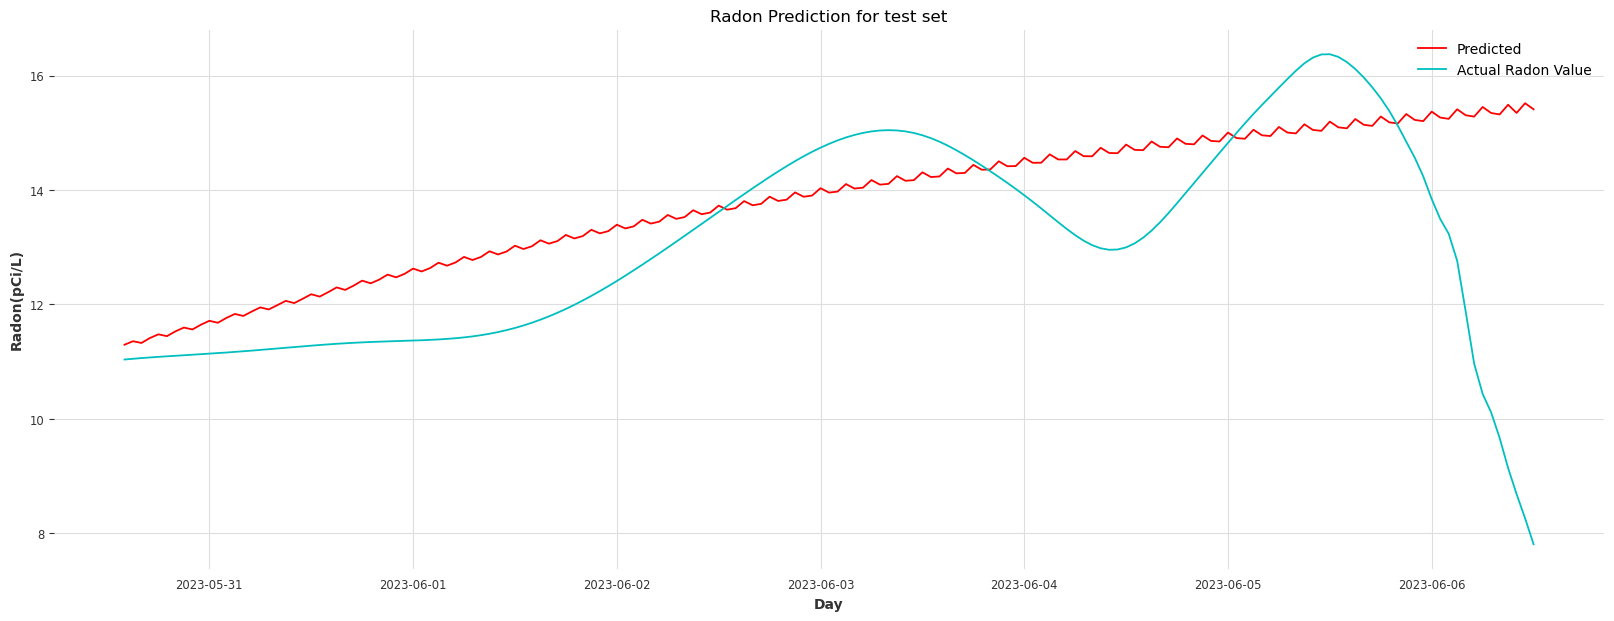

In [18]:
# plot the forecast
plt.figure(100, figsize=(20, 7))
plt.plot(dfY.index, dfY['Predicted'], color='r', label='Predicted')
plt.plot(dfY.index, dfY['Actual'], color='c', label='Actual Radon Value')
plt.legend()
plt.title('Radon Prediction for test set')
plt.xlabel('Day')
plt.ylabel('Radon(pCi/L)')
plt.show()

# Radon 13

In [19]:
df = df_radon['13'].copy()

In [20]:
# Denoising the Radon signal
def madev(d, axis=None):
    """ Mean absolute deviation of a signal """
    return np.mean(np.absolute(d - np.mean(d, axis)), axis)

In [21]:
def wavelet_denoising(x, wavelet='db4', level=5):
    coeff = pywt.wavedec(x, wavelet, mode="per")
    n = len(x) 
    sigma = (1/0.6745) * madev(coeff[-level])
    uthresh = sigma * np.sqrt(2 * np.log(len(x)))
    coeff[1:] = (pywt.threshold(i, value=uthresh, mode='hard') for i in coeff[1:])
    if len(x) % 2 ==0:
        return pywt.waverec(coeff, wavelet, mode='per')
    else:
        return pywt.waverec(coeff, wavelet, mode='per')[:n]

In [22]:
signal = df['Radon'].copy()
wavelet_name='coif17'
filtered = wavelet_denoising(signal, wavelet=wavelet_name, level=4)
df['Radon'] = filtered

In [23]:
# create time series object for target variable
ts_P = TimeSeries.from_series(df["Radon"], fill_missing_dates=True, freq="H") 

# check attributes of the time series
print("components:", ts_P.components)
print("duration:",ts_P.duration)
print("frequency:",ts_P.freq)
print("frequency:",ts_P.freq_str)
print("has date time index? (or else, it must have an integer index):",ts_P.has_datetime_index)
print("deterministic:",ts_P.is_deterministic)
print("univariate:",ts_P.is_univariate)

components: Index(['Radon'], dtype='object', name='component')
duration: 390 days 17:00:00
frequency: <Hour>
frequency: H
has date time index? (or else, it must have an integer index): True
deterministic: True
univariate: True


In [24]:
# train/test split and scaling of target variable
ts_train, ts_test = ts_P.split_after(split_point=9210)

print("training start:", ts_train.start_time())
print("training end:", ts_train.end_time())
print("training duration:",ts_train.duration)
print("test start:", ts_test.start_time())
print("test end:", ts_test.end_time())
print("test duration:", ts_test.duration)


scalerP = Scaler()
scalerP.fit_transform(ts_train)
ts_ttrain = scalerP.transform(ts_train)
ts_ttest = scalerP.transform(ts_test)    
ts_t = scalerP.transform(ts_P)

# make sure data are of type float
ts_t = ts_t.astype(np.float32)
ts_ttrain = ts_ttrain.astype(np.float32)
ts_ttest = ts_ttest.astype(np.float32)

print("first and last row of scaled Radon time series:")
pd.options.display.float_format = '{:,.2f}'.format
ts_t.pd_dataframe().iloc[[0,-1]]

training start: 2022-05-11 19:00:00
training end: 2023-05-30 13:00:00
training duration: 383 days 18:00:00
test start: 2023-05-30 14:00:00
test end: 2023-06-06 12:00:00
test duration: 6 days 22:00:00
first and last row of scaled Radon time series:


component,Radon
SyncDate,
2022-05-11 19:00:00,0.05
2023-06-06 12:00:00,0.05


In [25]:
print("first and last row of scaled target variable in training set: price:")
ts_ttrain.pd_dataframe().iloc[[0,-1]]

first and last row of scaled target variable in training set: price:


component,Radon
SyncDate,
2022-05-11 19:00:00,0.05
2023-05-30 13:00:00,0.03


In [26]:
import torch
from ray.air import session
from darts.utils.losses import SmapeLoss
from torchmetrics import MetricCollection, SymmetricMeanAbsolutePercentageError, MeanAbsolutePercentageError
def build_fit_nhits_model(
    model_args,
    save_checkpoints=False,
    callbacks=None,
    save_model=False
):
#     BATCH_SIZE=64
    MAX_EPOCHS=500
    NR_EPOCHS_VAL_PERIOD=1

    torch_metrics = MetricCollection([MeanAbsolutePercentageError(), SymmetricMeanAbsolutePercentageError()])

#     early_stopper = EarlyStopping(
#         monitor="val_loss",
#         patience=5,
#         min_delta=0.001,
#         mode='min',
#     )

#     if callbacks is None:
#         callbacks = [early_stopper]
#     else:
#         callbacks.append(early_stopper)
    
    #detect if GPU is available
#     if torch.cuda.is_available():
#         pl_trainer_kwargs = {
#             "accelerator": "gpu",
#             "gpus": -1,
#             "auto_select_gpus": True,
#             "callbacks": callbacks,
#             "enable_progress_bar":False,
#         }
#         num_workers=8
#     else:
#         pl_trainer_kwargs={
#             "callbacks": callbacks,
#         }
#         num_workers=0
    pl_trainer_kwargs={
            "accelerator": "gpu",
            "gpus":-1,
            "auto_select_gpus": True,
            "callbacks": callbacks,
            "enable_progress_bar": False,
        }
   
   

    model = NHiTSModel(
        input_chunk_length=model_args['in_len'],
        output_chunk_length=model_args['out_len'],
        batch_size=model_args['batch_size'],
        n_epochs=MAX_EPOCHS,
        nr_epochs_val_period=NR_EPOCHS_VAL_PERIOD,
        model_name="NHiTS",
        num_stacks=model_args['num_stacks'],
        num_blocks = model_args['num_blocks'],
        num_layers = model_args['num_layers'],
        dropout=model_args['dropout'],
        activation = model_args['activation'],
        MaxPool1d=model_args['MaxPool1d'],
        loss_fn=SmapeLoss(),
        optimizer_kwargs={'lr': model_args['lr']},
       
        log_tensorboard=False,
        force_reset=True,
        save_checkpoints=save_checkpoints,
        pl_trainer_kwargs=pl_trainer_kwargs,
        torch_metrics=torch_metrics,
        random_state=42
        )
    val_len = len(ts_test)
    val_series = ts_ttrain[-((val_len) + model_args['in_len']) :]
    ts_ttrain_input = ts_ttrain[:-(val_len )]
    model.fit(  ts_ttrain_input, 
                
                val_series=val_series,
                )
#     model.load_from_checkpoint(f"{model_args['model']} RNN model", best=True)
    ts_tpred = model.predict(
                series = ts_ttrain,
                
                n = len(ts_ttest),
                verbose=True
    )
    ts_q = scalerP.inverse_transform(ts_tpred)
    q_smape = smape(ts_q, ts_test)
    session.report({'q_smape': q_smape})

In [27]:
def build_fit_nhits_model_return(
    model_args,
    save_checkpoints=False,
    callbacks=None,
    save_model=False
):
#     BATCH_SIZE=64
    MAX_EPOCHS=500
    NR_EPOCHS_VAL_PERIOD=1

    torch_metrics = MetricCollection([MeanAbsolutePercentageError(), SymmetricMeanAbsolutePercentageError()])

#     early_stopper = EarlyStopping(
#         monitor="val_loss",
#         patience=5,
#         min_delta=0.001,
#         mode='min',
#     )

#     if callbacks is None:
#         callbacks = [early_stopper]
#     else:
#         callbacks.append(early_stopper)
    
    #detect if GPU is available
#     if torch.cuda.is_available():
#         pl_trainer_kwargs = {
#             "accelerator": "gpu",
#             "gpus": -1,
#             "auto_select_gpus": True,
#             "callbacks": callbacks,
#             "enable_progress_bar":False,
#         }
#         num_workers=8
#     else:
#         pl_trainer_kwargs={
#             "callbacks": callbacks,
#         }
#         num_workers=0
    pl_trainer_kwargs={
            "accelerator": "gpu",
            "gpus":1,
            "auto_select_gpus": True,
            "callbacks": callbacks,
            "enable_progress_bar": False,
        }
   
    

    model = NHiTSModel(
        input_chunk_length=model_args['in_len'],
        output_chunk_length=model_args['out_len'],
        batch_size=model_args['batch_size'],
        n_epochs=MAX_EPOCHS,
        nr_epochs_val_period=NR_EPOCHS_VAL_PERIOD,
        model_name="NHiTS",
        num_stacks=model_args['num_stacks'],
        num_blocks = model_args['num_blocks'],
        num_layers = model_args['num_layers'],
        dropout=model_args['dropout'],
        activation = model_args['activation'],
        MaxPool1d=model_args['MaxPool1d'],
        loss_fn=SmapeLoss(),
        optimizer_kwargs={'lr': model_args['lr']},
        log_tensorboard=False,
        force_reset=True,
        save_checkpoints=save_checkpoints,
        pl_trainer_kwargs=pl_trainer_kwargs,
        torch_metrics=torch_metrics,
        random_state=42
        )
    val_len = len(ts_test)
    val_series = ts_ttrain[-((val_len) + model_args['in_len']) :]
    ts_ttrain_input = ts_ttrain[:-(val_len )]
    model.fit(  ts_ttrain_input, 
                
                val_series=val_series,
                )
#     model.load_from_checkpoint(f"{model_args['model']} RNN model", best=True)
#     ts_tpred = model.predict(
#                 series = ts_ttrain,
#                 past_covariates=covF_t,
#                 n = len(ts_ttest),
#                 verbose=True
#     )
#     ts_q = scalerP.inverse_transform(ts_tpred)
#     q_smape = smape(ts_q, ts_test)
#     session.report({'q_smape': q_smape})
    return model

In [28]:
from ray import tune
from ray.tune import CLIReporter
# from ray.tune.integration.pytorch_lightning import TuneReportCallback
from ray.tune.schedulers import ASHAScheduler, AsyncHyperBandScheduler
from ray.tune.search.optuna import OptunaSearch
from ray.tune.search import ConcurrencyLimiter
# tune_callback = TuneReportCallback(
#     {
#         "loss":"val_loss",
#         "sMAPE": "val_SymmetricMeanAbsolutePercentageError",
#     },
#     on="validation_end",
# )

early_stopper = EarlyStopping(
        monitor="val_SymmetricMeanAbsolutePercentageError",
        patience=3,
        mode='min',
    )

#define the hyperparameter search space
config = {
    "in_len": tune.randint(8,30),
    "out_len":tune.randint(1,4),
    "batch_size":tune.choice([32,64,128,256]),
    "num_stacks":tune.choice([1,2,3]),
    "num_blocks": tune.randint(1,10),
    "num_layers":tune.randint(1,5),
    "dropout":tune.uniform(0.1,0.5),
    "activation":tune.choice(['ReLU','RReLU', 'PReLU', 'Softplus', 'Tanh', 'SELU', 'LeakyReLU','Sigmoid']),
    "MaxPool1d":tune.choice([True, False]),
    "lr":tune.loguniform(1e-5,1e-1),
   
}

reporter = CLIReporter(
    parameter_columns=list(config.keys()),
    metric_columns=["q_smape"])
resources_per_trial = {"cpu": 5, "gpu": 0.4}

num_samples = 100

algo = OptunaSearch()

algo = ConcurrencyLimiter(algo, max_concurrent=10)

scheduler = AsyncHyperBandScheduler(max_t=100, grace_period=10, reduction_factor=2)

train_fn_with_parameters = tune.with_parameters(build_fit_nhits_model, callbacks=[early_stopper])

analysis = tune.run(
    train_fn_with_parameters,
    resources_per_trial=resources_per_trial,
    metric="q_smape",
    mode="min",
    config=config,
    num_samples=num_samples,
    search_alg=algo,
    scheduler = scheduler,
    progress_reporter=reporter,
    name="nhits_tune",
    raise_on_failed_trial=False
)

print("Best hyperparameters found were: ", analysis.best_config)

== Status ==
Current time: 2023-07-08 21:02:01 (running for 00:00:00.15)
Memory usage on this node: 28.7/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 5.0/48 CPUs, 0.4/4 GPUs, 0.0/104.83 GiB heap, 0.0/48.92 GiB objects (0.0/1.0 accelerator_type:A10G)
Result logdir: /home/ubuntu/ray_results/nhits_tune
Number of trials: 1/100 (1 RUNNING)
+--------------------------------+----------+----------------------+----------+-----------+--------------+--------------+--------------+--------------+-----------+--------------+-------------+-------------+
| Trial name                     | status   | loc                  |   in_len |   out_len |   batch_size |   num_stacks |   num_blocks |   num_layers |   dropout | activation   | MaxPool1d   |          lr |
|--------------------------------+----------+----------------------+----------+-----------+--------------+--------------+--------------+---

(build_fit_nhits_model pid=1675242) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nhits_model pid=1675242)   rank_zero_deprecation(
(build_fit_nhits_model pid=1675242) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nhits_model pid=1675242)   rank_zero_deprecation(
(build_fit_nhits_model pid=1675242) Auto select gpus: [0]
(build_fit_nhits_model pid=1675242) GPU available: True (cuda), used: True
(build_fit_nhits_model pid=1675242) TPU availabl

== Status ==
Current time: 2023-07-08 21:02:11 (running for 00:00:09.78)
Memory usage on this node: 32.0/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/104.83 GiB heap, 0.0/48.92 GiB objects (0.0/1.0 accelerator_type:A10G)
Result logdir: /home/ubuntu/ray_results/nhits_tune
Number of trials: 9/100 (1 PENDING, 8 RUNNING)
+--------------------------------+----------+----------------------+----------+-----------+--------------+--------------+--------------+--------------+-----------+--------------+-------------+-------------+
| Trial name                     | status   | loc                  |   in_len |   out_len |   batch_size |   num_stacks |   num_blocks |   num_layers |   dropout | activation   | MaxPool1d   |          lr |
|--------------------------------+----------+----------------------+----------+-----------+--------------+------

(build_fit_nhits_model pid=1675641) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nhits_model pid=1675641)   rank_zero_deprecation(
(build_fit_nhits_model pid=1675641) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nhits_model pid=1675641)   rank_zero_deprecation(
(build_fit_nhits_model pid=1675690) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning

(build_fit_nhits_model pid=1675641) GPU available: True (cuda), used: True
(build_fit_nhits_model pid=1675641) TPU available: False, using: 0 TPU cores
(build_fit_nhits_model pid=1675641) IPU available: False, using: 0 IPUs
(build_fit_nhits_model pid=1675641) HPU available: False, using: 0 HPUs
(build_fit_nhits_model pid=1675641) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nhits_model pid=1675641) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]
(build_fit_nhits_model pid=1675641) 
(build_fit_nhits_model pid=1675641)   | Name          | Type             | Params
(build_fit_nhits_model pid=1675641) ---------------------------------------------------
(build_fit_nhits_model pid=1675

(build_fit_nhits_model pid=1675629) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('train_MeanAbsolutePercentageError', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
(build_fit_nhits_model pid=1675629)   rank_zero_warn(
(build_fit_nhits_model pid=1675636) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('train_MeanAbsolutePercentageError', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
(build_fit_nhits_model pid=1675636)   rank_zero_warn(
(build_fit_nhits_model pid=1675636) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('train_SymmetricMeanAbsolutePercentageError', ..., logger=True)` but have no logger configured. You can enable one by doing

== Status ==
Current time: 2023-07-08 21:02:16 (running for 00:00:14.94)
Memory usage on this node: 43.1/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/104.83 GiB heap, 0.0/48.92 GiB objects (0.0/1.0 accelerator_type:A10G)
Result logdir: /home/ubuntu/ray_results/nhits_tune
Number of trials: 9/100 (1 PENDING, 8 RUNNING)
+--------------------------------+----------+----------------------+----------+-----------+--------------+--------------+--------------+--------------+-----------+--------------+-------------+-------------+
| Trial name                     | status   | loc                  |   in_len |   out_len |   batch_size |   num_stacks |   num_blocks |   num_layers |   dropout | activation   | MaxPool1d   |          lr |
|--------------------------------+----------+----------------------+----------+-----------+--------------+------

(build_fit_nhits_model pid=1675641) Auto select gpus: [0]
(build_fit_nhits_model pid=1675641) GPU available: True (cuda), used: True
(build_fit_nhits_model pid=1675641) TPU available: False, using: 0 TPU cores
(build_fit_nhits_model pid=1675641) IPU available: False, using: 0 IPUs
(build_fit_nhits_model pid=1675641) HPU available: False, using: 0 HPUs
(build_fit_nhits_model pid=1675641) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nhits_model pid=1675641) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


Predicting DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


Trial name,date,done,episodes_total,experiment_id,experiment_tag,hostname,iterations_since_restore,node_ip,pid,q_smape,time_since_restore,time_this_iter_s,time_total_s,timestamp,timesteps_since_restore,timesteps_total,training_iteration,trial_id,warmup_time
build_fit_nhits_model_01bff03c,2023-07-08_21-05-12,True,,2b4b85a07aee41d19458b97a0f08e03f,"33_MaxPool1d=False,activation=LeakyReLU,batch_size=32,dropout=0.2864,in_len=16,lr=0.0044,num_blocks=3,num_layers=1,num_stacks=2,out_len=1",ip-172-31-10-87,1,172.31.10.87,1685747,195.1767073134925,33.520835876464844,33.520835876464844,33.520835876464844,1688850312,0,,1,01bff03c,0.0028464794158935547
build_fit_nhits_model_0a07fff5,2023-07-08_21-12-01,True,,991956ff31a74563ac09846b7604439c,"74_MaxPool1d=True,activation=Softplus,batch_size=32,dropout=0.4095,in_len=28,lr=0.0001,num_blocks=5,num_layers=2,num_stacks=1,out_len=3",ip-172-31-10-87,1,172.31.10.87,1695882,88.82662525093359,146.45625114440918,146.45625114440918,146.45625114440918,1688850721,0,,1,0a07fff5,0.003140687942504883
build_fit_nhits_model_0a8ad45b,2023-07-08_21-17-32,True,,3b61788a38374d02b81d4edadb43fdf1,"99_MaxPool1d=True,activation=RReLU,batch_size=32,dropout=0.4163,in_len=8,lr=0.0007,num_blocks=6,num_layers=4,num_stacks=1,out_len=3",ip-172-31-10-87,1,172.31.10.87,1702060,191.9250091396716,96.39114451408386,96.39114451408386,96.39114451408386,1688851052,0,,1,0a8ad45b,0.0030372142791748047
build_fit_nhits_model_0d0bba03,2023-07-08_21-07-27,True,,791dd8a2d4a547dd8e450ffba190cfbb,"49_MaxPool1d=False,activation=PReLU,batch_size=32,dropout=0.4563,in_len=25,lr=0.0004,num_blocks=4,num_layers=4,num_stacks=1,out_len=3",ip-172-31-10-87,1,172.31.10.87,1689572,154.53351856213672,113.12777519226074,113.12777519226074,113.12777519226074,1688850447,0,,1,0d0bba03,0.0029091835021972656
build_fit_nhits_model_0d1a3bb4,2023-07-08_21-07-15,True,,6e5240e09063452d889ea504518fe418,"54_MaxPool1d=False,activation=PReLU,batch_size=32,dropout=0.4618,in_len=22,lr=0.0003,num_blocks=4,num_layers=4,num_stacks=1,out_len=3",ip-172-31-10-87,1,172.31.10.87,1690987,80.78428374708245,79.92809247970581,79.92809247970581,79.92809247970581,1688850435,0,,1,0d1a3bb4,0.002955913543701172
build_fit_nhits_model_0e760ce5,2023-07-08_21-04-29,True,,bd0cd22883ae4d7898feb63ce0fb6fe0,"25_MaxPool1d=True,activation=Sigmoid,batch_size=256,dropout=0.1134,in_len=29,lr=0.0001,num_blocks=6,num_layers=2,num_stacks=3,out_len=3",ip-172-31-10-87,1,172.31.10.87,1683950,179.58703607497,24.068463563919067,24.068463563919067,24.068463563919067,1688850269,0,,1,0e760ce5,0.003141641616821289
build_fit_nhits_model_152c3a4e,2023-07-08_21-02-35,True,,b952f4bdb4a34bcc9daa98c43ce1c00a,"9_MaxPool1d=True,activation=ReLU,batch_size=256,dropout=0.2589,in_len=19,lr=0.0466,num_blocks=7,num_layers=2,num_stacks=2,out_len=1",ip-172-31-10-87,1,172.31.10.87,1677961,nan,10.439661741256714,10.439661741256714,10.439661741256714,1688850155,0,,1,152c3a4e,0.003052949905395508
build_fit_nhits_model_1691fb78,2023-07-08_21-11-47,True,,720eb0c59d72455da384f7110ea94496,"76_MaxPool1d=True,activation=Softplus,batch_size=32,dropout=0.4095,in_len=28,lr=0.0006,num_blocks=7,num_layers=2,num_stacks=1,out_len=3",ip-172-31-10-87,1,172.31.10.87,1696372,84.27961740315735,92.26233458518982,92.26233458518982,92.26233458518982,1688850707,0,,1,1691fb78,0.003073453903198242
build_fit_nhits_model_1bd13504,2023-07-08_21-12-07,True,,d95e925e6a7346499b42625ca357b808,"78_MaxPool1d=True,activation=Softplus,batch_size=32,dropout=0.4758,in_len=9,lr=0.0005,num_blocks=7,num_layers=4,num_stacks=1,out_len=3",ip-172-31-10-87,1,172.31.10.87,1696855,76.28906701774416,88.8542685508728,88.8542685508728,88.8542685508728,1688850727,0,,1,1bd13504,0.0028772354125976562
build_fit_nhits_model_1cd8bcbb,2023-07-08_21-13-23,True,,7bb2be34f86543debcc514807bb4c6ca,"66_MaxPool1d=True,activation=RReLU,batch_size=32,dropout=0.4247,in_len=22,lr=0.0001,num_blocks=5,num_layers=4,num_stacks=2,out_len=3",ip-172-31-10-87,1,172.31.10.87,1693605,189.32014796349478,351.

Predicting DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(build_fit_nhits_model pid=1675633) Auto select gpus: [0]
(build_fit_nhits_model pid=1675633) GPU available: True (cuda), used: True
(build_fit_nhits_model pid=1675633) TPU available: False, using: 0 TPU cores
(build_fit_nhits_model pid=1675633) IPU available: False, using: 0 IPUs
(build_fit_nhits_model pid=1675633) HPU available: False, using: 0 HPUs
(build_fit_nhits_model pid=1675633) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nhits_model pid=1675633) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(build_fit_nhits_model pid=1675638) Auto select gpus: [0]
(build_fit_nhits_model pid=1675638) GPU available: True (cuda), used: True
(build_fit_nhits_model pid=1675638) TPU available: False, using: 0 TPU cores
(build_fit_nhits_model pid=1675638) IPU available: False, using: 0 IPUs
(build_fit_nhits_model pid=1675638) HPU available: False, using: 0 HPUs
(build_fit_nhits_model pid=1675638) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nhits_model pid=1675638) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  7.68it/s]


(build_fit_nhits_model pid=1677961) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nhits_model pid=1677961)   rank_zero_deprecation(
(build_fit_nhits_model pid=1677961) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nhits_model pid=1677961)   rank_zero_deprecation(


== Status ==
Current time: 2023-07-08 21:02:24 (running for 00:00:22.43)
Memory usage on this node: 42.1/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/104.83 GiB heap, 0.0/48.92 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 4765bd90 with q_smape=154.6437722430036 and parameters={'in_len': 24, 'out_len': 3, 'batch_size': 256, 'num_stacks': 1, 'num_blocks': 8, 'num_layers': 4, 'dropout': 0.4018175347768702, 'activation': 'Tanh', 'MaxPool1d': True, 'lr': 0.0014219076335611324}
Result logdir: /home/ubuntu/ray_results/nhits_tune
Number of trials: 11/100 (1 PENDING, 8 RUNNING, 2 TERMINATED)
+--------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+--------------+-----------+--------------+-------------+-------------+-----------+
| Trial name   

(build_fit_nhits_model pid=1678123) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nhits_model pid=1678123)   rank_zero_deprecation(
(build_fit_nhits_model pid=1678123) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nhits_model pid=1678123)   rank_zero_deprecation(
(build_fit_nhits_model pid=1677961) Auto select gpus: [0]
(build_fit_nhits_model pid=1677961) GPU available: True (cuda), used: True
(build_fit_nhits_model pid=1677961) TPU availabl

Predicting DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(build_fit_nhits_model pid=1675631) Auto select gpus: [0]
(build_fit_nhits_model pid=1675631) GPU available: True (cuda), used: True
(build_fit_nhits_model pid=1675631) TPU available: False, using: 0 TPU cores
(build_fit_nhits_model pid=1675631) IPU available: False, using: 0 IPUs
(build_fit_nhits_model pid=1675631) HPU available: False, using: 0 HPUs
(build_fit_nhits_model pid=1675631) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nhits_model pid=1675631) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 14.53it/s]


(build_fit_nhits_model pid=1678123) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('val_MeanAbsolutePercentageError', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
(build_fit_nhits_model pid=1678123)   rank_zero_warn(
(build_fit_nhits_model pid=1678123) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('val_SymmetricMeanAbsolutePercentageError', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
(build_fit_nhits_model pid=1678123)   rank_zero_warn(
(build_fit_nhits_model pid=1678123) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('train_MeanAbsolutePercentageError', ..., logger=True)` but have no logger configured. You can enable one by doing `Tr

== Status ==
Current time: 2023-07-08 21:02:33 (running for 00:00:31.76)
Memory usage on this node: 43.2/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/104.83 GiB heap, 0.0/48.92 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 4765bd90 with q_smape=154.6437722430036 and parameters={'in_len': 24, 'out_len': 3, 'batch_size': 256, 'num_stacks': 1, 'num_blocks': 8, 'num_layers': 4, 'dropout': 0.4018175347768702, 'activation': 'Tanh', 'MaxPool1d': True, 'lr': 0.0014219076335611324}
Result logdir: /home/ubuntu/ray_results/nhits_tune
Number of trials: 13/100 (1 PENDING, 8 RUNNING, 4 TERMINATED)
+--------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+--------------+-----------+--------------+-------------+-------------+-----------+
| Trial name   

(build_fit_nhits_model pid=1678558) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('val_MeanAbsolutePercentageError', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
(build_fit_nhits_model pid=1678558)   rank_zero_warn(
(build_fit_nhits_model pid=1678558) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('val_SymmetricMeanAbsolutePercentageError', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
(build_fit_nhits_model pid=1678558)   rank_zero_warn(
(build_fit_nhits_model pid=1678123) Auto select gpus: [0]
(build_fit_nhits_model pid=1678123) GPU available: True (cuda), used: True
(build_fit_nhits_model pid=1678123) TPU available: False, using: 0 TPU cores
(build_fit_nhits_model pid=1678123) IPU available: False, using: 0 

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 10.00it/s]


(build_fit_nhits_model pid=1678830) Auto select gpus: [0]
(build_fit_nhits_model pid=1678830) GPU available: True (cuda), used: True
(build_fit_nhits_model pid=1678830) TPU available: False, using: 0 TPU cores
(build_fit_nhits_model pid=1678830) IPU available: False, using: 0 IPUs
(build_fit_nhits_model pid=1678830) HPU available: False, using: 0 HPUs
(build_fit_nhits_model pid=1678830) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nhits_model pid=1678830) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]
(build_fit_nhits_model pid=1678830) 
(build_fit_nhits_model pid=1678830)   | Name          | Type             | Params
(build_fit_nhits_model pid=1678830) -------------------------

Predicting DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(build_fit_nhits_model pid=1678830) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('val_MeanAbsolutePercentageError', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
(build_fit_nhits_model pid=1678830)   rank_zero_warn(
(build_fit_nhits_model pid=1678830) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('val_SymmetricMeanAbsolutePercentageError', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
(build_fit_nhits_model pid=1678830)   rank_zero_warn(
(build_fit_nhits_model pid=1678830) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('train_MeanAbsolutePercentageError', ..., logger=True)` but have no logger configured. You can enable one by doing `Tr

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  1.71it/s]


(build_fit_nhits_model pid=1677961) /home/ubuntu/anaconda3/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:530: RuntimeWarning: overflow encountered in true_divide
(build_fit_nhits_model pid=1677961)   X /= self.scale_
(build_fit_nhits_model pid=1677961) /home/ubuntu/anaconda3/lib/python3.9/site-packages/darts/metrics/metrics.py:665: RuntimeWarning: invalid value encountered in true_divide
(build_fit_nhits_model pid=1677961)   return 200.0 * np.mean(np.abs(y_true - y_hat) / (np.abs(y_true) + np.abs(y_hat)))
(build_fit_nhits_model pid=1679374) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nhits_model pid=1679374)   rank_zero_deprecation(
(build_fit_nhits_model pid=1679374) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorc

== Status ==
Current time: 2023-07-08 21:02:41 (running for 00:00:39.77)
Memory usage on this node: 45.3/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/104.83 GiB heap, 0.0/48.92 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 4765bd90 with q_smape=154.6437722430036 and parameters={'in_len': 24, 'out_len': 3, 'batch_size': 256, 'num_stacks': 1, 'num_blocks': 8, 'num_layers': 4, 'dropout': 0.4018175347768702, 'activation': 'Tanh', 'MaxPool1d': True, 'lr': 0.0014219076335611324}
Result logdir: /home/ubuntu/ray_results/nhits_tune
Number of trials: 15/100 (1 ERROR, 1 PENDING, 8 RUNNING, 5 TERMINATED)
+--------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+--------------+-----------+--------------+-------------+-------------+-----------+
| Tria

(build_fit_nhits_model pid=1679612) Auto select gpus: [0]
(build_fit_nhits_model pid=1679612) GPU available: True (cuda), used: True
(build_fit_nhits_model pid=1679612) TPU available: False, using: 0 TPU cores
(build_fit_nhits_model pid=1679612) IPU available: False, using: 0 IPUs
(build_fit_nhits_model pid=1679612) HPU available: False, using: 0 HPUs
(build_fit_nhits_model pid=1679612) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nhits_model pid=1679612) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]
(build_fit_nhits_model pid=1679612) 
(build_fit_nhits_model pid=1679612)   | Name          | Type             | Params
(build_fit_nhits_model pid=1679612) -------------------------

Predicting DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(build_fit_nhits_model pid=1675629) Auto select gpus: [0]
(build_fit_nhits_model pid=1675629) GPU available: True (cuda), used: True
(build_fit_nhits_model pid=1675629) TPU available: False, using: 0 TPU cores
(build_fit_nhits_model pid=1675629) IPU available: False, using: 0 IPUs
(build_fit_nhits_model pid=1675629) HPU available: False, using: 0 HPUs
(build_fit_nhits_model pid=1675629) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nhits_model pid=1675629) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 11.99it/s]


(build_fit_nhits_model pid=1678558) Auto select gpus: [0]
(build_fit_nhits_model pid=1678558) GPU available: True (cuda), used: True
(build_fit_nhits_model pid=1678558) TPU available: False, using: 0 TPU cores
(build_fit_nhits_model pid=1678558) IPU available: False, using: 0 IPUs
(build_fit_nhits_model pid=1678558) HPU available: False, using: 0 HPUs
(build_fit_nhits_model pid=1678558) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nhits_model pid=1678558) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  2.92it/s]


(build_fit_nhits_model pid=1679374) Auto select gpus: [0]
(build_fit_nhits_model pid=1679374) GPU available: True (cuda), used: True
(build_fit_nhits_model pid=1679374) TPU available: False, using: 0 TPU cores
(build_fit_nhits_model pid=1679374) IPU available: False, using: 0 IPUs
(build_fit_nhits_model pid=1679374) HPU available: False, using: 0 HPUs
(build_fit_nhits_model pid=1679374) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nhits_model pid=1679374) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
== Status ==
Current time: 2023-07-08 21:02:48 (running for 00:00:46.22)
Memory usage on this node: 45.1/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/104.83 GiB heap, 0.0/48.92 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 328e48dd with q_smape=29.763296257734712 and parameters={'in_len': 22, 'out_len': 3, 'batch_size': 256, 'num_stacks': 3, 'num_blocks': 2, 'num_layers': 2, 'dropout': 0.4531981109814519, 'activation': 'Sigmoid', 'MaxPool1d': True, 'lr': 0.0008943775500894087}
Result logdir: /home/ubuntu/ray_results/nhits_tune
Number of trials: 16/100 (1 ERROR, 1 PENDING, 8 RUNNING, 6 TERMINATED)
+--------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+--------------+-------

(build_fit_nhits_model pid=1679928) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nhits_model pid=1679928)   rank_zero_deprecation(
(build_fit_nhits_model pid=1679928) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nhits_model pid=1679928)   rank_zero_deprecation(
(build_fit_nhits_model pid=1679374) /home/ubuntu/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
(build_fit_nhits_model pi

Predicting DataLoader 0: 100%|██████████| 1/1 [00:01<00:00,  1.17s/it]


(build_fit_nhits_model pid=1679928) Auto select gpus: [0]
(build_fit_nhits_model pid=1679928) GPU available: True (cuda), used: True
(build_fit_nhits_model pid=1679928) TPU available: False, using: 0 TPU cores
(build_fit_nhits_model pid=1679928) IPU available: False, using: 0 IPUs
(build_fit_nhits_model pid=1679928) HPU available: False, using: 0 HPUs
(build_fit_nhits_model pid=1679928) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nhits_model pid=1679928) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
(build_fit_nhits_model pid=1679928) 
(build_fit_nhits_model pid=1679928)   | Name          | Type             | Params
(build_fit_nhits_model pid=1679928) -------------------------

== Status ==
Current time: 2023-07-08 21:02:55 (running for 00:00:53.78)
Memory usage on this node: 42.4/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/104.83 GiB heap, 0.0/48.92 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 328e48dd with q_smape=29.763296257734712 and parameters={'in_len': 22, 'out_len': 3, 'batch_size': 256, 'num_stacks': 3, 'num_blocks': 2, 'num_layers': 2, 'dropout': 0.4531981109814519, 'activation': 'Sigmoid', 'MaxPool1d': True, 'lr': 0.0008943775500894087}
Result logdir: /home/ubuntu/ray_results/nhits_tune
Number of trials: 18/100 (1 ERROR, 1 PENDING, 8 RUNNING, 8 TERMINATED)
+--------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+--------------+-----------+--------------+-------------+-------------+-----------+
| 

(build_fit_nhits_model pid=1680168) Auto select gpus: [0]
(build_fit_nhits_model pid=1680168) GPU available: True (cuda), used: True
(build_fit_nhits_model pid=1680168) TPU available: False, using: 0 TPU cores
(build_fit_nhits_model pid=1680168) IPU available: False, using: 0 IPUs
(build_fit_nhits_model pid=1680168) HPU available: False, using: 0 HPUs
(build_fit_nhits_model pid=1680168) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nhits_model pid=1680168) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]
(build_fit_nhits_model pid=1680168) 
(build_fit_nhits_model pid=1680168)   | Name          | Type             | Params
(build_fit_nhits_model pid=1680168) -------------------------

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  2.36it/s]


(build_fit_nhits_model pid=1675636) Auto select gpus: [0]
(build_fit_nhits_model pid=1675636) GPU available: True (cuda), used: True
(build_fit_nhits_model pid=1675636) TPU available: False, using: 0 TPU cores
(build_fit_nhits_model pid=1675636) IPU available: False, using: 0 IPUs
(build_fit_nhits_model pid=1675636) HPU available: False, using: 0 HPUs
(build_fit_nhits_model pid=1675636) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nhits_model pid=1675636) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  4.12it/s]
== Status ==
Current time: 2023-07-08 21:03:01 (running for 00:00:59.59)
Memory usage on this node: 43.4/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/104.83 GiB heap, 0.0/48.92 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 328e48dd with q_smape=29.763296257734712 and parameters={'in_len': 22, 'out_len': 3, 'batch_size': 256, 'num_stacks': 3, 'num_blocks': 2, 'num_layers': 2, 'dropout': 0.4531981109814519, 'activation': 'Sigmoid', 'MaxPool1d': True, 'lr': 0.0008943775500894087}
Result logdir: /home/ubuntu/ray_results/nhits_tune
Number of trials: 19/100 (1 ERROR, 1 PENDING, 8 RUNNING, 9 TERMINATED)
+--------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+--------------

(build_fit_nhits_model pid=1681039) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nhits_model pid=1681039)   rank_zero_deprecation(
(build_fit_nhits_model pid=1681039) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nhits_model pid=1681039)   rank_zero_deprecation(
(build_fit_nhits_model pid=1681039) Auto select gpus: [0]
(build_fit_nhits_model pid=1681039) GPU available: True (cuda), used: True
(build_fit_nhits_model pid=1681039) TPU availabl

== Status ==
Current time: 2023-07-08 21:03:08 (running for 00:01:06.77)
Memory usage on this node: 43.2/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/104.83 GiB heap, 0.0/48.92 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 328e48dd with q_smape=29.763296257734712 and parameters={'in_len': 22, 'out_len': 3, 'batch_size': 256, 'num_stacks': 3, 'num_blocks': 2, 'num_layers': 2, 'dropout': 0.4531981109814519, 'activation': 'Sigmoid', 'MaxPool1d': True, 'lr': 0.0008943775500894087}
Result logdir: /home/ubuntu/ray_results/nhits_tune
Number of trials: 20/100 (1 ERROR, 1 PENDING, 8 RUNNING, 10 TERMINATED)
+--------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+--------------+-----------+--------------+-------------+-------------+-----------+
|

(build_fit_nhits_model pid=1681351) Auto select gpus: [0]
(build_fit_nhits_model pid=1681351) GPU available: True (cuda), used: True
(build_fit_nhits_model pid=1681351) TPU available: False, using: 0 TPU cores
(build_fit_nhits_model pid=1681351) IPU available: False, using: 0 IPUs
(build_fit_nhits_model pid=1681351) HPU available: False, using: 0 HPUs
(build_fit_nhits_model pid=1681351) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nhits_model pid=1681351) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]
(build_fit_nhits_model pid=1681351) 
(build_fit_nhits_model pid=1681351)   | Name          | Type             | Params
(build_fit_nhits_model pid=1681351) -------------------------

== Status ==
Current time: 2023-07-08 21:03:13 (running for 00:01:11.78)
Memory usage on this node: 45.5/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/104.83 GiB heap, 0.0/48.92 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 328e48dd with q_smape=29.763296257734712 and parameters={'in_len': 22, 'out_len': 3, 'batch_size': 256, 'num_stacks': 3, 'num_blocks': 2, 'num_layers': 2, 'dropout': 0.4531981109814519, 'activation': 'Sigmoid', 'MaxPool1d': True, 'lr': 0.0008943775500894087}
Result logdir: /home/ubuntu/ray_results/nhits_tune
Number of trials: 20/100 (1 ERROR, 1 PENDING, 8 RUNNING, 10 TERMINATED)
+--------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+--------------+-----------+--------------+-------------+-------------+-----------+
|

(build_fit_nhits_model pid=1675690) Auto select gpus: [0]
(build_fit_nhits_model pid=1675690) GPU available: True (cuda), used: True
(build_fit_nhits_model pid=1675690) TPU available: False, using: 0 TPU cores
(build_fit_nhits_model pid=1675690) IPU available: False, using: 0 IPUs
(build_fit_nhits_model pid=1675690) HPU available: False, using: 0 HPUs
(build_fit_nhits_model pid=1675690) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nhits_model pid=1675690) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  2.26it/s]


(build_fit_nhits_model pid=1680329) Auto select gpus: [0]
(build_fit_nhits_model pid=1680329) GPU available: True (cuda), used: True
(build_fit_nhits_model pid=1680329) TPU available: False, using: 0 TPU cores
(build_fit_nhits_model pid=1680329) IPU available: False, using: 0 IPUs
(build_fit_nhits_model pid=1680329) HPU available: False, using: 0 HPUs
(build_fit_nhits_model pid=1680329) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nhits_model pid=1680329) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]l pid=1680329) 
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 33.66it/s]
== Status ==
Current time: 2023-07-08 21:03:19 (running for 00:01:17.76)
Memory usage on this node: 44.6/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/104.83 GiB heap, 0.0/48.92 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 328e48dd with q_smape=29.763296257734712 and parameters={'in_len': 22, 'out_len': 3, 'batch_size': 256, 'num_stacks': 3, 'num_blocks': 2, 'num_layers': 2, 'dropout': 0.4531981109814519, 'activation': 'Sigmoid', 'MaxPool1d': True, 'lr': 0.0008943775500894087}
Result logdir: /home/ubuntu/ray_results/nhits_tune
Number of trials: 20/100 (1 ERROR, 8 RUNNING, 11 TERMINATED)
+--------------------------------+------------+----------------------+----------+-----------+--------------+--------

(build_fit_nhits_model pid=1681836) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nhits_model pid=1681836)   rank_zero_deprecation(
(build_fit_nhits_model pid=1681836) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nhits_model pid=1681836)   rank_zero_deprecation(
(build_fit_nhits_model pid=1681836) Auto select gpus: [0]
(build_fit_nhits_model pid=1681836) GPU available: True (cuda), used: True
(build_fit_nhits_model pid=1681836) TPU availabl

== Status ==
Current time: 2023-07-08 21:03:29 (running for 00:01:27.79)
Memory usage on this node: 43.1/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/104.83 GiB heap, 0.0/48.92 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 328e48dd with q_smape=29.763296257734712 and parameters={'in_len': 22, 'out_len': 3, 'batch_size': 256, 'num_stacks': 3, 'num_blocks': 2, 'num_layers': 2, 'dropout': 0.4531981109814519, 'activation': 'Sigmoid', 'MaxPool1d': True, 'lr': 0.0008943775500894087}
Result logdir: /home/ubuntu/ray_results/nhits_tune
Number of trials: 22/100 (1 ERROR, 1 PENDING, 8 RUNNING, 12 TERMINATED)
+--------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+--------------+-----------+--------------+-------------+-------------+-----------+
|

(build_fit_nhits_model pid=1682272) Auto select gpus: [0]
(build_fit_nhits_model pid=1682272) GPU available: True (cuda), used: True
(build_fit_nhits_model pid=1682272) TPU available: False, using: 0 TPU cores
(build_fit_nhits_model pid=1682272) IPU available: False, using: 0 IPUs
(build_fit_nhits_model pid=1682272) HPU available: False, using: 0 HPUs
(build_fit_nhits_model pid=1682272) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nhits_model pid=1682272) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]
(build_fit_nhits_model pid=1682272) 
(build_fit_nhits_model pid=1682272)   | Name          | Type             | Params
(build_fit_nhits_model pid=1682272) -------------------------

== Status ==
Current time: 2023-07-08 21:03:34 (running for 00:01:32.80)
Memory usage on this node: 45.0/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/104.83 GiB heap, 0.0/48.92 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 328e48dd with q_smape=29.763296257734712 and parameters={'in_len': 22, 'out_len': 3, 'batch_size': 256, 'num_stacks': 3, 'num_blocks': 2, 'num_layers': 2, 'dropout': 0.4531981109814519, 'activation': 'Sigmoid', 'MaxPool1d': True, 'lr': 0.0008943775500894087}
Result logdir: /home/ubuntu/ray_results/nhits_tune
Number of trials: 22/100 (1 ERROR, 1 PENDING, 8 RUNNING, 12 TERMINATED)
+--------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+--------------+-----------+--------------+-------------+-------------+-----------+
|

== Status ==
Current time: 2023-07-08 21:03:44 (running for 00:01:42.81)
Memory usage on this node: 46.8/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/104.83 GiB heap, 0.0/48.92 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 328e48dd with q_smape=29.763296257734712 and parameters={'in_len': 22, 'out_len': 3, 'batch_size': 256, 'num_stacks': 3, 'num_blocks': 2, 'num_layers': 2, 'dropout': 0.4531981109814519, 'activation': 'Sigmoid', 'MaxPool1d': True, 'lr': 0.0008943775500894087}
Result logdir: /home/ubuntu/ray_results/nhits_tune
Number of trials: 22/100 (1 ERROR, 1 PENDING, 8 RUNNING, 12 TERMINATED)
+--------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+--------------+-----------+--------------+-------------+-------------+-----------+
|

(build_fit_nhits_model pid=1682272) Auto select gpus: [0]
(build_fit_nhits_model pid=1682272) GPU available: True (cuda), used: True
(build_fit_nhits_model pid=1682272) TPU available: False, using: 0 TPU cores
(build_fit_nhits_model pid=1682272) IPU available: False, using: 0 IPUs
(build_fit_nhits_model pid=1682272) HPU available: False, using: 0 HPUs
(build_fit_nhits_model pid=1682272) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nhits_model pid=1682272) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 10.85it/s]


(build_fit_nhits_model pid=1680168) Auto select gpus: [0]
(build_fit_nhits_model pid=1680168) GPU available: True (cuda), used: True
(build_fit_nhits_model pid=1680168) TPU available: False, using: 0 TPU cores
(build_fit_nhits_model pid=1680168) IPU available: False, using: 0 IPUs
(build_fit_nhits_model pid=1680168) HPU available: False, using: 0 HPUs
(build_fit_nhits_model pid=1680168) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nhits_model pid=1680168) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]


Predicting DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(build_fit_nhits_model pid=1681039) Auto select gpus: [0]
(build_fit_nhits_model pid=1681039) GPU available: True (cuda), used: True
(build_fit_nhits_model pid=1681039) TPU available: False, using: 0 TPU cores
(build_fit_nhits_model pid=1681039) IPU available: False, using: 0 IPUs
(build_fit_nhits_model pid=1681039) HPU available: False, using: 0 HPUs
(build_fit_nhits_model pid=1681039) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nhits_model pid=1681039) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  9.03it/s]


(build_fit_nhits_model pid=1683073) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nhits_model pid=1683073)   rank_zero_deprecation(
(build_fit_nhits_model pid=1683073) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nhits_model pid=1683073)   rank_zero_deprecation(


== Status ==
Current time: 2023-07-08 21:03:52 (running for 00:01:50.81)
Memory usage on this node: 43.1/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/104.83 GiB heap, 0.0/48.92 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 328e48dd with q_smape=29.763296257734712 and parameters={'in_len': 22, 'out_len': 3, 'batch_size': 256, 'num_stacks': 3, 'num_blocks': 2, 'num_layers': 2, 'dropout': 0.4531981109814519, 'activation': 'Sigmoid', 'MaxPool1d': True, 'lr': 0.0008943775500894087}
Result logdir: /home/ubuntu/ray_results/nhits_tune
Number of trials: 24/100 (1 ERROR, 1 PENDING, 8 RUNNING, 14 TERMINATED)
+--------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+--------------+-----------+--------------+-------------+-------------+-----------+
|

(build_fit_nhits_model pid=1683235) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nhits_model pid=1683235)   rank_zero_deprecation(
(build_fit_nhits_model pid=1683235) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nhits_model pid=1683235)   rank_zero_deprecation(
(build_fit_nhits_model pid=1683073) Auto select gpus: [0]
(build_fit_nhits_model pid=1683073) GPU available: True (cuda), used: True
(build_fit_nhits_model pid=1683073) TPU availabl

== Status ==
Current time: 2023-07-08 21:03:59 (running for 00:01:57.79)
Memory usage on this node: 43.3/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/104.83 GiB heap, 0.0/48.92 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 328e48dd with q_smape=29.763296257734712 and parameters={'in_len': 22, 'out_len': 3, 'batch_size': 256, 'num_stacks': 3, 'num_blocks': 2, 'num_layers': 2, 'dropout': 0.4531981109814519, 'activation': 'Sigmoid', 'MaxPool1d': True, 'lr': 0.0008943775500894087}
Result logdir: /home/ubuntu/ray_results/nhits_tune
Number of trials: 25/100 (1 ERROR, 1 PENDING, 8 RUNNING, 15 TERMINATED)
+--------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+--------------+-----------+--------------+-------------+-------------+-----------+
|

(build_fit_nhits_model pid=1681836) Auto select gpus: [0]
(build_fit_nhits_model pid=1681836) GPU available: True (cuda), used: True
(build_fit_nhits_model pid=1681836) TPU available: False, using: 0 TPU cores
(build_fit_nhits_model pid=1681836) IPU available: False, using: 0 IPUs
(build_fit_nhits_model pid=1681836) HPU available: False, using: 0 HPUs
(build_fit_nhits_model pid=1681836) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nhits_model pid=1681836) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  1.88it/s]


(build_fit_nhits_model pid=1683540) Auto select gpus: [0]
(build_fit_nhits_model pid=1683540) GPU available: True (cuda), used: True
(build_fit_nhits_model pid=1683540) TPU available: False, using: 0 TPU cores
(build_fit_nhits_model pid=1683540) IPU available: False, using: 0 IPUs
(build_fit_nhits_model pid=1683540) HPU available: False, using: 0 HPUs
(build_fit_nhits_model pid=1683540) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nhits_model pid=1683540) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]
(build_fit_nhits_model pid=1683540) 
(build_fit_nhits_model pid=1683540)   | Name          | Type             | Params
(build_fit_nhits_model pid=1683540) -------------------------

Predicting DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(build_fit_nhits_model pid=1683540) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('val_MeanAbsolutePercentageError', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
(build_fit_nhits_model pid=1683540)   rank_zero_warn(
(build_fit_nhits_model pid=1683540) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('val_SymmetricMeanAbsolutePercentageError', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
(build_fit_nhits_model pid=1683540)   rank_zero_warn(
(build_fit_nhits_model pid=1683540) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('train_MeanAbsolutePercentageError', ..., logger=True)` but have no logger configured. You can enable one by doing `Tr

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  2.65it/s]


(build_fit_nhits_model pid=1683950) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nhits_model pid=1683950)   rank_zero_deprecation(
(build_fit_nhits_model pid=1683950) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nhits_model pid=1683950)   rank_zero_deprecation(
(build_fit_nhits_model pid=1683950) Auto select gpus: [0]
(build_fit_nhits_model pid=1683950) GPU available: True (cuda), used: True
(build_fit_nhits_model pid=1683950) TPU availabl

== Status ==
Current time: 2023-07-08 21:04:07 (running for 00:02:05.81)
Memory usage on this node: 41.0/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/104.83 GiB heap, 0.0/48.92 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 328e48dd with q_smape=29.763296257734712 and parameters={'in_len': 22, 'out_len': 3, 'batch_size': 256, 'num_stacks': 3, 'num_blocks': 2, 'num_layers': 2, 'dropout': 0.4531981109814519, 'activation': 'Sigmoid', 'MaxPool1d': True, 'lr': 0.0008943775500894087}
Result logdir: /home/ubuntu/ray_results/nhits_tune
Number of trials: 27/100 (1 ERROR, 1 PENDING, 8 RUNNING, 17 TERMINATED)
+--------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+--------------+-----------+--------------+-------------+-------------+-----------+
|

(build_fit_nhits_model pid=1683950) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('val_MeanAbsolutePercentageError', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
(build_fit_nhits_model pid=1683950)   rank_zero_warn(
(build_fit_nhits_model pid=1683950) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('val_SymmetricMeanAbsolutePercentageError', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
(build_fit_nhits_model pid=1683950)   rank_zero_warn(
(build_fit_nhits_model pid=1683950) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('train_MeanAbsolutePercentageError', ..., logger=True)` but have no logger configured. You can enable one by doing `Tr

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 15.11it/s]


(build_fit_nhits_model pid=1683073) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]
(build_fit_nhits_model pid=1684514) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nhits_model pid=1684514)   rank_zero_deprecation(
(build_fit_nhits_model pid=1684514) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nhits_model pid=1684514)   rank_zero_deprecation(


== Status ==
Current time: 2023-07-08 21:04:15 (running for 00:02:13.79)
Memory usage on this node: 38.8/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/104.83 GiB heap, 0.0/48.92 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 328e48dd with q_smape=29.763296257734712 and parameters={'in_len': 22, 'out_len': 3, 'batch_size': 256, 'num_stacks': 3, 'num_blocks': 2, 'num_layers': 2, 'dropout': 0.4531981109814519, 'activation': 'Sigmoid', 'MaxPool1d': True, 'lr': 0.0008943775500894087}
Result logdir: /home/ubuntu/ray_results/nhits_tune
Number of trials: 28/100 (1 ERROR, 1 PENDING, 8 RUNNING, 18 TERMINATED)
+--------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+--------------+-----------+--------------+-------------+-------------+-----------+
|

(build_fit_nhits_model pid=1684514) Auto select gpus: [0]
(build_fit_nhits_model pid=1684514) GPU available: True (cuda), used: True
(build_fit_nhits_model pid=1684514) TPU available: False, using: 0 TPU cores
(build_fit_nhits_model pid=1684514) IPU available: False, using: 0 IPUs
(build_fit_nhits_model pid=1684514) HPU available: False, using: 0 HPUs
(build_fit_nhits_model pid=1684514) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nhits_model pid=1684514) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]
(build_fit_nhits_model pid=1684514) 
(build_fit_nhits_model pid=1684514)   | Name          | Type             | Params
(build_fit_nhits_model pid=1684514) -------------------------

Predicting DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(build_fit_nhits_model pid=1683540) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(build_fit_nhits_model pid=1684190) Auto select gpus: [0]
(build_fit_nhits_model pid=1684190) GPU available: True (cuda), used: True
(build_fit_nhits_model pid=1684190) TPU available: False, using: 0 TPU cores
(build_fit_nhits_model pid=1684190) IPU available: False, using: 0 IPUs
(build_fit_nhits_model pid=1684190) HPU available: False, using: 0 HPUs
(build_fit_nhits_model pid=1684190) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nhits_model pid=1684190) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  2.06it/s]
== Status ==
Current time: 2023-07-08 21:04:25 (running for 00:02:23.22)
Memory usage on this node: 34.2/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/104.83 GiB heap, 0.0/48.92 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 328e48dd with q_smape=29.763296257734712 and parameters={'in_len': 22, 'out_len': 3, 'batch_size': 256, 'num_stacks': 3, 'num_blocks': 2, 'num_layers': 2, 'dropout': 0.4531981109814519, 'activation': 'Sigmoid', 'MaxPool1d': True, 'lr': 0.0008943775500894087}
Result logdir: /home/ubuntu/ray_results/nhits_tune
Number of trials: 29/100 (1 ERROR, 1 PENDING, 8 RUNNING, 19 TERMINATED)
+--------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+-------------

(build_fit_nhits_model pid=1684770) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nhits_model pid=1684770)   rank_zero_deprecation(
(build_fit_nhits_model pid=1684770) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nhits_model pid=1684770)   rank_zero_deprecation(
(build_fit_nhits_model pid=1684770) Auto select gpus: [0]
(build_fit_nhits_model pid=1684770) GPU available: True (cuda), used: True
(build_fit_nhits_model pid=1684770) TPU availabl

Predicting DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(build_fit_nhits_model pid=1675242) Auto select gpus: [0]
(build_fit_nhits_model pid=1675242) GPU available: True (cuda), used: True
(build_fit_nhits_model pid=1675242) TPU available: False, using: 0 TPU cores
(build_fit_nhits_model pid=1675242) IPU available: False, using: 0 IPUs
(build_fit_nhits_model pid=1675242) HPU available: False, using: 0 HPUs
(build_fit_nhits_model pid=1675242) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nhits_model pid=1675242) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  2.38it/s]


(build_fit_nhits_model pid=1684770) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('val_MeanAbsolutePercentageError', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
(build_fit_nhits_model pid=1684770)   rank_zero_warn(
(build_fit_nhits_model pid=1684770) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('val_SymmetricMeanAbsolutePercentageError', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
(build_fit_nhits_model pid=1684770)   rank_zero_warn(
(build_fit_nhits_model pid=1684770) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('train_MeanAbsolutePercentageError', ..., logger=True)` but have no logger configured. You can enable one by doing `Tr

Predicting DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(build_fit_nhits_model pid=1683950) Auto select gpus: [0]
(build_fit_nhits_model pid=1683950) GPU available: True (cuda), used: True
(build_fit_nhits_model pid=1683950) TPU available: False, using: 0 TPU cores
(build_fit_nhits_model pid=1683950) IPU available: False, using: 0 IPUs
(build_fit_nhits_model pid=1683950) HPU available: False, using: 0 HPUs
(build_fit_nhits_model pid=1683950) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nhits_model pid=1683950) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  4.51it/s]


(build_fit_nhits_model pid=1684514) Auto select gpus: [0]
(build_fit_nhits_model pid=1684514) GPU available: True (cuda), used: True
(build_fit_nhits_model pid=1684514) TPU available: False, using: 0 TPU cores
(build_fit_nhits_model pid=1684514) IPU available: False, using: 0 IPUs
(build_fit_nhits_model pid=1684514) HPU available: False, using: 0 HPUs
(build_fit_nhits_model pid=1684514) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nhits_model pid=1684514) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  1.98it/s]


(build_fit_nhits_model pid=1685012) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nhits_model pid=1685012)   rank_zero_deprecation(
(build_fit_nhits_model pid=1685012) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nhits_model pid=1685012)   rank_zero_deprecation(
(build_fit_nhits_model pid=1683235) Auto select gpus: [0]
(build_fit_nhits_model pid=1683235) GPU available: True (cuda), used: True
(build_fit_nhits_model pid=1683235) TPU availabl

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  4.49it/s]


(build_fit_nhits_model pid=1685012) Auto select gpus: [0]
(build_fit_nhits_model pid=1685012) GPU available: True (cuda), used: True
(build_fit_nhits_model pid=1685012) TPU available: False, using: 0 TPU cores
(build_fit_nhits_model pid=1685012) IPU available: False, using: 0 IPUs
(build_fit_nhits_model pid=1685012) HPU available: False, using: 0 HPUs
(build_fit_nhits_model pid=1685012) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nhits_model pid=1685012) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
(build_fit_nhits_model pid=1685012) 
(build_fit_nhits_model pid=1685012)   | Name          | Type             | Params
(build_fit_nhits_model pid=1685012) -------------------------

== Status ==
Current time: 2023-07-08 21:04:30 (running for 00:02:28.68)
Memory usage on this node: 28.3/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/104.83 GiB heap, 0.0/48.92 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 328e48dd with q_smape=29.763296257734712 and parameters={'in_len': 22, 'out_len': 3, 'batch_size': 256, 'num_stacks': 3, 'num_blocks': 2, 'num_layers': 2, 'dropout': 0.4531981109814519, 'activation': 'Sigmoid', 'MaxPool1d': True, 'lr': 0.0008943775500894087}
Result logdir: /home/ubuntu/ray_results/nhits_tune
Number of trials: 32/100 (1 ERROR, 1 PENDING, 8 RUNNING, 22 TERMINATED)
+--------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+--------------+-----------+--------------+-------------+-------------+-----------+
|

(build_fit_nhits_model pid=1685183) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('val_MeanAbsolutePercentageError', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
(build_fit_nhits_model pid=1685183)   rank_zero_warn(
(build_fit_nhits_model pid=1685183) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('val_SymmetricMeanAbsolutePercentageError', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
(build_fit_nhits_model pid=1685183)   rank_zero_warn(
(build_fit_nhits_model pid=1685183) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('train_MeanAbsolutePercentageError', ..., logger=True)` but have no logger configured. You can enable one by doing `Tr

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  6.04it/s]


(build_fit_nhits_model pid=1685745) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nhits_model pid=1685745)   rank_zero_deprecation(
(build_fit_nhits_model pid=1685745) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nhits_model pid=1685745)   rank_zero_deprecation(


== Status ==
Current time: 2023-07-08 21:04:39 (running for 00:02:37.65)
Memory usage on this node: 28.4/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/104.83 GiB heap, 0.0/48.92 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 328e48dd with q_smape=29.763296257734712 and parameters={'in_len': 22, 'out_len': 3, 'batch_size': 256, 'num_stacks': 3, 'num_blocks': 2, 'num_layers': 2, 'dropout': 0.4531981109814519, 'activation': 'Sigmoid', 'MaxPool1d': True, 'lr': 0.0008943775500894087}
Result logdir: /home/ubuntu/ray_results/nhits_tune
Number of trials: 34/100 (1 ERROR, 1 PENDING, 8 RUNNING, 24 TERMINATED)
+--------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+--------------+-----------+--------------+-------------+-------------+-----------+
|

(build_fit_nhits_model pid=1684770) Auto select gpus: [0]
(build_fit_nhits_model pid=1684770) GPU available: True (cuda), used: True
(build_fit_nhits_model pid=1684770) TPU available: False, using: 0 TPU cores
(build_fit_nhits_model pid=1684770) IPU available: False, using: 0 IPUs
(build_fit_nhits_model pid=1684770) HPU available: False, using: 0 HPUs
(build_fit_nhits_model pid=1684770) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nhits_model pid=1684770) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(build_fit_nhits_model pid=1685747) Auto select gpus: [0]
(build_fit_nhits_model pid=1685747) GPU available: True (cuda), used: True
(build_fit_nhits_model pid=1685747) TPU available: False, using: 0 TPU cores
(build_fit_nhits_model pid=1685747) IPU available: False, using: 0 IPUs
(build_fit_nhits_model pid=1685747) HPU available: False, using: 0 HPUs
(build_fit_nhits_model pid=1685747) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nhits_model pid=1685747) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]
(build_fit_nhits_model pid=1685747) 
(build_fit_nhits_model pid=1685747)   | Name          | Type             | Params
(build_fit_nhits_model pid=1685747) -------------------------

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  2.49it/s]


(build_fit_nhits_model pid=1685747) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('val_MeanAbsolutePercentageError', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
(build_fit_nhits_model pid=1685747)   rank_zero_warn(
(build_fit_nhits_model pid=1685747) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('val_SymmetricMeanAbsolutePercentageError', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
(build_fit_nhits_model pid=1685747)   rank_zero_warn(
(build_fit_nhits_model pid=1685747) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('train_MeanAbsolutePercentageError', ..., logger=True)` but have no logger configured. You can enable one by doing `Tr

Predicting DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(build_fit_nhits_model pid=1685012) Auto select gpus: [0]
(build_fit_nhits_model pid=1685012) GPU available: True (cuda), used: True
(build_fit_nhits_model pid=1685012) TPU available: False, using: 0 TPU cores
(build_fit_nhits_model pid=1685012) IPU available: False, using: 0 IPUs
(build_fit_nhits_model pid=1685012) HPU available: False, using: 0 HPUs
(build_fit_nhits_model pid=1685012) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nhits_model pid=1685012) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
(build_fit_nhits_model pid=1685183) Auto select gpus: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  2.46it/s]


(build_fit_nhits_model pid=1685183) GPU available: True (cuda), used: True
(build_fit_nhits_model pid=1685183) TPU available: False, using: 0 TPU cores
(build_fit_nhits_model pid=1685183) IPU available: False, using: 0 IPUs
(build_fit_nhits_model pid=1685183) HPU available: False, using: 0 HPUs
(build_fit_nhits_model pid=1685183) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nhits_model pid=1685183) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
(build_fit_nhits_model pid=1685346) /home/ubuntu/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
(build_fit_nhits_model pid=1685346)   return _methods._mean(a, axis=axis, dtype=dt

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  2.47it/s]


(build_fit_nhits_model pid=1685012) /home/ubuntu/anaconda3/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:530: RuntimeWarning: overflow encountered in true_divide
(build_fit_nhits_model pid=1685012)   X /= self.scale_
(build_fit_nhits_model pid=1685012) /home/ubuntu/anaconda3/lib/python3.9/site-packages/darts/metrics/metrics.py:665: RuntimeWarning: invalid value encountered in true_divide
(build_fit_nhits_model pid=1685012)   return 200.0 * np.mean(np.abs(y_true - y_hat) / (np.abs(y_true) + np.abs(y_hat)))


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  2.47it/s]


(build_fit_nhits_model pid=1686208) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nhits_model pid=1686208)   rank_zero_deprecation(
(build_fit_nhits_model pid=1686208) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nhits_model pid=1686208)   rank_zero_deprecation(
(build_fit_nhits_model pid=1686208) Auto select gpus: [0]
(build_fit_nhits_model pid=1686208) GPU available: True (cuda), used: True
(build_fit_nhits_model pid=1686208) TPU availabl

== Status ==
Current time: 2023-07-08 21:04:48 (running for 00:02:46.86)
Memory usage on this node: 25.2/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/104.83 GiB heap, 0.0/48.92 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 328e48dd with q_smape=29.763296257734712 and parameters={'in_len': 22, 'out_len': 3, 'batch_size': 256, 'num_stacks': 3, 'num_blocks': 2, 'num_layers': 2, 'dropout': 0.4531981109814519, 'activation': 'Sigmoid', 'MaxPool1d': True, 'lr': 0.0008943775500894087}
Result logdir: /home/ubuntu/ray_results/nhits_tune
Number of trials: 39/100 (1 ERROR, 1 PENDING, 8 RUNNING, 29 TERMINATED)
+--------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+--------------+-----------+--------------+-------------+-------------+-----------+
|

(build_fit_nhits_model pid=1686565) Auto select gpus: [0]
(build_fit_nhits_model pid=1686563) Auto select gpus: [0]
(build_fit_nhits_model pid=1686563) GPU available: True (cuda), used: True
(build_fit_nhits_model pid=1686563) TPU available: False, using: 0 TPU cores
(build_fit_nhits_model pid=1686563) IPU available: False, using: 0 IPUs
(build_fit_nhits_model pid=1686563) HPU available: False, using: 0 HPUs
(build_fit_nhits_model pid=1686563) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nhits_model pid=1686563) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]
(build_fit_nhits_model pid=1686563) 
(build_fit_nhits_model pid=1686563)   | Name          | Type             | Params
(bu

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  2.44it/s]


(build_fit_nhits_model pid=1685745) /home/ubuntu/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
(build_fit_nhits_model pid=1685745)   return _methods._mean(a, axis=axis, dtype=dtype,
(build_fit_nhits_model pid=1685745) /home/ubuntu/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
(build_fit_nhits_model pid=1685745)   ret = ret.dtype.type(ret / rcount)


Predicting DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(build_fit_nhits_model pid=1686383) Auto select gpus: [0]
(build_fit_nhits_model pid=1686383) GPU available: True (cuda), used: True
(build_fit_nhits_model pid=1686383) TPU available: False, using: 0 TPU cores
(build_fit_nhits_model pid=1686383) IPU available: False, using: 0 IPUs
(build_fit_nhits_model pid=1686383) HPU available: False, using: 0 HPUs
(build_fit_nhits_model pid=1686383) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nhits_model pid=1686383) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  6.47it/s]
== Status ==
Current time: 2023-07-08 21:04:54 (running for 00:02:52.74)
Memory usage on this node: 27.6/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/104.83 GiB heap, 0.0/48.92 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 328e48dd with q_smape=29.763296257734712 and parameters={'in_len': 22, 'out_len': 3, 'batch_size': 256, 'num_stacks': 3, 'num_blocks': 2, 'num_layers': 2, 'dropout': 0.4531981109814519, 'activation': 'Sigmoid', 'MaxPool1d': True, 'lr': 0.0008943775500894087}
Result logdir: /home/ubuntu/ray_results/nhits_tune
Number of trials: 40/100 (1 ERROR, 1 PENDING, 8 RUNNING, 30 TERMINATED)
+--------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+-------------

(build_fit_nhits_model pid=1687416) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nhits_model pid=1687416)   rank_zero_deprecation(
(build_fit_nhits_model pid=1687416) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nhits_model pid=1687416)   rank_zero_deprecation(
(build_fit_nhits_model pid=1687416) Auto select gpus: [0]
(build_fit_nhits_model pid=1687416) GPU available: True (cuda), used: True
(build_fit_nhits_model pid=1687416) TPU availabl

== Status ==
Current time: 2023-07-08 21:05:01 (running for 00:02:59.81)
Memory usage on this node: 28.2/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/104.83 GiB heap, 0.0/48.92 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 328e48dd with q_smape=29.763296257734712 and parameters={'in_len': 22, 'out_len': 3, 'batch_size': 256, 'num_stacks': 3, 'num_blocks': 2, 'num_layers': 2, 'dropout': 0.4531981109814519, 'activation': 'Sigmoid', 'MaxPool1d': True, 'lr': 0.0008943775500894087}
Result logdir: /home/ubuntu/ray_results/nhits_tune
Number of trials: 41/100 (1 ERROR, 1 PENDING, 8 RUNNING, 31 TERMINATED)
+--------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+--------------+-----------+--------------+-------------+-------------+-----------+
|

(build_fit_nhits_model pid=1687650) Auto select gpus: [0]
(build_fit_nhits_model pid=1687650) GPU available: True (cuda), used: True
(build_fit_nhits_model pid=1687650) TPU available: False, using: 0 TPU cores
(build_fit_nhits_model pid=1687650) IPU available: False, using: 0 IPUs
(build_fit_nhits_model pid=1687650) HPU available: False, using: 0 HPUs
(build_fit_nhits_model pid=1687650) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nhits_model pid=1687650) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]
(build_fit_nhits_model pid=1687650) 
(build_fit_nhits_model pid=1687650)   | Name          | Type             | Params
(build_fit_nhits_model pid=1687650) -------------------------

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  5.12it/s]


(build_fit_nhits_model pid=1686567) Auto select gpus: [0]
(build_fit_nhits_model pid=1686567) GPU available: True (cuda), used: True
(build_fit_nhits_model pid=1686567) TPU available: False, using: 0 TPU cores
(build_fit_nhits_model pid=1686567) IPU available: False, using: 0 IPUs
(build_fit_nhits_model pid=1686567) HPU available: False, using: 0 HPUs
(build_fit_nhits_model pid=1686567) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nhits_model pid=1686567) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  4.94it/s]


(build_fit_nhits_model pid=1687416) Auto select gpus: [0]
(build_fit_nhits_model pid=1687416) GPU available: True (cuda), used: True
(build_fit_nhits_model pid=1687416) TPU available: False, using: 0 TPU cores
(build_fit_nhits_model pid=1687416) IPU available: False, using: 0 IPUs
(build_fit_nhits_model pid=1687416) HPU available: False, using: 0 HPUs
(build_fit_nhits_model pid=1687416) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nhits_model pid=1687416) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  4.86it/s]
== Status ==
Current time: 2023-07-08 21:05:09 (running for 00:03:07.33)
Memory usage on this node: 27.6/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/104.83 GiB heap, 0.0/48.92 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 328e48dd with q_smape=29.763296257734712 and parameters={'in_len': 22, 'out_len': 3, 'batch_size': 256, 'num_stacks': 3, 'num_blocks': 2, 'num_layers': 2, 'dropout': 0.4531981109814519, 'activation': 'Sigmoid', 'MaxPool1d': True, 'lr': 0.0008943775500894087}
Result logdir: /home/ubuntu/ray_results/nhits_tune
Number of trials: 42/100 (1 ERROR, 1 PENDING, 8 RUNNING, 32 TERMINATED)
+--------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+-------------

(build_fit_nhits_model pid=1687899) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nhits_model pid=1687899)   rank_zero_deprecation(
(build_fit_nhits_model pid=1687899) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nhits_model pid=1687899)   rank_zero_deprecation(
(build_fit_nhits_model pid=1687899) Auto select gpus: [0]
(build_fit_nhits_model pid=1687899) GPU available: True (cuda), used: True
(build_fit_nhits_model pid=1687899) TPU availabl

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  4.44it/s]


(build_fit_nhits_model pid=1687899) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('val_MeanAbsolutePercentageError', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
(build_fit_nhits_model pid=1687899)   rank_zero_warn(
(build_fit_nhits_model pid=1687899) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('val_SymmetricMeanAbsolutePercentageError', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
(build_fit_nhits_model pid=1687899)   rank_zero_warn(
(build_fit_nhits_model pid=1687899) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('train_MeanAbsolutePercentageError', ..., logger=True)` but have no logger configured. You can enable one by doing `Tr

Predicting DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(build_fit_nhits_model pid=1687650) Auto select gpus: [0]
(build_fit_nhits_model pid=1687650) GPU available: True (cuda), used: True
(build_fit_nhits_model pid=1687650) TPU available: False, using: 0 TPU cores
(build_fit_nhits_model pid=1687650) IPU available: False, using: 0 IPUs
(build_fit_nhits_model pid=1687650) HPU available: False, using: 0 HPUs
(build_fit_nhits_model pid=1687650) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nhits_model pid=1687650) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  4.82it/s]


(build_fit_nhits_model pid=1688141) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nhits_model pid=1688141)   rank_zero_deprecation(
(build_fit_nhits_model pid=1688141) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nhits_model pid=1688141)   rank_zero_deprecation(
(build_fit_nhits_model pid=1688143) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning

== Status ==
Current time: 2023-07-08 21:05:14 (running for 00:03:12.78)
Memory usage on this node: 21.4/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/104.83 GiB heap, 0.0/48.92 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 328e48dd with q_smape=29.763296257734712 and parameters={'in_len': 22, 'out_len': 3, 'batch_size': 256, 'num_stacks': 3, 'num_blocks': 2, 'num_layers': 2, 'dropout': 0.4531981109814519, 'activation': 'Sigmoid', 'MaxPool1d': True, 'lr': 0.0008943775500894087}
Result logdir: /home/ubuntu/ray_results/nhits_tune
Number of trials: 45/100 (1 ERROR, 8 RUNNING, 36 TERMINATED)
+--------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+--------------+-----------+--------------+-------------+-------------+-----------+
| Trial name

(build_fit_nhits_model pid=1688621) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nhits_model pid=1688621)   rank_zero_deprecation(
(build_fit_nhits_model pid=1688621) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nhits_model pid=1688621)   rank_zero_deprecation(
(build_fit_nhits_model pid=1688460) Auto select gpus: [0]
(build_fit_nhits_model pid=1688460) GPU available: True (cuda), used: True
(build_fit_nhits_model pid=1688460) TPU availabl

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  7.45it/s]
== Status ==
Current time: 2023-07-08 21:05:19 (running for 00:03:17.78)
Memory usage on this node: 25.5/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/104.83 GiB heap, 0.0/48.92 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 328e48dd with q_smape=29.763296257734712 and parameters={'in_len': 22, 'out_len': 3, 'batch_size': 256, 'num_stacks': 3, 'num_blocks': 2, 'num_layers': 2, 'dropout': 0.4531981109814519, 'activation': 'Sigmoid', 'MaxPool1d': True, 'lr': 0.0008943775500894087}
Result logdir: /home/ubuntu/ray_results/nhits_tune
Number of trials: 46/100 (1 ERROR, 8 RUNNING, 37 TERMINATED)
+--------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+--------------+---------

(build_fit_nhits_model pid=1689077) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nhits_model pid=1689077)   rank_zero_deprecation(
(build_fit_nhits_model pid=1689077) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nhits_model pid=1689077)   rank_zero_deprecation(
(build_fit_nhits_model pid=1689077) Auto select gpus: [0]
(build_fit_nhits_model pid=1689077) GPU available: True (cuda), used: True
(build_fit_nhits_model pid=1689077) TPU availabl

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  3.40it/s]


(build_fit_nhits_model pid=1686208) Auto select gpus: [0]
(build_fit_nhits_model pid=1686208) GPU available: True (cuda), used: True
(build_fit_nhits_model pid=1686208) TPU available: False, using: 0 TPU cores
(build_fit_nhits_model pid=1686208) IPU available: False, using: 0 IPUs
(build_fit_nhits_model pid=1686208) HPU available: False, using: 0 HPUs
(build_fit_nhits_model pid=1686208) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nhits_model pid=1686208) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  4.54it/s]
== Status ==
Current time: 2023-07-08 21:05:28 (running for 00:03:26.21)
Memory usage on this node: 27.7/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/104.83 GiB heap, 0.0/48.92 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 328e48dd with q_smape=29.763296257734712 and parameters={'in_len': 22, 'out_len': 3, 'batch_size': 256, 'num_stacks': 3, 'num_blocks': 2, 'num_layers': 2, 'dropout': 0.4531981109814519, 'activation': 'Sigmoid', 'MaxPool1d': True, 'lr': 0.0008943775500894087}
Result logdir: /home/ubuntu/ray_results/nhits_tune
Number of trials: 48/100 (1 ERROR, 1 PENDING, 8 RUNNING, 38 TERMINATED)
+--------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+-------------

(build_fit_nhits_model pid=1689318) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nhits_model pid=1689318)   rank_zero_deprecation(
(build_fit_nhits_model pid=1689318) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nhits_model pid=1689318)   rank_zero_deprecation(
(build_fit_nhits_model pid=1688143) Auto select gpus: [0]
(build_fit_nhits_model pid=1688143) GPU available: True (cuda), used: True
(build_fit_nhits_model pid=1688143) TPU availabl

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  8.79it/s]


(build_fit_nhits_model pid=1689318) Auto select gpus: [0]
(build_fit_nhits_model pid=1689318) GPU available: True (cuda), used: True
(build_fit_nhits_model pid=1689318) TPU available: False, using: 0 TPU cores
(build_fit_nhits_model pid=1689318) IPU available: False, using: 0 IPUs
(build_fit_nhits_model pid=1689318) HPU available: False, using: 0 HPUs
(build_fit_nhits_model pid=1689318) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nhits_model pid=1689318) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]
(build_fit_nhits_model pid=1689318) 
(build_fit_nhits_model pid=1689318)   | Name          | Type             | Params
(build_fit_nhits_model pid=1689318) -------------------------

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  3.34it/s]
== Status ==
Current time: 2023-07-08 21:05:33 (running for 00:03:31.23)
Memory usage on this node: 23.8/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/104.83 GiB heap, 0.0/48.92 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 328e48dd with q_smape=29.763296257734712 and parameters={'in_len': 22, 'out_len': 3, 'batch_size': 256, 'num_stacks': 3, 'num_blocks': 2, 'num_layers': 2, 'dropout': 0.4531981109814519, 'activation': 'Sigmoid', 'MaxPool1d': True, 'lr': 0.0008943775500894087}
Result logdir: /home/ubuntu/ray_results/nhits_tune
Number of trials: 51/100 (1 ERROR, 1 PENDING, 8 RUNNING, 41 TERMINATED)
+--------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+-------------

(build_fit_nhits_model pid=1689572) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nhits_model pid=1689572)   rank_zero_deprecation(
(build_fit_nhits_model pid=1689572) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nhits_model pid=1689572)   rank_zero_deprecation(
(build_fit_nhits_model pid=1689570) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning

(build_fit_nhits_model pid=1689572) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('val_MeanAbsolutePercentageError', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
(build_fit_nhits_model pid=1689572)   rank_zero_warn(
(build_fit_nhits_model pid=1689570) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('val_MeanAbsolutePercentageError', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
(build_fit_nhits_model pid=1689570)   rank_zero_warn(
(build_fit_nhits_model pid=1689570) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('val_SymmetricMeanAbsolutePercentageError', ..., logger=True)` but have no logger configured. You can enable one by doing `Trai

== Status ==
Current time: 2023-07-08 21:05:39 (running for 00:03:37.85)
Memory usage on this node: 26.8/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/104.83 GiB heap, 0.0/48.92 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 328e48dd with q_smape=29.763296257734712 and parameters={'in_len': 22, 'out_len': 3, 'batch_size': 256, 'num_stacks': 3, 'num_blocks': 2, 'num_layers': 2, 'dropout': 0.4531981109814519, 'activation': 'Sigmoid', 'MaxPool1d': True, 'lr': 0.0008943775500894087}
Result logdir: /home/ubuntu/ray_results/nhits_tune
Number of trials: 53/100 (1 ERROR, 1 PENDING, 8 RUNNING, 43 TERMINATED)
+--------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+--------------+-----------+--------------+-------------+-------------+-----------+
|

(build_fit_nhits_model pid=1690268) Auto select gpus: [0]
(build_fit_nhits_model pid=1690268) GPU available: True (cuda), used: True
(build_fit_nhits_model pid=1690268) TPU available: False, using: 0 TPU cores
(build_fit_nhits_model pid=1690268) IPU available: False, using: 0 IPUs
(build_fit_nhits_model pid=1690268) HPU available: False, using: 0 HPUs
(build_fit_nhits_model pid=1690268) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nhits_model pid=1690268) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]
(build_fit_nhits_model pid=1690268) 
(build_fit_nhits_model pid=1690268)   | Name          | Type             | Params
(build_fit_nhits_model pid=1690268) -------------------------

Predicting DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(build_fit_nhits_model pid=1689318) Auto select gpus: [0]
(build_fit_nhits_model pid=1689318) GPU available: True (cuda), used: True
(build_fit_nhits_model pid=1689318) TPU available: False, using: 0 TPU cores
(build_fit_nhits_model pid=1689318) IPU available: False, using: 0 IPUs
(build_fit_nhits_model pid=1689318) HPU available: False, using: 0 HPUs
(build_fit_nhits_model pid=1689318) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nhits_model pid=1689318) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  9.07it/s]


(build_fit_nhits_model pid=1690268) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('val_MeanAbsolutePercentageError', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
(build_fit_nhits_model pid=1690268)   rank_zero_warn(
(build_fit_nhits_model pid=1690268) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('val_SymmetricMeanAbsolutePercentageError', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
(build_fit_nhits_model pid=1690268)   rank_zero_warn(
(build_fit_nhits_model pid=1690268) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('train_MeanAbsolutePercentageError', ..., logger=True)` but have no logger configured. You can enable one by doing `Tr

== Status ==
Current time: 2023-07-08 21:05:45 (running for 00:03:43.83)
Memory usage on this node: 28.1/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/104.83 GiB heap, 0.0/48.92 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 328e48dd with q_smape=29.763296257734712 and parameters={'in_len': 22, 'out_len': 3, 'batch_size': 256, 'num_stacks': 3, 'num_blocks': 2, 'num_layers': 2, 'dropout': 0.4531981109814519, 'activation': 'Sigmoid', 'MaxPool1d': True, 'lr': 0.0008943775500894087}
Result logdir: /home/ubuntu/ray_results/nhits_tune
Number of trials: 54/100 (1 ERROR, 1 PENDING, 8 RUNNING, 44 TERMINATED)
+--------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+--------------+-----------+--------------+-------------+-------------+-----------+
|

(build_fit_nhits_model pid=1690739) Auto select gpus: [0]
(build_fit_nhits_model pid=1690739) GPU available: True (cuda), used: True
(build_fit_nhits_model pid=1690739) TPU available: False, using: 0 TPU cores
(build_fit_nhits_model pid=1690739) IPU available: False, using: 0 IPUs
(build_fit_nhits_model pid=1690739) HPU available: False, using: 0 HPUs
(build_fit_nhits_model pid=1690739) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nhits_model pid=1690739) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]
(build_fit_nhits_model pid=1690739) 
(build_fit_nhits_model pid=1690739)   | Name          | Type             | Params
(build_fit_nhits_model pid=1690739) -------------------------

Predicting DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(build_fit_nhits_model pid=1688621) Auto select gpus: [0]
(build_fit_nhits_model pid=1688621) GPU available: True (cuda), used: True
(build_fit_nhits_model pid=1688621) TPU available: False, using: 0 TPU cores
(build_fit_nhits_model pid=1688621) IPU available: False, using: 0 IPUs
(build_fit_nhits_model pid=1688621) HPU available: False, using: 0 HPUs
(build_fit_nhits_model pid=1688621) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nhits_model pid=1688621) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  8.97it/s]


(build_fit_nhits_model pid=1690987) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nhits_model pid=1690987)   rank_zero_deprecation(
(build_fit_nhits_model pid=1690987) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nhits_model pid=1690987)   rank_zero_deprecation(


== Status ==
Current time: 2023-07-08 21:05:55 (running for 00:03:53.81)
Memory usage on this node: 28.2/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/104.83 GiB heap, 0.0/48.92 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 328e48dd with q_smape=29.763296257734712 and parameters={'in_len': 22, 'out_len': 3, 'batch_size': 256, 'num_stacks': 3, 'num_blocks': 2, 'num_layers': 2, 'dropout': 0.4531981109814519, 'activation': 'Sigmoid', 'MaxPool1d': True, 'lr': 0.0008943775500894087}
Result logdir: /home/ubuntu/ray_results/nhits_tune
Number of trials: 55/100 (1 ERROR, 1 PENDING, 8 RUNNING, 45 TERMINATED)
+--------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+--------------+-----------+--------------+-------------+-------------+-----------+
|

(build_fit_nhits_model pid=1690987) Auto select gpus: [0]
(build_fit_nhits_model pid=1690987) GPU available: True (cuda), used: True
(build_fit_nhits_model pid=1690987) TPU available: False, using: 0 TPU cores
(build_fit_nhits_model pid=1690987) IPU available: False, using: 0 IPUs
(build_fit_nhits_model pid=1690987) HPU available: False, using: 0 HPUs
(build_fit_nhits_model pid=1690987) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nhits_model pid=1690987) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
(build_fit_nhits_model pid=1690987) 
(build_fit_nhits_model pid=1690987)   | Name          | Type             | Params
(build_fit_nhits_model pid=1690987) -------------------------

== Status ==
Current time: 2023-07-08 21:06:00 (running for 00:03:58.82)
Memory usage on this node: 29.5/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/104.83 GiB heap, 0.0/48.92 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 328e48dd with q_smape=29.763296257734712 and parameters={'in_len': 22, 'out_len': 3, 'batch_size': 256, 'num_stacks': 3, 'num_blocks': 2, 'num_layers': 2, 'dropout': 0.4531981109814519, 'activation': 'Sigmoid', 'MaxPool1d': True, 'lr': 0.0008943775500894087}
Result logdir: /home/ubuntu/ray_results/nhits_tune
Number of trials: 55/100 (1 ERROR, 1 PENDING, 8 RUNNING, 45 TERMINATED)
+--------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+--------------+-----------+--------------+-------------+-------------+-----------+
|

(build_fit_nhits_model pid=1687899) Auto select gpus: [0]
(build_fit_nhits_model pid=1687899) GPU available: True (cuda), used: True
(build_fit_nhits_model pid=1687899) TPU available: False, using: 0 TPU cores
(build_fit_nhits_model pid=1687899) IPU available: False, using: 0 IPUs
(build_fit_nhits_model pid=1687899) HPU available: False, using: 0 HPUs
(build_fit_nhits_model pid=1687899) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nhits_model pid=1687899) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  2.63it/s]


(build_fit_nhits_model pid=1691231) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nhits_model pid=1691231)   rank_zero_deprecation(
(build_fit_nhits_model pid=1691231) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nhits_model pid=1691231)   rank_zero_deprecation(


== Status ==
Current time: 2023-07-08 21:06:11 (running for 00:04:09.82)
Memory usage on this node: 28.2/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/104.83 GiB heap, 0.0/48.92 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 328e48dd with q_smape=29.763296257734712 and parameters={'in_len': 22, 'out_len': 3, 'batch_size': 256, 'num_stacks': 3, 'num_blocks': 2, 'num_layers': 2, 'dropout': 0.4531981109814519, 'activation': 'Sigmoid', 'MaxPool1d': True, 'lr': 0.0008943775500894087}
Result logdir: /home/ubuntu/ray_results/nhits_tune
Number of trials: 56/100 (1 ERROR, 1 PENDING, 8 RUNNING, 46 TERMINATED)
+--------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+--------------+-----------+--------------+-------------+-------------+-----------+
|

(build_fit_nhits_model pid=1691231) Auto select gpus: [0]
(build_fit_nhits_model pid=1691231) GPU available: True (cuda), used: True
(build_fit_nhits_model pid=1691231) TPU available: False, using: 0 TPU cores
(build_fit_nhits_model pid=1691231) IPU available: False, using: 0 IPUs
(build_fit_nhits_model pid=1691231) HPU available: False, using: 0 HPUs
(build_fit_nhits_model pid=1691231) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nhits_model pid=1691231) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]
(build_fit_nhits_model pid=1691231) 
(build_fit_nhits_model pid=1691231)   | Name          | Type             | Params
(build_fit_nhits_model pid=1691231) -------------------------

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 13.89it/s]


(build_fit_nhits_model pid=1691472) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nhits_model pid=1691472)   rank_zero_deprecation(
(build_fit_nhits_model pid=1691472) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nhits_model pid=1691472)   rank_zero_deprecation(


== Status ==
Current time: 2023-07-08 21:06:21 (running for 00:04:19.81)
Memory usage on this node: 28.2/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/104.83 GiB heap, 0.0/48.92 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 328e48dd with q_smape=29.763296257734712 and parameters={'in_len': 22, 'out_len': 3, 'batch_size': 256, 'num_stacks': 3, 'num_blocks': 2, 'num_layers': 2, 'dropout': 0.4531981109814519, 'activation': 'Sigmoid', 'MaxPool1d': True, 'lr': 0.0008943775500894087}
Result logdir: /home/ubuntu/ray_results/nhits_tune
Number of trials: 57/100 (1 ERROR, 1 PENDING, 8 RUNNING, 47 TERMINATED)
+--------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+--------------+-----------+--------------+-------------+-------------+-----------+
|

(build_fit_nhits_model pid=1691472) Auto select gpus: [0]
(build_fit_nhits_model pid=1691472) GPU available: True (cuda), used: True
(build_fit_nhits_model pid=1691472) TPU available: False, using: 0 TPU cores
(build_fit_nhits_model pid=1691472) IPU available: False, using: 0 IPUs
(build_fit_nhits_model pid=1691472) HPU available: False, using: 0 HPUs
(build_fit_nhits_model pid=1691472) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nhits_model pid=1691472) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]
(build_fit_nhits_model pid=1691472) 
(build_fit_nhits_model pid=1691472)   | Name          | Type             | Params
(build_fit_nhits_model pid=1691472) -------------------------

== Status ==
Current time: 2023-07-08 21:06:26 (running for 00:04:24.83)
Memory usage on this node: 29.5/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/104.83 GiB heap, 0.0/48.92 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 328e48dd with q_smape=29.763296257734712 and parameters={'in_len': 22, 'out_len': 3, 'batch_size': 256, 'num_stacks': 3, 'num_blocks': 2, 'num_layers': 2, 'dropout': 0.4531981109814519, 'activation': 'Sigmoid', 'MaxPool1d': True, 'lr': 0.0008943775500894087}
Result logdir: /home/ubuntu/ray_results/nhits_tune
Number of trials: 57/100 (1 ERROR, 1 PENDING, 8 RUNNING, 47 TERMINATED)
+--------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+--------------+-----------+--------------+-------------+-------------+-----------+
|

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 13.99it/s]


(build_fit_nhits_model pid=1691231) Auto select gpus: [0]
(build_fit_nhits_model pid=1691231) GPU available: True (cuda), used: True
(build_fit_nhits_model pid=1691231) TPU available: False, using: 0 TPU cores
(build_fit_nhits_model pid=1691231) IPU available: False, using: 0 IPUs
(build_fit_nhits_model pid=1691231) HPU available: False, using: 0 HPUs
(build_fit_nhits_model pid=1691231) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nhits_model pid=1691231) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]
(build_fit_nhits_model pid=1691713) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarnin

== Status ==
Current time: 2023-07-08 21:06:37 (running for 00:04:35.83)
Memory usage on this node: 28.1/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/104.83 GiB heap, 0.0/48.92 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 328e48dd with q_smape=29.763296257734712 and parameters={'in_len': 22, 'out_len': 3, 'batch_size': 256, 'num_stacks': 3, 'num_blocks': 2, 'num_layers': 2, 'dropout': 0.4531981109814519, 'activation': 'Sigmoid', 'MaxPool1d': True, 'lr': 0.0008943775500894087}
Result logdir: /home/ubuntu/ray_results/nhits_tune
Number of trials: 58/100 (2 ERROR, 1 PENDING, 8 RUNNING, 47 TERMINATED)
+--------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+--------------+-----------+--------------+-------------+-------------+-----------+
|

(build_fit_nhits_model pid=1691713) Auto select gpus: [0]
(build_fit_nhits_model pid=1691713) GPU available: True (cuda), used: True
(build_fit_nhits_model pid=1691713) TPU available: False, using: 0 TPU cores
(build_fit_nhits_model pid=1691713) IPU available: False, using: 0 IPUs
(build_fit_nhits_model pid=1691713) HPU available: False, using: 0 HPUs
(build_fit_nhits_model pid=1691713) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nhits_model pid=1691713) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]
(build_fit_nhits_model pid=1691713) 
(build_fit_nhits_model pid=1691713)   | Name          | Type             | Params
(build_fit_nhits_model pid=1691713) -------------------------

== Status ==
Current time: 2023-07-08 21:06:42 (running for 00:04:40.83)
Memory usage on this node: 29.5/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/104.83 GiB heap, 0.0/48.92 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 328e48dd with q_smape=29.763296257734712 and parameters={'in_len': 22, 'out_len': 3, 'batch_size': 256, 'num_stacks': 3, 'num_blocks': 2, 'num_layers': 2, 'dropout': 0.4531981109814519, 'activation': 'Sigmoid', 'MaxPool1d': True, 'lr': 0.0008943775500894087}
Result logdir: /home/ubuntu/ray_results/nhits_tune
Number of trials: 58/100 (2 ERROR, 1 PENDING, 8 RUNNING, 47 TERMINATED)
+--------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+--------------+-----------+--------------+-------------+-------------+-----------+
|

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 11.47it/s]


(build_fit_nhits_model pid=1691472) Auto select gpus: [0]
(build_fit_nhits_model pid=1691472) GPU available: True (cuda), used: True
(build_fit_nhits_model pid=1691472) TPU available: False, using: 0 TPU cores
(build_fit_nhits_model pid=1691472) IPU available: False, using: 0 IPUs
(build_fit_nhits_model pid=1691472) HPU available: False, using: 0 HPUs
(build_fit_nhits_model pid=1691472) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nhits_model pid=1691472) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


Predicting DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(build_fit_nhits_model pid=1689570) Auto select gpus: [0]
(build_fit_nhits_model pid=1689570) GPU available: True (cuda), used: True
(build_fit_nhits_model pid=1689570) TPU available: False, using: 0 TPU cores
(build_fit_nhits_model pid=1689570) IPU available: False, using: 0 IPUs
(build_fit_nhits_model pid=1689570) HPU available: False, using: 0 HPUs
(build_fit_nhits_model pid=1689570) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nhits_model pid=1689570) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  8.00it/s]
== Status ==
Current time: 2023-07-08 21:06:56 (running for 00:04:54.71)
Memory usage on this node: 27.7/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/104.83 GiB heap, 0.0/48.92 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 328e48dd with q_smape=29.763296257734712 and parameters={'in_len': 22, 'out_len': 3, 'batch_size': 256, 'num_stacks': 3, 'num_blocks': 2, 'num_layers': 2, 'dropout': 0.4531981109814519, 'activation': 'Sigmoid', 'MaxPool1d': True, 'lr': 0.0008943775500894087}
Result logdir: /home/ubuntu/ray_results/nhits_tune
Number of trials: 59/100 (2 ERROR, 1 PENDING, 8 RUNNING, 48 TERMINATED)
+--------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+-------------

(build_fit_nhits_model pid=1692000) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nhits_model pid=1692000)   rank_zero_deprecation(
(build_fit_nhits_model pid=1692000) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nhits_model pid=1692000)   rank_zero_deprecation(
(build_fit_nhits_model pid=1692000) Auto select gpus: [0]
(build_fit_nhits_model pid=1692000) GPU available: True (cuda), used: True
(build_fit_nhits_model pid=1692000) TPU availabl

== Status ==
Current time: 2023-07-08 21:07:02 (running for 00:05:00.83)
Memory usage on this node: 28.3/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/104.83 GiB heap, 0.0/48.92 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 328e48dd with q_smape=29.763296257734712 and parameters={'in_len': 22, 'out_len': 3, 'batch_size': 256, 'num_stacks': 3, 'num_blocks': 2, 'num_layers': 2, 'dropout': 0.4531981109814519, 'activation': 'Sigmoid', 'MaxPool1d': True, 'lr': 0.0008943775500894087}
Result logdir: /home/ubuntu/ray_results/nhits_tune
Number of trials: 60/100 (2 ERROR, 1 PENDING, 8 RUNNING, 49 TERMINATED)
+--------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+--------------+-----------+--------------+-------------+-------------+-----------+
|

(build_fit_nhits_model pid=1692234) Auto select gpus: [0]
(build_fit_nhits_model pid=1692234) GPU available: True (cuda), used: True
(build_fit_nhits_model pid=1692234) TPU available: False, using: 0 TPU cores
(build_fit_nhits_model pid=1692234) IPU available: False, using: 0 IPUs
(build_fit_nhits_model pid=1692234) HPU available: False, using: 0 HPUs
(build_fit_nhits_model pid=1692234) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nhits_model pid=1692234) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]
(build_fit_nhits_model pid=1692234) 
(build_fit_nhits_model pid=1692234)   | Name          | Type             | Params
(build_fit_nhits_model pid=1692234) -------------------------

== Status ==
Current time: 2023-07-08 21:07:07 (running for 00:05:05.84)
Memory usage on this node: 29.5/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/104.83 GiB heap, 0.0/48.92 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 328e48dd with q_smape=29.763296257734712 and parameters={'in_len': 22, 'out_len': 3, 'batch_size': 256, 'num_stacks': 3, 'num_blocks': 2, 'num_layers': 2, 'dropout': 0.4531981109814519, 'activation': 'Sigmoid', 'MaxPool1d': True, 'lr': 0.0008943775500894087}
Result logdir: /home/ubuntu/ray_results/nhits_tune
Number of trials: 60/100 (2 ERROR, 1 PENDING, 8 RUNNING, 49 TERMINATED)
+--------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+--------------+-----------+--------------+-------------+-------------+-----------+
|

(build_fit_nhits_model pid=1692000) Auto select gpus: [0]
(build_fit_nhits_model pid=1692000) GPU available: True (cuda), used: True
(build_fit_nhits_model pid=1692000) TPU available: False, using: 0 TPU cores
(build_fit_nhits_model pid=1692000) IPU available: False, using: 0 IPUs
(build_fit_nhits_model pid=1692000) HPU available: False, using: 0 HPUs
(build_fit_nhits_model pid=1692000) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nhits_model pid=1692000) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 13.35it/s]


(build_fit_nhits_model pid=1691713) Auto select gpus: [0]
(build_fit_nhits_model pid=1691713) GPU available: True (cuda), used: True
(build_fit_nhits_model pid=1691713) TPU available: False, using: 0 TPU cores
(build_fit_nhits_model pid=1691713) IPU available: False, using: 0 IPUs
(build_fit_nhits_model pid=1691713) HPU available: False, using: 0 HPUs
(build_fit_nhits_model pid=1691713) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nhits_model pid=1691713) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 18.46it/s]


(build_fit_nhits_model pid=1692234) Auto select gpus: [0]
(build_fit_nhits_model pid=1692234) GPU available: True (cuda), used: True
(build_fit_nhits_model pid=1692234) TPU available: False, using: 0 TPU cores
(build_fit_nhits_model pid=1692234) IPU available: False, using: 0 IPUs
(build_fit_nhits_model pid=1692234) HPU available: False, using: 0 HPUs
(build_fit_nhits_model pid=1692234) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nhits_model pid=1692234) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]
(build_fit_nhits_model pid=1692480) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarnin

Predicting DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(build_fit_nhits_model pid=1690987) Auto select gpus: [0]
(build_fit_nhits_model pid=1690987) GPU available: True (cuda), used: True
(build_fit_nhits_model pid=1690987) TPU available: False, using: 0 TPU cores
(build_fit_nhits_model pid=1690987) IPU available: False, using: 0 IPUs
(build_fit_nhits_model pid=1690987) HPU available: False, using: 0 HPUs
(build_fit_nhits_model pid=1690987) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nhits_model pid=1690987) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 13.86it/s]


(build_fit_nhits_model pid=1692643) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nhits_model pid=1692643)   rank_zero_deprecation(
(build_fit_nhits_model pid=1692643) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nhits_model pid=1692643)   rank_zero_deprecation(
(build_fit_nhits_model pid=1692480) Auto select gpus: [0]
(build_fit_nhits_model pid=1692480) GPU available: True (cuda), used: True
(build_fit_nhits_model pid=1692480) TPU availabl

== Status ==
Current time: 2023-07-08 21:07:15 (running for 00:05:13.22)
Memory usage on this node: 24.7/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/104.83 GiB heap, 0.0/48.92 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 328e48dd with q_smape=29.763296257734712 and parameters={'in_len': 22, 'out_len': 3, 'batch_size': 256, 'num_stacks': 3, 'num_blocks': 2, 'num_layers': 2, 'dropout': 0.4531981109814519, 'activation': 'Sigmoid', 'MaxPool1d': True, 'lr': 0.0008943775500894087}
Result logdir: /home/ubuntu/ray_results/nhits_tune
Number of trials: 63/100 (2 ERROR, 1 PENDING, 8 RUNNING, 52 TERMINATED)
+--------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+--------------+-----------+--------------+-------------+-------------+-----------+
|

(build_fit_nhits_model pid=1692643) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('val_MeanAbsolutePercentageError', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
(build_fit_nhits_model pid=1692643)   rank_zero_warn(
(build_fit_nhits_model pid=1692643) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('val_SymmetricMeanAbsolutePercentageError', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
(build_fit_nhits_model pid=1692643)   rank_zero_warn(
(build_fit_nhits_model pid=1692643) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('train_MeanAbsolutePercentageError', ..., logger=True)` but have no logger configured. You can enable one by doing `Tr

== Status ==
Current time: 2023-07-08 21:07:22 (running for 00:05:20.83)
Memory usage on this node: 28.3/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/104.83 GiB heap, 0.0/48.92 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 328e48dd with q_smape=29.763296257734712 and parameters={'in_len': 22, 'out_len': 3, 'batch_size': 256, 'num_stacks': 3, 'num_blocks': 2, 'num_layers': 2, 'dropout': 0.4531981109814519, 'activation': 'Sigmoid', 'MaxPool1d': True, 'lr': 0.0008943775500894087}
Result logdir: /home/ubuntu/ray_results/nhits_tune
Number of trials: 64/100 (2 ERROR, 1 PENDING, 8 RUNNING, 53 TERMINATED)
+--------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+--------------+-----------+--------------+-------------+-------------+-----------+
|

(build_fit_nhits_model pid=1690268) Auto select gpus: [0]
(build_fit_nhits_model pid=1690268) GPU available: True (cuda), used: True
(build_fit_nhits_model pid=1690268) TPU available: False, using: 0 TPU cores
(build_fit_nhits_model pid=1690268) IPU available: False, using: 0 IPUs
(build_fit_nhits_model pid=1690268) HPU available: False, using: 0 HPUs
(build_fit_nhits_model pid=1690268) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nhits_model pid=1690268) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 13.69it/s]


(build_fit_nhits_model pid=1693192) Auto select gpus: [0]
(build_fit_nhits_model pid=1693192) GPU available: True (cuda), used: True
(build_fit_nhits_model pid=1693192) TPU available: False, using: 0 TPU cores
(build_fit_nhits_model pid=1693192) IPU available: False, using: 0 IPUs
(build_fit_nhits_model pid=1693192) HPU available: False, using: 0 HPUs
(build_fit_nhits_model pid=1693192) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nhits_model pid=1693192) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
(build_fit_nhits_model pid=1693192) 
(build_fit_nhits_model pid=1693192)   | Name          | Type             | Params
(build_fit_nhits_model pid=1693192) -------------------------

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 42.34it/s]


(build_fit_nhits_model pid=1692643) Auto select gpus: [0]
(build_fit_nhits_model pid=1692643) GPU available: True (cuda), used: True
(build_fit_nhits_model pid=1692643) TPU available: False, using: 0 TPU cores
(build_fit_nhits_model pid=1692643) IPU available: False, using: 0 IPUs
(build_fit_nhits_model pid=1692643) HPU available: False, using: 0 HPUs
(build_fit_nhits_model pid=1692643) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nhits_model pid=1692643) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 14.35it/s]


(build_fit_nhits_model pid=1689572) Auto select gpus: [0]
(build_fit_nhits_model pid=1689572) GPU available: True (cuda), used: True
(build_fit_nhits_model pid=1689572) TPU available: False, using: 0 TPU cores
(build_fit_nhits_model pid=1689572) IPU available: False, using: 0 IPUs
(build_fit_nhits_model pid=1689572) HPU available: False, using: 0 HPUs
(build_fit_nhits_model pid=1689572) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nhits_model pid=1689572) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]
(build_fit_nhits_model pid=1693431) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarnin

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 23.33it/s]
== Status ==
Current time: 2023-07-08 21:07:27 (running for 00:05:25.83)
Memory usage on this node: 23.3/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/104.83 GiB heap, 0.0/48.92 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 328e48dd with q_smape=29.763296257734712 and parameters={'in_len': 22, 'out_len': 3, 'batch_size': 256, 'num_stacks': 3, 'num_blocks': 2, 'num_layers': 2, 'dropout': 0.4531981109814519, 'activation': 'Sigmoid', 'MaxPool1d': True, 'lr': 0.0008943775500894087}
Result logdir: /home/ubuntu/ray_results/nhits_tune
Number of trials: 66/100 (2 ERROR, 8 RUNNING, 56 TERMINATED)
+--------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+--------------+---------

(build_fit_nhits_model pid=1693603) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nhits_model pid=1693603)   rank_zero_deprecation(
(build_fit_nhits_model pid=1693603) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nhits_model pid=1693603)   rank_zero_deprecation(
(build_fit_nhits_model pid=1693605) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 16.79it/s]


(build_fit_nhits_model pid=1694136) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nhits_model pid=1694136)   rank_zero_deprecation(
(build_fit_nhits_model pid=1694136) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nhits_model pid=1694136)   rank_zero_deprecation(
(build_fit_nhits_model pid=1693192) Auto select gpus: [0]
(build_fit_nhits_model pid=1693192) GPU available: True (cuda), used: True
(build_fit_nhits_model pid=1693192) TPU availabl

== Status ==
Current time: 2023-07-08 21:07:37 (running for 00:05:35.71)
Memory usage on this node: 28.0/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/104.83 GiB heap, 0.0/48.92 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 328e48dd with q_smape=29.763296257734712 and parameters={'in_len': 22, 'out_len': 3, 'batch_size': 256, 'num_stacks': 3, 'num_blocks': 2, 'num_layers': 2, 'dropout': 0.4531981109814519, 'activation': 'Sigmoid', 'MaxPool1d': True, 'lr': 0.0008943775500894087}
Result logdir: /home/ubuntu/ray_results/nhits_tune
Number of trials: 68/100 (2 ERROR, 1 PENDING, 8 RUNNING, 57 TERMINATED)
+--------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+--------------+-----------+--------------+-------------+-------------+-----------+
|

(build_fit_nhits_model pid=1694136) Auto select gpus: [0]
(build_fit_nhits_model pid=1694136) GPU available: True (cuda), used: True
(build_fit_nhits_model pid=1694136) TPU available: False, using: 0 TPU cores
(build_fit_nhits_model pid=1694136) IPU available: False, using: 0 IPUs
(build_fit_nhits_model pid=1694136) HPU available: False, using: 0 HPUs
(build_fit_nhits_model pid=1694136) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nhits_model pid=1694136) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]
(build_fit_nhits_model pid=1694136) 
(build_fit_nhits_model pid=1694136)   | Name          | Type             | Params
(build_fit_nhits_model pid=1694136) -------------------------

== Status ==
Current time: 2023-07-08 21:07:42 (running for 00:05:40.83)
Memory usage on this node: 28.2/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/104.83 GiB heap, 0.0/48.92 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 328e48dd with q_smape=29.763296257734712 and parameters={'in_len': 22, 'out_len': 3, 'batch_size': 256, 'num_stacks': 3, 'num_blocks': 2, 'num_layers': 2, 'dropout': 0.4531981109814519, 'activation': 'Sigmoid', 'MaxPool1d': True, 'lr': 0.0008943775500894087}
Result logdir: /home/ubuntu/ray_results/nhits_tune
Number of trials: 69/100 (2 ERROR, 1 PENDING, 8 RUNNING, 58 TERMINATED)
+--------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+--------------+-----------+--------------+-------------+-------------+-----------+
|

(build_fit_nhits_model pid=1694379) Auto select gpus: [0]
(build_fit_nhits_model pid=1694379) GPU available: True (cuda), used: True
(build_fit_nhits_model pid=1694379) TPU available: False, using: 0 TPU cores
(build_fit_nhits_model pid=1694379) IPU available: False, using: 0 IPUs
(build_fit_nhits_model pid=1694379) HPU available: False, using: 0 HPUs
(build_fit_nhits_model pid=1694379) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nhits_model pid=1694379) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
(build_fit_nhits_model pid=1694379) 
(build_fit_nhits_model pid=1694379)   | Name          | Type             | Params
(build_fit_nhits_model pid=1694379) -------------------------

Predicting DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(build_fit_nhits_model pid=1690266) Auto select gpus: [0]
(build_fit_nhits_model pid=1690266) GPU available: True (cuda), used: True
(build_fit_nhits_model pid=1690266) TPU available: False, using: 0 TPU cores
(build_fit_nhits_model pid=1690266) IPU available: False, using: 0 IPUs
(build_fit_nhits_model pid=1690266) HPU available: False, using: 0 HPUs
(build_fit_nhits_model pid=1690266) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nhits_model pid=1690266) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 14.02it/s]


(build_fit_nhits_model pid=1694621) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nhits_model pid=1694621)   rank_zero_deprecation(
(build_fit_nhits_model pid=1694621) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nhits_model pid=1694621)   rank_zero_deprecation(


== Status ==
Current time: 2023-07-08 21:07:50 (running for 00:05:48.84)
Memory usage on this node: 28.2/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/104.83 GiB heap, 0.0/48.92 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 328e48dd with q_smape=29.763296257734712 and parameters={'in_len': 22, 'out_len': 3, 'batch_size': 256, 'num_stacks': 3, 'num_blocks': 2, 'num_layers': 2, 'dropout': 0.4531981109814519, 'activation': 'Sigmoid', 'MaxPool1d': True, 'lr': 0.0008943775500894087}
Result logdir: /home/ubuntu/ray_results/nhits_tune
Number of trials: 70/100 (2 ERROR, 1 PENDING, 8 RUNNING, 59 TERMINATED)
+--------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+--------------+-----------+--------------+-------------+-------------+-----------+
|

(build_fit_nhits_model pid=1694621) Auto select gpus: [0]
(build_fit_nhits_model pid=1694621) GPU available: True (cuda), used: True
(build_fit_nhits_model pid=1694621) TPU available: False, using: 0 TPU cores
(build_fit_nhits_model pid=1694621) IPU available: False, using: 0 IPUs
(build_fit_nhits_model pid=1694621) HPU available: False, using: 0 HPUs
(build_fit_nhits_model pid=1694621) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nhits_model pid=1694621) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
(build_fit_nhits_model pid=1694621) 
(build_fit_nhits_model pid=1694621)   | Name          | Type             | Params
(build_fit_nhits_model pid=1694621) -------------------------

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 42.78it/s]


(build_fit_nhits_model pid=1694860) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nhits_model pid=1694860)   rank_zero_deprecation(
(build_fit_nhits_model pid=1694860) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nhits_model pid=1694860)   rank_zero_deprecation(


== Status ==
Current time: 2023-07-08 21:08:00 (running for 00:05:58.83)
Memory usage on this node: 28.2/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/104.83 GiB heap, 0.0/48.92 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 328e48dd with q_smape=29.763296257734712 and parameters={'in_len': 22, 'out_len': 3, 'batch_size': 256, 'num_stacks': 3, 'num_blocks': 2, 'num_layers': 2, 'dropout': 0.4531981109814519, 'activation': 'Sigmoid', 'MaxPool1d': True, 'lr': 0.0008943775500894087}
Result logdir: /home/ubuntu/ray_results/nhits_tune
Number of trials: 71/100 (2 ERROR, 1 PENDING, 8 RUNNING, 60 TERMINATED)
+--------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+--------------+-----------+--------------+-------------+-------------+-----------+
|

(build_fit_nhits_model pid=1694860) Auto select gpus: [0]
(build_fit_nhits_model pid=1694860) GPU available: True (cuda), used: True
(build_fit_nhits_model pid=1694860) TPU available: False, using: 0 TPU cores
(build_fit_nhits_model pid=1694860) IPU available: False, using: 0 IPUs
(build_fit_nhits_model pid=1694860) HPU available: False, using: 0 HPUs
(build_fit_nhits_model pid=1694860) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nhits_model pid=1694860) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]
(build_fit_nhits_model pid=1694860) 
(build_fit_nhits_model pid=1694860)   | Name          | Type             | Params
(build_fit_nhits_model pid=1694860) -------------------------

== Status ==
Current time: 2023-07-08 21:08:05 (running for 00:06:03.85)
Memory usage on this node: 29.5/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/104.83 GiB heap, 0.0/48.92 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 328e48dd with q_smape=29.763296257734712 and parameters={'in_len': 22, 'out_len': 3, 'batch_size': 256, 'num_stacks': 3, 'num_blocks': 2, 'num_layers': 2, 'dropout': 0.4531981109814519, 'activation': 'Sigmoid', 'MaxPool1d': True, 'lr': 0.0008943775500894087}
Result logdir: /home/ubuntu/ray_results/nhits_tune
Number of trials: 71/100 (2 ERROR, 1 PENDING, 8 RUNNING, 60 TERMINATED)
+--------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+--------------+-----------+--------------+-------------+-------------+-----------+
|

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 13.75it/s]


(build_fit_nhits_model pid=1690739) Auto select gpus: [0]
(build_fit_nhits_model pid=1690739) GPU available: True (cuda), used: True
(build_fit_nhits_model pid=1690739) TPU available: False, using: 0 TPU cores
(build_fit_nhits_model pid=1690739) IPU available: False, using: 0 IPUs
(build_fit_nhits_model pid=1690739) HPU available: False, using: 0 HPUs
(build_fit_nhits_model pid=1690739) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nhits_model pid=1690739) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]
(build_fit_nhits_model pid=1695104) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarnin

== Status ==
Current time: 2023-07-08 21:08:20 (running for 00:06:18.84)
Memory usage on this node: 28.2/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/104.83 GiB heap, 0.0/48.92 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 328e48dd with q_smape=29.763296257734712 and parameters={'in_len': 22, 'out_len': 3, 'batch_size': 256, 'num_stacks': 3, 'num_blocks': 2, 'num_layers': 2, 'dropout': 0.4531981109814519, 'activation': 'Sigmoid', 'MaxPool1d': True, 'lr': 0.0008943775500894087}
Result logdir: /home/ubuntu/ray_results/nhits_tune
Number of trials: 72/100 (2 ERROR, 1 PENDING, 8 RUNNING, 61 TERMINATED)
+--------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+--------------+-----------+--------------+-------------+-------------+-----------+
|

(build_fit_nhits_model pid=1695104) Auto select gpus: [0]
(build_fit_nhits_model pid=1695104) GPU available: True (cuda), used: True
(build_fit_nhits_model pid=1695104) TPU available: False, using: 0 TPU cores
(build_fit_nhits_model pid=1695104) IPU available: False, using: 0 IPUs
(build_fit_nhits_model pid=1695104) HPU available: False, using: 0 HPUs
(build_fit_nhits_model pid=1695104) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nhits_model pid=1695104) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]
(build_fit_nhits_model pid=1695104) 
(build_fit_nhits_model pid=1695104)   | Name          | Type             | Params
(build_fit_nhits_model pid=1695104) -------------------------

== Status ==
Current time: 2023-07-08 21:08:25 (running for 00:06:23.85)
Memory usage on this node: 29.5/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/104.83 GiB heap, 0.0/48.92 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 328e48dd with q_smape=29.763296257734712 and parameters={'in_len': 22, 'out_len': 3, 'batch_size': 256, 'num_stacks': 3, 'num_blocks': 2, 'num_layers': 2, 'dropout': 0.4531981109814519, 'activation': 'Sigmoid', 'MaxPool1d': True, 'lr': 0.0008943775500894087}
Result logdir: /home/ubuntu/ray_results/nhits_tune
Number of trials: 72/100 (2 ERROR, 1 PENDING, 8 RUNNING, 61 TERMINATED)
+--------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+--------------+-----------+--------------+-------------+-------------+-----------+
|

== Status ==
Current time: 2023-07-08 21:08:35 (running for 00:06:33.87)
Memory usage on this node: 29.5/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/104.83 GiB heap, 0.0/48.92 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 328e48dd with q_smape=29.763296257734712 and parameters={'in_len': 22, 'out_len': 3, 'batch_size': 256, 'num_stacks': 3, 'num_blocks': 2, 'num_layers': 2, 'dropout': 0.4531981109814519, 'activation': 'Sigmoid', 'MaxPool1d': True, 'lr': 0.0008943775500894087}
Result logdir: /home/ubuntu/ray_results/nhits_tune
Number of trials: 72/100 (2 ERROR, 1 PENDING, 8 RUNNING, 61 TERMINATED)
+--------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+--------------+-----------+--------------+-------------+-------------+-----------+
|

== Status ==
Current time: 2023-07-08 21:08:45 (running for 00:06:43.89)
Memory usage on this node: 29.5/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/104.83 GiB heap, 0.0/48.92 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 328e48dd with q_smape=29.763296257734712 and parameters={'in_len': 22, 'out_len': 3, 'batch_size': 256, 'num_stacks': 3, 'num_blocks': 2, 'num_layers': 2, 'dropout': 0.4531981109814519, 'activation': 'Sigmoid', 'MaxPool1d': True, 'lr': 0.0008943775500894087}
Result logdir: /home/ubuntu/ray_results/nhits_tune
Number of trials: 72/100 (2 ERROR, 1 PENDING, 8 RUNNING, 61 TERMINATED)
+--------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+--------------+-----------+--------------+-------------+-------------+-----------+
|

(build_fit_nhits_model pid=1694621) Auto select gpus: [0]
(build_fit_nhits_model pid=1694621) GPU available: True (cuda), used: True
(build_fit_nhits_model pid=1694621) TPU available: False, using: 0 TPU cores
(build_fit_nhits_model pid=1694621) IPU available: False, using: 0 IPUs
(build_fit_nhits_model pid=1694621) HPU available: False, using: 0 HPUs
(build_fit_nhits_model pid=1694621) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nhits_model pid=1694621) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 10.46it/s]


(build_fit_nhits_model pid=1693431) Auto select gpus: [0]
(build_fit_nhits_model pid=1693431) GPU available: True (cuda), used: True
(build_fit_nhits_model pid=1693431) TPU available: False, using: 0 TPU cores
(build_fit_nhits_model pid=1693431) IPU available: False, using: 0 IPUs
(build_fit_nhits_model pid=1693431) HPU available: False, using: 0 HPUs
(build_fit_nhits_model pid=1693431) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nhits_model pid=1693431) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 41.50it/s]
== Status ==
Current time: 2023-07-08 21:08:51 (running for 00:06:49.82)
Memory usage on this node: 27.3/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/104.83 GiB heap, 0.0/48.92 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 328e48dd with q_smape=29.763296257734712 and parameters={'in_len': 22, 'out_len': 3, 'batch_size': 256, 'num_stacks': 3, 'num_blocks': 2, 'num_layers': 2, 'dropout': 0.4531981109814519, 'activation': 'Sigmoid', 'MaxPool1d': True, 'lr': 0.0008943775500894087}
Result logdir: /home/ubuntu/ray_results/nhits_tune
Number of trials: 72/100 (2 ERROR, 8 RUNNING, 62 TERMINATED)
+--------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+--------------+---------

(build_fit_nhits_model pid=1695395) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nhits_model pid=1695395)   rank_zero_deprecation(
(build_fit_nhits_model pid=1695395) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nhits_model pid=1695395)   rank_zero_deprecation(
(build_fit_nhits_model pid=1695395) Auto select gpus: [0]
(build_fit_nhits_model pid=1695395) GPU available: True (cuda), used: True
(build_fit_nhits_model pid=1695395) TPU availabl

== Status ==
Current time: 2023-07-08 21:09:01 (running for 00:06:59.85)
Memory usage on this node: 28.2/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/104.83 GiB heap, 0.0/48.92 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 328e48dd with q_smape=29.763296257734712 and parameters={'in_len': 22, 'out_len': 3, 'batch_size': 256, 'num_stacks': 3, 'num_blocks': 2, 'num_layers': 2, 'dropout': 0.4531981109814519, 'activation': 'Sigmoid', 'MaxPool1d': True, 'lr': 0.0008943775500894087}
Result logdir: /home/ubuntu/ray_results/nhits_tune
Number of trials: 74/100 (2 ERROR, 1 PENDING, 8 RUNNING, 63 TERMINATED)
+--------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+--------------+-----------+--------------+-------------+-------------+-----------+
|

(build_fit_nhits_model pid=1695628) Auto select gpus: [0]
(build_fit_nhits_model pid=1695628) GPU available: True (cuda), used: True
(build_fit_nhits_model pid=1695628) TPU available: False, using: 0 TPU cores
(build_fit_nhits_model pid=1695628) IPU available: False, using: 0 IPUs
(build_fit_nhits_model pid=1695628) HPU available: False, using: 0 HPUs
(build_fit_nhits_model pid=1695628) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nhits_model pid=1695628) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]
(build_fit_nhits_model pid=1695628) 
(build_fit_nhits_model pid=1695628)   | Name          | Type             | Params
(build_fit_nhits_model pid=1695628) -------------------------

== Status ==
Current time: 2023-07-08 21:09:06 (running for 00:07:04.85)
Memory usage on this node: 29.5/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/104.83 GiB heap, 0.0/48.92 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 328e48dd with q_smape=29.763296257734712 and parameters={'in_len': 22, 'out_len': 3, 'batch_size': 256, 'num_stacks': 3, 'num_blocks': 2, 'num_layers': 2, 'dropout': 0.4531981109814519, 'activation': 'Sigmoid', 'MaxPool1d': True, 'lr': 0.0008943775500894087}
Result logdir: /home/ubuntu/ray_results/nhits_tune
Number of trials: 74/100 (2 ERROR, 1 PENDING, 8 RUNNING, 63 TERMINATED)
+--------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+--------------+-----------+--------------+-------------+-------------+-----------+
|

== Status ==
Current time: 2023-07-08 21:09:16 (running for 00:07:14.88)
Memory usage on this node: 29.5/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/104.83 GiB heap, 0.0/48.92 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 328e48dd with q_smape=29.763296257734712 and parameters={'in_len': 22, 'out_len': 3, 'batch_size': 256, 'num_stacks': 3, 'num_blocks': 2, 'num_layers': 2, 'dropout': 0.4531981109814519, 'activation': 'Sigmoid', 'MaxPool1d': True, 'lr': 0.0008943775500894087}
Result logdir: /home/ubuntu/ray_results/nhits_tune
Number of trials: 74/100 (2 ERROR, 1 PENDING, 8 RUNNING, 63 TERMINATED)
+--------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+--------------+-----------+--------------+-------------+-------------+-----------+
|

== Status ==
Current time: 2023-07-08 21:09:26 (running for 00:07:24.90)
Memory usage on this node: 29.5/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/104.83 GiB heap, 0.0/48.92 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 328e48dd with q_smape=29.763296257734712 and parameters={'in_len': 22, 'out_len': 3, 'batch_size': 256, 'num_stacks': 3, 'num_blocks': 2, 'num_layers': 2, 'dropout': 0.4531981109814519, 'activation': 'Sigmoid', 'MaxPool1d': True, 'lr': 0.0008943775500894087}
Result logdir: /home/ubuntu/ray_results/nhits_tune
Number of trials: 74/100 (2 ERROR, 1 PENDING, 8 RUNNING, 63 TERMINATED)
+--------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+--------------+-----------+--------------+-------------+-------------+-----------+
|

(build_fit_nhits_model pid=1694379) Auto select gpus: [0]
(build_fit_nhits_model pid=1694379) GPU available: True (cuda), used: True
(build_fit_nhits_model pid=1694379) TPU available: False, using: 0 TPU cores
(build_fit_nhits_model pid=1694379) IPU available: False, using: 0 IPUs
(build_fit_nhits_model pid=1694379) HPU available: False, using: 0 HPUs
(build_fit_nhits_model pid=1694379) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nhits_model pid=1694379) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
(build_fit_nhits_model pid=1695882) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarnin

== Status ==
Current time: 2023-07-08 21:09:35 (running for 00:07:33.85)
Memory usage on this node: 28.2/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/104.83 GiB heap, 0.0/48.92 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 328e48dd with q_smape=29.763296257734712 and parameters={'in_len': 22, 'out_len': 3, 'batch_size': 256, 'num_stacks': 3, 'num_blocks': 2, 'num_layers': 2, 'dropout': 0.4531981109814519, 'activation': 'Sigmoid', 'MaxPool1d': True, 'lr': 0.0008943775500894087}
Result logdir: /home/ubuntu/ray_results/nhits_tune
Number of trials: 75/100 (2 ERROR, 1 PENDING, 8 RUNNING, 64 TERMINATED)
+--------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+--------------+-----------+--------------+-------------+-------------+-----------+
|

(build_fit_nhits_model pid=1695882) Auto select gpus: [0]
(build_fit_nhits_model pid=1695882) GPU available: True (cuda), used: True
(build_fit_nhits_model pid=1695882) TPU available: False, using: 0 TPU cores
(build_fit_nhits_model pid=1695882) IPU available: False, using: 0 IPUs
(build_fit_nhits_model pid=1695882) HPU available: False, using: 0 HPUs
(build_fit_nhits_model pid=1695882) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nhits_model pid=1695882) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
(build_fit_nhits_model pid=1695882) 
(build_fit_nhits_model pid=1695882)   | Name          | Type             | Params
(build_fit_nhits_model pid=1695882) -------------------------

== Status ==
Current time: 2023-07-08 21:09:40 (running for 00:07:38.86)
Memory usage on this node: 29.5/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/104.83 GiB heap, 0.0/48.92 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 328e48dd with q_smape=29.763296257734712 and parameters={'in_len': 22, 'out_len': 3, 'batch_size': 256, 'num_stacks': 3, 'num_blocks': 2, 'num_layers': 2, 'dropout': 0.4531981109814519, 'activation': 'Sigmoid', 'MaxPool1d': True, 'lr': 0.0008943775500894087}
Result logdir: /home/ubuntu/ray_results/nhits_tune
Number of trials: 75/100 (2 ERROR, 1 PENDING, 8 RUNNING, 64 TERMINATED)
+--------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+--------------+-----------+--------------+-------------+-------------+-----------+
|

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  8.99it/s]


(build_fit_nhits_model pid=1694860) Auto select gpus: [0]
(build_fit_nhits_model pid=1694860) GPU available: True (cuda), used: True
(build_fit_nhits_model pid=1694860) TPU available: False, using: 0 TPU cores
(build_fit_nhits_model pid=1694860) IPU available: False, using: 0 IPUs
(build_fit_nhits_model pid=1694860) HPU available: False, using: 0 HPUs
(build_fit_nhits_model pid=1694860) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nhits_model pid=1694860) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]
(build_fit_nhits_model pid=1696125) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarnin

== Status ==
Current time: 2023-07-08 21:09:53 (running for 00:07:51.85)
Memory usage on this node: 27.9/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/104.83 GiB heap, 0.0/48.92 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 328e48dd with q_smape=29.763296257734712 and parameters={'in_len': 22, 'out_len': 3, 'batch_size': 256, 'num_stacks': 3, 'num_blocks': 2, 'num_layers': 2, 'dropout': 0.4531981109814519, 'activation': 'Sigmoid', 'MaxPool1d': True, 'lr': 0.0008943775500894087}
Result logdir: /home/ubuntu/ray_results/nhits_tune
Number of trials: 76/100 (2 ERROR, 1 PENDING, 8 RUNNING, 65 TERMINATED)
+--------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+--------------+-----------+--------------+-------------+-------------+-----------+
|

(build_fit_nhits_model pid=1696125) Auto select gpus: [0]
(build_fit_nhits_model pid=1696125) GPU available: True (cuda), used: True
(build_fit_nhits_model pid=1696125) TPU available: False, using: 0 TPU cores
(build_fit_nhits_model pid=1696125) IPU available: False, using: 0 IPUs
(build_fit_nhits_model pid=1696125) HPU available: False, using: 0 HPUs
(build_fit_nhits_model pid=1696125) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nhits_model pid=1696125) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]
(build_fit_nhits_model pid=1696125) 
(build_fit_nhits_model pid=1696125)   | Name          | Type             | Params
(build_fit_nhits_model pid=1696125) -------------------------

== Status ==
Current time: 2023-07-08 21:09:58 (running for 00:07:56.87)
Memory usage on this node: 29.5/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/104.83 GiB heap, 0.0/48.92 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 328e48dd with q_smape=29.763296257734712 and parameters={'in_len': 22, 'out_len': 3, 'batch_size': 256, 'num_stacks': 3, 'num_blocks': 2, 'num_layers': 2, 'dropout': 0.4531981109814519, 'activation': 'Sigmoid', 'MaxPool1d': True, 'lr': 0.0008943775500894087}
Result logdir: /home/ubuntu/ray_results/nhits_tune
Number of trials: 76/100 (2 ERROR, 1 PENDING, 8 RUNNING, 65 TERMINATED)
+--------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+--------------+-----------+--------------+-------------+-------------+-----------+
|

== Status ==
Current time: 2023-07-08 21:10:08 (running for 00:08:06.90)
Memory usage on this node: 29.5/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/104.83 GiB heap, 0.0/48.92 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 328e48dd with q_smape=29.763296257734712 and parameters={'in_len': 22, 'out_len': 3, 'batch_size': 256, 'num_stacks': 3, 'num_blocks': 2, 'num_layers': 2, 'dropout': 0.4531981109814519, 'activation': 'Sigmoid', 'MaxPool1d': True, 'lr': 0.0008943775500894087}
Result logdir: /home/ubuntu/ray_results/nhits_tune
Number of trials: 76/100 (2 ERROR, 1 PENDING, 8 RUNNING, 65 TERMINATED)
+--------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+--------------+-----------+--------------+-------------+-------------+-----------+
|

(build_fit_nhits_model pid=1695104) Auto select gpus: [0]
(build_fit_nhits_model pid=1695104) GPU available: True (cuda), used: True
(build_fit_nhits_model pid=1695104) TPU available: False, using: 0 TPU cores
(build_fit_nhits_model pid=1695104) IPU available: False, using: 0 IPUs
(build_fit_nhits_model pid=1695104) HPU available: False, using: 0 HPUs
(build_fit_nhits_model pid=1695104) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nhits_model pid=1695104) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  9.00it/s]


(build_fit_nhits_model pid=1696372) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nhits_model pid=1696372)   rank_zero_deprecation(
(build_fit_nhits_model pid=1696372) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nhits_model pid=1696372)   rank_zero_deprecation(


== Status ==
Current time: 2023-07-08 21:10:15 (running for 00:08:13.85)
Memory usage on this node: 28.2/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/104.83 GiB heap, 0.0/48.92 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 328e48dd with q_smape=29.763296257734712 and parameters={'in_len': 22, 'out_len': 3, 'batch_size': 256, 'num_stacks': 3, 'num_blocks': 2, 'num_layers': 2, 'dropout': 0.4531981109814519, 'activation': 'Sigmoid', 'MaxPool1d': True, 'lr': 0.0008943775500894087}
Result logdir: /home/ubuntu/ray_results/nhits_tune
Number of trials: 77/100 (2 ERROR, 1 PENDING, 8 RUNNING, 66 TERMINATED)
+--------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+--------------+-----------+--------------+-------------+-------------+-----------+
|

(build_fit_nhits_model pid=1693603) Auto select gpus: [0]
(build_fit_nhits_model pid=1693603) GPU available: True (cuda), used: True
(build_fit_nhits_model pid=1693603) TPU available: False, using: 0 TPU cores
(build_fit_nhits_model pid=1693603) IPU available: False, using: 0 IPUs
(build_fit_nhits_model pid=1693603) HPU available: False, using: 0 HPUs
(build_fit_nhits_model pid=1693603) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nhits_model pid=1693603) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 11.31it/s]


(build_fit_nhits_model pid=1696372) Auto select gpus: [0]
(build_fit_nhits_model pid=1696372) GPU available: True (cuda), used: True
(build_fit_nhits_model pid=1696372) TPU available: False, using: 0 TPU cores
(build_fit_nhits_model pid=1696372) IPU available: False, using: 0 IPUs
(build_fit_nhits_model pid=1696372) HPU available: False, using: 0 HPUs
(build_fit_nhits_model pid=1696372) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nhits_model pid=1696372) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]
(build_fit_nhits_model pid=1696372) 
(build_fit_nhits_model pid=1696372)   | Name          | Type             | Params
(build_fit_nhits_model pid=1696372) -------------------------

== Status ==
Current time: 2023-07-08 21:10:21 (running for 00:08:19.86)
Memory usage on this node: 28.2/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/104.83 GiB heap, 0.0/48.92 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 328e48dd with q_smape=29.763296257734712 and parameters={'in_len': 22, 'out_len': 3, 'batch_size': 256, 'num_stacks': 3, 'num_blocks': 2, 'num_layers': 2, 'dropout': 0.4531981109814519, 'activation': 'Sigmoid', 'MaxPool1d': True, 'lr': 0.0008943775500894087}
Result logdir: /home/ubuntu/ray_results/nhits_tune
Number of trials: 78/100 (2 ERROR, 1 PENDING, 8 RUNNING, 67 TERMINATED)
+--------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+--------------+-----------+--------------+-------------+-------------+-----------+
|

(build_fit_nhits_model pid=1696610) Auto select gpus: [0]
(build_fit_nhits_model pid=1696610) GPU available: True (cuda), used: True
(build_fit_nhits_model pid=1696610) TPU available: False, using: 0 TPU cores
(build_fit_nhits_model pid=1696610) IPU available: False, using: 0 IPUs
(build_fit_nhits_model pid=1696610) HPU available: False, using: 0 HPUs
(build_fit_nhits_model pid=1696610) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nhits_model pid=1696610) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]
(build_fit_nhits_model pid=1696610) 
(build_fit_nhits_model pid=1696610)   | Name          | Type             | Params
(build_fit_nhits_model pid=1696610) -------------------------

== Status ==
Current time: 2023-07-08 21:10:26 (running for 00:08:24.87)
Memory usage on this node: 29.5/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/104.83 GiB heap, 0.0/48.92 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 328e48dd with q_smape=29.763296257734712 and parameters={'in_len': 22, 'out_len': 3, 'batch_size': 256, 'num_stacks': 3, 'num_blocks': 2, 'num_layers': 2, 'dropout': 0.4531981109814519, 'activation': 'Sigmoid', 'MaxPool1d': True, 'lr': 0.0008943775500894087}
Result logdir: /home/ubuntu/ray_results/nhits_tune
Number of trials: 78/100 (2 ERROR, 1 PENDING, 8 RUNNING, 67 TERMINATED)
+--------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+--------------+-----------+--------------+-------------+-------------+-----------+
|

Predicting DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(build_fit_nhits_model pid=1696125) Auto select gpus: [0]
(build_fit_nhits_model pid=1696125) GPU available: True (cuda), used: True
(build_fit_nhits_model pid=1696125) TPU available: False, using: 0 TPU cores
(build_fit_nhits_model pid=1696125) IPU available: False, using: 0 IPUs
(build_fit_nhits_model pid=1696125) HPU available: False, using: 0 HPUs
(build_fit_nhits_model pid=1696125) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nhits_model pid=1696125) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


Predicting DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(build_fit_nhits_model pid=1695628) Auto select gpus: [0]
(build_fit_nhits_model pid=1695628) GPU available: True (cuda), used: True
(build_fit_nhits_model pid=1695628) TPU available: False, using: 0 TPU cores
(build_fit_nhits_model pid=1695628) IPU available: False, using: 0 IPUs
(build_fit_nhits_model pid=1695628) HPU available: False, using: 0 HPUs
(build_fit_nhits_model pid=1695628) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nhits_model pid=1695628) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 11.16it/s]
== Status ==
Current time: 2023-07-08 21:10:37 (running for 00:08:35.75)
Memory usage on this node: 27.6/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/104.83 GiB heap, 0.0/48.92 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 328e48dd with q_smape=29.763296257734712 and parameters={'in_len': 22, 'out_len': 3, 'batch_size': 256, 'num_stacks': 3, 'num_blocks': 2, 'num_layers': 2, 'dropout': 0.4531981109814519, 'activation': 'Sigmoid', 'MaxPool1d': True, 'lr': 0.0008943775500894087}
Result logdir: /home/ubuntu/ray_results/nhits_tune
Number of trials: 79/100 (2 ERROR, 1 PENDING, 8 RUNNING, 68 TERMINATED)
+--------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+-------------

(build_fit_nhits_model pid=1696855) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nhits_model pid=1696855)   rank_zero_deprecation(
(build_fit_nhits_model pid=1696855) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nhits_model pid=1696855)   rank_zero_deprecation(
(build_fit_nhits_model pid=1696855) Auto select gpus: [0]
(build_fit_nhits_model pid=1696855) GPU available: True (cuda), used: True
(build_fit_nhits_model pid=1696855) TPU availabl

== Status ==
Current time: 2023-07-08 21:10:44 (running for 00:08:42.87)
Memory usage on this node: 28.2/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/104.83 GiB heap, 0.0/48.92 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 328e48dd with q_smape=29.763296257734712 and parameters={'in_len': 22, 'out_len': 3, 'batch_size': 256, 'num_stacks': 3, 'num_blocks': 2, 'num_layers': 2, 'dropout': 0.4531981109814519, 'activation': 'Sigmoid', 'MaxPool1d': True, 'lr': 0.0008943775500894087}
Result logdir: /home/ubuntu/ray_results/nhits_tune
Number of trials: 80/100 (2 ERROR, 1 PENDING, 8 RUNNING, 69 TERMINATED)
+--------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+--------------+-----------+--------------+-------------+-------------+-----------+
|

(build_fit_nhits_model pid=1697089) Auto select gpus: [0]
(build_fit_nhits_model pid=1697089) GPU available: True (cuda), used: True
(build_fit_nhits_model pid=1697089) TPU available: False, using: 0 TPU cores
(build_fit_nhits_model pid=1697089) IPU available: False, using: 0 IPUs
(build_fit_nhits_model pid=1697089) HPU available: False, using: 0 HPUs
(build_fit_nhits_model pid=1697089) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nhits_model pid=1697089) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]
(build_fit_nhits_model pid=1697089) 
(build_fit_nhits_model pid=1697089)   | Name          | Type             | Params
(build_fit_nhits_model pid=1697089) -------------------------

== Status ==
Current time: 2023-07-08 21:10:49 (running for 00:08:47.88)
Memory usage on this node: 29.5/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/104.83 GiB heap, 0.0/48.92 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 328e48dd with q_smape=29.763296257734712 and parameters={'in_len': 22, 'out_len': 3, 'batch_size': 256, 'num_stacks': 3, 'num_blocks': 2, 'num_layers': 2, 'dropout': 0.4531981109814519, 'activation': 'Sigmoid', 'MaxPool1d': True, 'lr': 0.0008943775500894087}
Result logdir: /home/ubuntu/ray_results/nhits_tune
Number of trials: 80/100 (2 ERROR, 1 PENDING, 8 RUNNING, 69 TERMINATED)
+--------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+--------------+-----------+--------------+-------------+-------------+-----------+
|

== Status ==
Current time: 2023-07-08 21:10:59 (running for 00:08:57.91)
Memory usage on this node: 29.5/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/104.83 GiB heap, 0.0/48.92 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 328e48dd with q_smape=29.763296257734712 and parameters={'in_len': 22, 'out_len': 3, 'batch_size': 256, 'num_stacks': 3, 'num_blocks': 2, 'num_layers': 2, 'dropout': 0.4531981109814519, 'activation': 'Sigmoid', 'MaxPool1d': True, 'lr': 0.0008943775500894087}
Result logdir: /home/ubuntu/ray_results/nhits_tune
Number of trials: 80/100 (2 ERROR, 1 PENDING, 8 RUNNING, 69 TERMINATED)
+--------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+--------------+-----------+--------------+-------------+-------------+-----------+
|

== Status ==
Current time: 2023-07-08 21:11:09 (running for 00:09:07.93)
Memory usage on this node: 29.5/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/104.83 GiB heap, 0.0/48.92 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 328e48dd with q_smape=29.763296257734712 and parameters={'in_len': 22, 'out_len': 3, 'batch_size': 256, 'num_stacks': 3, 'num_blocks': 2, 'num_layers': 2, 'dropout': 0.4531981109814519, 'activation': 'Sigmoid', 'MaxPool1d': True, 'lr': 0.0008943775500894087}
Result logdir: /home/ubuntu/ray_results/nhits_tune
Number of trials: 80/100 (2 ERROR, 1 PENDING, 8 RUNNING, 69 TERMINATED)
+--------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+--------------+-----------+--------------+-------------+-------------+-----------+
|

== Status ==
Current time: 2023-07-08 21:11:19 (running for 00:09:17.95)
Memory usage on this node: 29.5/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/104.83 GiB heap, 0.0/48.92 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 328e48dd with q_smape=29.763296257734712 and parameters={'in_len': 22, 'out_len': 3, 'batch_size': 256, 'num_stacks': 3, 'num_blocks': 2, 'num_layers': 2, 'dropout': 0.4531981109814519, 'activation': 'Sigmoid', 'MaxPool1d': True, 'lr': 0.0008943775500894087}
Result logdir: /home/ubuntu/ray_results/nhits_tune
Number of trials: 80/100 (2 ERROR, 1 PENDING, 8 RUNNING, 69 TERMINATED)
+--------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+--------------+-----------+--------------+-------------+-------------+-----------+
|

== Status ==
Current time: 2023-07-08 21:11:29 (running for 00:09:27.98)
Memory usage on this node: 29.5/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/104.83 GiB heap, 0.0/48.92 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 328e48dd with q_smape=29.763296257734712 and parameters={'in_len': 22, 'out_len': 3, 'batch_size': 256, 'num_stacks': 3, 'num_blocks': 2, 'num_layers': 2, 'dropout': 0.4531981109814519, 'activation': 'Sigmoid', 'MaxPool1d': True, 'lr': 0.0008943775500894087}
Result logdir: /home/ubuntu/ray_results/nhits_tune
Number of trials: 80/100 (2 ERROR, 1 PENDING, 8 RUNNING, 69 TERMINATED)
+--------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+--------------+-----------+--------------+-------------+-------------+-----------+
|

== Status ==
Current time: 2023-07-08 21:11:39 (running for 00:09:38.00)
Memory usage on this node: 29.5/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/104.83 GiB heap, 0.0/48.92 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 328e48dd with q_smape=29.763296257734712 and parameters={'in_len': 22, 'out_len': 3, 'batch_size': 256, 'num_stacks': 3, 'num_blocks': 2, 'num_layers': 2, 'dropout': 0.4531981109814519, 'activation': 'Sigmoid', 'MaxPool1d': True, 'lr': 0.0008943775500894087}
Result logdir: /home/ubuntu/ray_results/nhits_tune
Number of trials: 80/100 (2 ERROR, 1 PENDING, 8 RUNNING, 69 TERMINATED)
+--------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+--------------+-----------+--------------+-------------+-------------+-----------+
|

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 10.76it/s]


(build_fit_nhits_model pid=1696372) Auto select gpus: [0]
(build_fit_nhits_model pid=1696372) GPU available: True (cuda), used: True
(build_fit_nhits_model pid=1696372) TPU available: False, using: 0 TPU cores
(build_fit_nhits_model pid=1696372) IPU available: False, using: 0 IPUs
(build_fit_nhits_model pid=1696372) HPU available: False, using: 0 HPUs
(build_fit_nhits_model pid=1696372) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nhits_model pid=1696372) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]
(build_fit_nhits_model pid=1697411) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarnin

== Status ==
Current time: 2023-07-08 21:11:52 (running for 00:09:50.88)
Memory usage on this node: 28.2/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/104.83 GiB heap, 0.0/48.92 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 328e48dd with q_smape=29.763296257734712 and parameters={'in_len': 22, 'out_len': 3, 'batch_size': 256, 'num_stacks': 3, 'num_blocks': 2, 'num_layers': 2, 'dropout': 0.4531981109814519, 'activation': 'Sigmoid', 'MaxPool1d': True, 'lr': 0.0008943775500894087}
Result logdir: /home/ubuntu/ray_results/nhits_tune
Number of trials: 81/100 (2 ERROR, 1 PENDING, 8 RUNNING, 70 TERMINATED)
+--------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+--------------+-----------+--------------+-------------+-------------+-----------+
|

(build_fit_nhits_model pid=1697411) Auto select gpus: [0]
(build_fit_nhits_model pid=1697411) GPU available: True (cuda), used: True
(build_fit_nhits_model pid=1697411) TPU available: False, using: 0 TPU cores
(build_fit_nhits_model pid=1697411) IPU available: False, using: 0 IPUs
(build_fit_nhits_model pid=1697411) HPU available: False, using: 0 HPUs
(build_fit_nhits_model pid=1697411) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nhits_model pid=1697411) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]
(build_fit_nhits_model pid=1697411) 
(build_fit_nhits_model pid=1697411)   | Name          | Type             | Params
(build_fit_nhits_model pid=1697411) -------------------------

Predicting DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(build_fit_nhits_model pid=1696610) Auto select gpus: [0]
(build_fit_nhits_model pid=1696610) GPU available: True (cuda), used: True
(build_fit_nhits_model pid=1696610) TPU available: False, using: 0 TPU cores
(build_fit_nhits_model pid=1696610) IPU available: False, using: 0 IPUs
(build_fit_nhits_model pid=1696610) HPU available: False, using: 0 HPUs
(build_fit_nhits_model pid=1696610) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nhits_model pid=1696610) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]


Predicting DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(build_fit_nhits_model pid=1695882) Auto select gpus: [0]
(build_fit_nhits_model pid=1695882) GPU available: True (cuda), used: True
(build_fit_nhits_model pid=1695882) TPU available: False, using: 0 TPU cores
(build_fit_nhits_model pid=1695882) IPU available: False, using: 0 IPUs
(build_fit_nhits_model pid=1695882) HPU available: False, using: 0 HPUs
(build_fit_nhits_model pid=1695882) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nhits_model pid=1695882) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 14.54it/s]
== Status ==
Current time: 2023-07-08 21:12:01 (running for 00:09:59.81)
Memory usage on this node: 27.6/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/104.83 GiB heap, 0.0/48.92 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 328e48dd with q_smape=29.763296257734712 and parameters={'in_len': 22, 'out_len': 3, 'batch_size': 256, 'num_stacks': 3, 'num_blocks': 2, 'num_layers': 2, 'dropout': 0.4531981109814519, 'activation': 'Sigmoid', 'MaxPool1d': True, 'lr': 0.0008943775500894087}
Result logdir: /home/ubuntu/ray_results/nhits_tune
Number of trials: 82/100 (2 ERROR, 1 PENDING, 8 RUNNING, 71 TERMINATED)
+--------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+-------------

(build_fit_nhits_model pid=1697651) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nhits_model pid=1697651)   rank_zero_deprecation(
(build_fit_nhits_model pid=1697651) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nhits_model pid=1697651)   rank_zero_deprecation(
(build_fit_nhits_model pid=1697651) Auto select gpus: [0]
(build_fit_nhits_model pid=1697651) GPU available: True (cuda), used: True
(build_fit_nhits_model pid=1697651) TPU availabl

== Status ==
Current time: 2023-07-08 21:12:07 (running for 00:10:05.88)
Memory usage on this node: 28.0/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/104.83 GiB heap, 0.0/48.92 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 328e48dd with q_smape=29.763296257734712 and parameters={'in_len': 22, 'out_len': 3, 'batch_size': 256, 'num_stacks': 3, 'num_blocks': 2, 'num_layers': 2, 'dropout': 0.4531981109814519, 'activation': 'Sigmoid', 'MaxPool1d': True, 'lr': 0.0008943775500894087}
Result logdir: /home/ubuntu/ray_results/nhits_tune
Number of trials: 83/100 (2 ERROR, 1 PENDING, 8 RUNNING, 72 TERMINATED)
+--------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+--------------+-----------+--------------+-------------+-------------+-----------+
|

(build_fit_nhits_model pid=1696855) Auto select gpus: [0]
(build_fit_nhits_model pid=1696855) GPU available: True (cuda), used: True
(build_fit_nhits_model pid=1696855) TPU available: False, using: 0 TPU cores
(build_fit_nhits_model pid=1696855) IPU available: False, using: 0 IPUs
(build_fit_nhits_model pid=1696855) HPU available: False, using: 0 HPUs
(build_fit_nhits_model pid=1696855) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nhits_model pid=1696855) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  8.57it/s]


(build_fit_nhits_model pid=1697885) Auto select gpus: [0]
(build_fit_nhits_model pid=1697885) GPU available: True (cuda), used: True
(build_fit_nhits_model pid=1697885) TPU available: False, using: 0 TPU cores
(build_fit_nhits_model pid=1697885) IPU available: False, using: 0 IPUs
(build_fit_nhits_model pid=1697885) HPU available: False, using: 0 HPUs
(build_fit_nhits_model pid=1697885) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nhits_model pid=1697885) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
(build_fit_nhits_model pid=1697885) 
(build_fit_nhits_model pid=1697885)   | Name          | Type             | Params
(build_fit_nhits_model pid=1697885) -------------------------

== Status ==
Current time: 2023-07-08 21:12:13 (running for 00:10:11.87)
Memory usage on this node: 28.2/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/104.83 GiB heap, 0.0/48.92 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 328e48dd with q_smape=29.763296257734712 and parameters={'in_len': 22, 'out_len': 3, 'batch_size': 256, 'num_stacks': 3, 'num_blocks': 2, 'num_layers': 2, 'dropout': 0.4531981109814519, 'activation': 'Sigmoid', 'MaxPool1d': True, 'lr': 0.0008943775500894087}
Result logdir: /home/ubuntu/ray_results/nhits_tune
Number of trials: 84/100 (2 ERROR, 1 PENDING, 8 RUNNING, 73 TERMINATED)
+--------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+--------------+-----------+--------------+-------------+-------------+-----------+
|

(build_fit_nhits_model pid=1698125) Auto select gpus: [0]
(build_fit_nhits_model pid=1698125) GPU available: True (cuda), used: True
(build_fit_nhits_model pid=1698125) TPU available: False, using: 0 TPU cores
(build_fit_nhits_model pid=1698125) IPU available: False, using: 0 IPUs
(build_fit_nhits_model pid=1698125) HPU available: False, using: 0 HPUs
(build_fit_nhits_model pid=1698125) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nhits_model pid=1698125) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]
(build_fit_nhits_model pid=1698125) 
(build_fit_nhits_model pid=1698125)   | Name          | Type             | Params
(build_fit_nhits_model pid=1698125) -------------------------

== Status ==
Current time: 2023-07-08 21:12:18 (running for 00:10:16.89)
Memory usage on this node: 29.5/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/104.83 GiB heap, 0.0/48.92 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 328e48dd with q_smape=29.763296257734712 and parameters={'in_len': 22, 'out_len': 3, 'batch_size': 256, 'num_stacks': 3, 'num_blocks': 2, 'num_layers': 2, 'dropout': 0.4531981109814519, 'activation': 'Sigmoid', 'MaxPool1d': True, 'lr': 0.0008943775500894087}
Result logdir: /home/ubuntu/ray_results/nhits_tune
Number of trials: 84/100 (2 ERROR, 1 PENDING, 8 RUNNING, 73 TERMINATED)
+--------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+--------------+-----------+--------------+-------------+-------------+-----------+
|

Predicting DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(build_fit_nhits_model pid=1697089) Auto select gpus: [0]
(build_fit_nhits_model pid=1697089) GPU available: True (cuda), used: True
(build_fit_nhits_model pid=1697089) TPU available: False, using: 0 TPU cores
(build_fit_nhits_model pid=1697089) IPU available: False, using: 0 IPUs
(build_fit_nhits_model pid=1697089) HPU available: False, using: 0 HPUs
(build_fit_nhits_model pid=1697089) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nhits_model pid=1697089) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  7.70it/s]


(build_fit_nhits_model pid=1698371) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nhits_model pid=1698371)   rank_zero_deprecation(
(build_fit_nhits_model pid=1698371) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nhits_model pid=1698371)   rank_zero_deprecation(


== Status ==
Current time: 2023-07-08 21:12:33 (running for 00:10:31.89)
Memory usage on this node: 28.3/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/104.83 GiB heap, 0.0/48.92 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: c1fa78ad with q_smape=26.117932724545867 and parameters={'in_len': 10, 'out_len': 3, 'batch_size': 32, 'num_stacks': 1, 'num_blocks': 7, 'num_layers': 4, 'dropout': 0.479459392291027, 'activation': 'RReLU', 'MaxPool1d': True, 'lr': 0.00047486084518839536}
Result logdir: /home/ubuntu/ray_results/nhits_tune
Number of trials: 85/100 (2 ERROR, 1 PENDING, 8 RUNNING, 74 TERMINATED)
+--------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+--------------+-----------+--------------+-------------+-------------+-----------+
| Tr

(build_fit_nhits_model pid=1698371) Auto select gpus: [0]
(build_fit_nhits_model pid=1698371) GPU available: True (cuda), used: True
(build_fit_nhits_model pid=1698371) TPU available: False, using: 0 TPU cores
(build_fit_nhits_model pid=1698371) IPU available: False, using: 0 IPUs
(build_fit_nhits_model pid=1698371) HPU available: False, using: 0 HPUs
(build_fit_nhits_model pid=1698371) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nhits_model pid=1698371) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]
(build_fit_nhits_model pid=1698371) 
(build_fit_nhits_model pid=1698371)   | Name          | Type             | Params
(build_fit_nhits_model pid=1698371) -------------------------

Predicting DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(build_fit_nhits_model pid=1697885) Auto select gpus: [0]
(build_fit_nhits_model pid=1697885) GPU available: True (cuda), used: True
(build_fit_nhits_model pid=1697885) TPU available: False, using: 0 TPU cores
(build_fit_nhits_model pid=1697885) IPU available: False, using: 0 IPUs
(build_fit_nhits_model pid=1697885) HPU available: False, using: 0 HPUs
(build_fit_nhits_model pid=1697885) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nhits_model pid=1697885) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  7.82it/s]


(build_fit_nhits_model pid=1698371) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('val_MeanAbsolutePercentageError', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
(build_fit_nhits_model pid=1698371)   rank_zero_warn(
(build_fit_nhits_model pid=1698371) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('val_SymmetricMeanAbsolutePercentageError', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
(build_fit_nhits_model pid=1698371)   rank_zero_warn(
(build_fit_nhits_model pid=1698371) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('train_MeanAbsolutePercentageError', ..., logger=True)` but have no logger configured. You can enable one by doing `Tr

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  7.82it/s]


(build_fit_nhits_model pid=1698125) Auto select gpus: [0]
(build_fit_nhits_model pid=1698125) GPU available: True (cuda), used: True
(build_fit_nhits_model pid=1698125) TPU available: False, using: 0 TPU cores
(build_fit_nhits_model pid=1698125) IPU available: False, using: 0 IPUs
(build_fit_nhits_model pid=1698125) HPU available: False, using: 0 HPUs
(build_fit_nhits_model pid=1698125) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nhits_model pid=1698125) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


== Status ==
Current time: 2023-07-08 21:12:39 (running for 00:10:38.14)
Memory usage on this node: 27.7/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/104.83 GiB heap, 0.0/48.92 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: c1fa78ad with q_smape=26.117932724545867 and parameters={'in_len': 10, 'out_len': 3, 'batch_size': 32, 'num_stacks': 1, 'num_blocks': 7, 'num_layers': 4, 'dropout': 0.479459392291027, 'activation': 'RReLU', 'MaxPool1d': True, 'lr': 0.00047486084518839536}
Result logdir: /home/ubuntu/ray_results/nhits_tune
Number of trials: 86/100 (2 ERROR, 1 PENDING, 8 RUNNING, 75 TERMINATED)
+--------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+--------------+-----------+--------------+-------------+-------------+-----------+
| Tr

(build_fit_nhits_model pid=1698610) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nhits_model pid=1698610)   rank_zero_deprecation(
(build_fit_nhits_model pid=1698610) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nhits_model pid=1698610)   rank_zero_deprecation(
(build_fit_nhits_model pid=1698610) Auto select gpus: [0]
(build_fit_nhits_model pid=1698610) GPU available: True (cuda), used: True
(build_fit_nhits_model pid=1698610) TPU availabl

Predicting DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(build_fit_nhits_model pid=1695395) Auto select gpus: [0]
(build_fit_nhits_model pid=1695395) GPU available: True (cuda), used: True
(build_fit_nhits_model pid=1695395) TPU available: False, using: 0 TPU cores
(build_fit_nhits_model pid=1695395) IPU available: False, using: 0 IPUs
(build_fit_nhits_model pid=1695395) HPU available: False, using: 0 HPUs
(build_fit_nhits_model pid=1695395) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nhits_model pid=1695395) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  9.11it/s]


(build_fit_nhits_model pid=1698610) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('val_MeanAbsolutePercentageError', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
(build_fit_nhits_model pid=1698610)   rank_zero_warn(
(build_fit_nhits_model pid=1698610) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('val_SymmetricMeanAbsolutePercentageError', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
(build_fit_nhits_model pid=1698610)   rank_zero_warn(
(build_fit_nhits_model pid=1698610) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('train_MeanAbsolutePercentageError', ..., logger=True)` but have no logger configured. You can enable one by doing `Tr

== Status ==
Current time: 2023-07-08 21:12:48 (running for 00:10:46.89)
Memory usage on this node: 28.2/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/104.83 GiB heap, 0.0/48.92 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: c1fa78ad with q_smape=26.117932724545867 and parameters={'in_len': 10, 'out_len': 3, 'batch_size': 32, 'num_stacks': 1, 'num_blocks': 7, 'num_layers': 4, 'dropout': 0.479459392291027, 'activation': 'RReLU', 'MaxPool1d': True, 'lr': 0.00047486084518839536}
Result logdir: /home/ubuntu/ray_results/nhits_tune
Number of trials: 88/100 (2 ERROR, 1 PENDING, 8 RUNNING, 77 TERMINATED)
+--------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+--------------+-----------+--------------+-------------+-------------+-----------+
| Tr

(build_fit_nhits_model pid=1699011) Auto select gpus: [0]
(build_fit_nhits_model pid=1699011) GPU available: True (cuda), used: True
(build_fit_nhits_model pid=1699011) TPU available: False, using: 0 TPU cores
(build_fit_nhits_model pid=1699011) IPU available: False, using: 0 IPUs
(build_fit_nhits_model pid=1699011) HPU available: False, using: 0 HPUs
(build_fit_nhits_model pid=1699011) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nhits_model pid=1699011) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
(build_fit_nhits_model pid=1699011) 
(build_fit_nhits_model pid=1699011)   | Name          | Type             | Params
(build_fit_nhits_model pid=1699011) -------------------------

== Status ==
Current time: 2023-07-08 21:12:53 (running for 00:10:51.90)
Memory usage on this node: 29.5/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/104.83 GiB heap, 0.0/48.92 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: c1fa78ad with q_smape=26.117932724545867 and parameters={'in_len': 10, 'out_len': 3, 'batch_size': 32, 'num_stacks': 1, 'num_blocks': 7, 'num_layers': 4, 'dropout': 0.479459392291027, 'activation': 'RReLU', 'MaxPool1d': True, 'lr': 0.00047486084518839536}
Result logdir: /home/ubuntu/ray_results/nhits_tune
Number of trials: 88/100 (2 ERROR, 1 PENDING, 8 RUNNING, 77 TERMINATED)
+--------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+--------------+-----------+--------------+-------------+-------------+-----------+
| Tr

== Status ==
Current time: 2023-07-08 21:13:03 (running for 00:11:01.92)
Memory usage on this node: 29.5/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/104.83 GiB heap, 0.0/48.92 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: c1fa78ad with q_smape=26.117932724545867 and parameters={'in_len': 10, 'out_len': 3, 'batch_size': 32, 'num_stacks': 1, 'num_blocks': 7, 'num_layers': 4, 'dropout': 0.479459392291027, 'activation': 'RReLU', 'MaxPool1d': True, 'lr': 0.00047486084518839536}
Result logdir: /home/ubuntu/ray_results/nhits_tune
Number of trials: 88/100 (2 ERROR, 1 PENDING, 8 RUNNING, 77 TERMINATED)
+--------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+--------------+-----------+--------------+-------------+-------------+-----------+
| Tr

== Status ==
Current time: 2023-07-08 21:13:13 (running for 00:11:11.94)
Memory usage on this node: 29.5/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/104.83 GiB heap, 0.0/48.92 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: c1fa78ad with q_smape=26.117932724545867 and parameters={'in_len': 10, 'out_len': 3, 'batch_size': 32, 'num_stacks': 1, 'num_blocks': 7, 'num_layers': 4, 'dropout': 0.479459392291027, 'activation': 'RReLU', 'MaxPool1d': True, 'lr': 0.00047486084518839536}
Result logdir: /home/ubuntu/ray_results/nhits_tune
Number of trials: 88/100 (2 ERROR, 1 PENDING, 8 RUNNING, 77 TERMINATED)
+--------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+--------------+-----------+--------------+-------------+-------------+-----------+
| Tr

(build_fit_nhits_model pid=1693605) Auto select gpus: [0]
(build_fit_nhits_model pid=1693605) GPU available: True (cuda), used: True
(build_fit_nhits_model pid=1693605) TPU available: False, using: 0 TPU cores
(build_fit_nhits_model pid=1693605) IPU available: False, using: 0 IPUs
(build_fit_nhits_model pid=1693605) HPU available: False, using: 0 HPUs
(build_fit_nhits_model pid=1693605) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nhits_model pid=1693605) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  5.62it/s]


(build_fit_nhits_model pid=1698371) Auto select gpus: [0]
(build_fit_nhits_model pid=1698371) GPU available: True (cuda), used: True
(build_fit_nhits_model pid=1698371) TPU available: False, using: 0 TPU cores
(build_fit_nhits_model pid=1698371) IPU available: False, using: 0 IPUs
(build_fit_nhits_model pid=1698371) HPU available: False, using: 0 HPUs
(build_fit_nhits_model pid=1698371) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nhits_model pid=1698371) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  7.59it/s]
== Status ==
Current time: 2023-07-08 21:13:24 (running for 00:11:22.84)
Memory usage on this node: 27.5/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/104.83 GiB heap, 0.0/48.92 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: c1fa78ad with q_smape=26.117932724545867 and parameters={'in_len': 10, 'out_len': 3, 'batch_size': 32, 'num_stacks': 1, 'num_blocks': 7, 'num_layers': 4, 'dropout': 0.479459392291027, 'activation': 'RReLU', 'MaxPool1d': True, 'lr': 0.00047486084518839536}
Result logdir: /home/ubuntu/ray_results/nhits_tune
Number of trials: 89/100 (2 ERROR, 1 PENDING, 8 RUNNING, 78 TERMINATED)
+--------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+--------------+-

(build_fit_nhits_model pid=1699385) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nhits_model pid=1699385)   rank_zero_deprecation(
(build_fit_nhits_model pid=1699385) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nhits_model pid=1699385)   rank_zero_deprecation(
(build_fit_nhits_model pid=1699385) Auto select gpus: [0]
(build_fit_nhits_model pid=1699385) GPU available: True (cuda), used: True
(build_fit_nhits_model pid=1699385) TPU availabl

== Status ==
Current time: 2023-07-08 21:13:33 (running for 00:11:31.90)
Memory usage on this node: 28.2/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/104.83 GiB heap, 0.0/48.92 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: c1fa78ad with q_smape=26.117932724545867 and parameters={'in_len': 10, 'out_len': 3, 'batch_size': 32, 'num_stacks': 1, 'num_blocks': 7, 'num_layers': 4, 'dropout': 0.479459392291027, 'activation': 'RReLU', 'MaxPool1d': True, 'lr': 0.00047486084518839536}
Result logdir: /home/ubuntu/ray_results/nhits_tune
Number of trials: 90/100 (2 ERROR, 1 PENDING, 8 RUNNING, 79 TERMINATED)
+--------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+--------------+-----------+--------------+-------------+-------------+-----------+
| Tr

(build_fit_nhits_model pid=1699621) Auto select gpus: [0]
(build_fit_nhits_model pid=1699621) GPU available: True (cuda), used: True
(build_fit_nhits_model pid=1699621) TPU available: False, using: 0 TPU cores
(build_fit_nhits_model pid=1699621) IPU available: False, using: 0 IPUs
(build_fit_nhits_model pid=1699621) HPU available: False, using: 0 HPUs
(build_fit_nhits_model pid=1699621) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nhits_model pid=1699621) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]
(build_fit_nhits_model pid=1699621) 
(build_fit_nhits_model pid=1699621)   | Name          | Type             | Params
(build_fit_nhits_model pid=1699621) -------------------------

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  2.37it/s]


(build_fit_nhits_model pid=1698610) /home/ubuntu/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
(build_fit_nhits_model pid=1698610)   return _methods._mean(a, axis=axis, dtype=dtype,
(build_fit_nhits_model pid=1698610) /home/ubuntu/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
(build_fit_nhits_model pid=1698610)   ret = ret.dtype.type(ret / rcount)
(build_fit_nhits_model pid=1699869) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nhits_model pid=1699869)   rank_zero_deprecation(
(build_fit_nhits_model pid=1699869) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/ac

== Status ==
Current time: 2023-07-08 21:13:43 (running for 00:11:41.88)
Memory usage on this node: 28.1/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/104.83 GiB heap, 0.0/48.92 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: c1fa78ad with q_smape=26.117932724545867 and parameters={'in_len': 10, 'out_len': 3, 'batch_size': 32, 'num_stacks': 1, 'num_blocks': 7, 'num_layers': 4, 'dropout': 0.479459392291027, 'activation': 'RReLU', 'MaxPool1d': True, 'lr': 0.00047486084518839536}
Result logdir: /home/ubuntu/ray_results/nhits_tune
Number of trials: 91/100 (2 ERROR, 1 PENDING, 8 RUNNING, 80 TERMINATED)
+--------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+--------------+-----------+--------------+-------------+-------------+-----------+
| Tr

(build_fit_nhits_model pid=1699869) Auto select gpus: [0]
(build_fit_nhits_model pid=1699869) GPU available: True (cuda), used: True
(build_fit_nhits_model pid=1699869) TPU available: False, using: 0 TPU cores
(build_fit_nhits_model pid=1699869) IPU available: False, using: 0 IPUs
(build_fit_nhits_model pid=1699869) HPU available: False, using: 0 HPUs
(build_fit_nhits_model pid=1699869) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nhits_model pid=1699869) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
(build_fit_nhits_model pid=1699869) 
(build_fit_nhits_model pid=1699869)   | Name          | Type             | Params
(build_fit_nhits_model pid=1699869) -------------------------

Predicting DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(build_fit_nhits_model pid=1697411) Auto select gpus: [0]
(build_fit_nhits_model pid=1697411) GPU available: True (cuda), used: True
(build_fit_nhits_model pid=1697411) TPU available: False, using: 0 TPU cores
(build_fit_nhits_model pid=1697411) IPU available: False, using: 0 IPUs
(build_fit_nhits_model pid=1697411) HPU available: False, using: 0 HPUs
(build_fit_nhits_model pid=1697411) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nhits_model pid=1700110) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.

== Status ==
Current time: 2023-07-08 21:13:53 (running for 00:11:51.67)
Memory usage on this node: 28.0/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/104.83 GiB heap, 0.0/48.92 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: c1fa78ad with q_smape=26.117932724545867 and parameters={'in_len': 10, 'out_len': 3, 'batch_size': 32, 'num_stacks': 1, 'num_blocks': 7, 'num_layers': 4, 'dropout': 0.479459392291027, 'activation': 'RReLU', 'MaxPool1d': True, 'lr': 0.00047486084518839536}
Result logdir: /home/ubuntu/ray_results/nhits_tune
Number of trials: 92/100 (2 ERROR, 1 PENDING, 8 RUNNING, 81 TERMINATED)
+--------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+--------------+-----------+--------------+-------------+-------------+-----------+
| Tr

(build_fit_nhits_model pid=1700110) Auto select gpus: [0]
(build_fit_nhits_model pid=1700110) GPU available: True (cuda), used: True
(build_fit_nhits_model pid=1700110) TPU available: False, using: 0 TPU cores
(build_fit_nhits_model pid=1700110) IPU available: False, using: 0 IPUs
(build_fit_nhits_model pid=1700110) HPU available: False, using: 0 HPUs
(build_fit_nhits_model pid=1700110) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nhits_model pid=1700110) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]
(build_fit_nhits_model pid=1700110) 
(build_fit_nhits_model pid=1700110)   | Name          | Type             | Params
(build_fit_nhits_model pid=1700110) -------------------------

Predicting DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(build_fit_nhits_model pid=1699011) Auto select gpus: [0]
(build_fit_nhits_model pid=1699011) GPU available: True (cuda), used: True
(build_fit_nhits_model pid=1699011) TPU available: False, using: 0 TPU cores
(build_fit_nhits_model pid=1699011) IPU available: False, using: 0 IPUs
(build_fit_nhits_model pid=1699011) HPU available: False, using: 0 HPUs
(build_fit_nhits_model pid=1699011) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nhits_model pid=1699011) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  7.68it/s]


(build_fit_nhits_model pid=1700345) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nhits_model pid=1700345)   rank_zero_deprecation(
(build_fit_nhits_model pid=1700345) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nhits_model pid=1700345)   rank_zero_deprecation(
(build_fit_nhits_model pid=1698845) Auto select gpus: [0]
(build_fit_nhits_model pid=1698845) GPU available: True (cuda), used: True
(build_fit_nhits_model pid=1698845) TPU availabl

Predicting DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(build_fit_nhits_model pid=1700345) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]
(build_fit_nhits_model pid=1700345) 
(build_fit_nhits_model pid=1700345)   | Name          | Type             | Params
(build_fit_nhits_model pid=1700345) ---------------------------------------------------
(build_fit_nhits_model pid=1700345) 0 | criterion     | SmapeLoss        | 0     
(build_fit_nhits_model pid=1700345) 1 | train_metrics | MetricCollection | 0     
(build_fit_nhits_model pid=1700345) 2 | val_metrics   | MetricCollection | 0     
(build_fit_nhits_model pid=1700345) 3 | stacks        | ModuleList       | 19.2 M
(build_fit_nhits_model pid=1700345) ---------------------------------------------------
(build_fit_nhits_model pid=1700345) 19.2 M    Trainable params
(build_fit_nhits_model pid=1700345) 5.6 K     Non-trainable params
(build_fit_nhits_model pid=1700345) 19.2 M    Total params
(build_fit_nhits_model pid=1700345) 76.711    Total estimated model params size (MB)


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  2.31it/s]


(build_fit_nhits_model pid=1698845) /home/ubuntu/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
(build_fit_nhits_model pid=1698845)   return _methods._mean(a, axis=axis, dtype=dtype,
(build_fit_nhits_model pid=1698845) /home/ubuntu/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
(build_fit_nhits_model pid=1698845)   ret = ret.dtype.type(ret / rcount)
(build_fit_nhits_model pid=1700345) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `self.log('val_MeanAbsolutePercentageError', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
(build_fit_nhits_model pid=1700345)   rank_zero_warn(
(build_fit_nhits_model pid=1700345) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/core/module.py:493: UserWarning: You called `se

== Status ==
Current time: 2023-07-08 21:13:58 (running for 00:11:56.86)
Memory usage on this node: 26.1/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/104.83 GiB heap, 0.0/48.92 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: c1fa78ad with q_smape=26.117932724545867 and parameters={'in_len': 10, 'out_len': 3, 'batch_size': 32, 'num_stacks': 1, 'num_blocks': 7, 'num_layers': 4, 'dropout': 0.479459392291027, 'activation': 'RReLU', 'MaxPool1d': True, 'lr': 0.00047486084518839536}
Result logdir: /home/ubuntu/ray_results/nhits_tune
Number of trials: 93/100 (2 ERROR, 8 RUNNING, 83 TERMINATED)
+--------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+--------------+-----------+--------------+-------------+-------------+-----------+
| Trial name   

(build_fit_nhits_model pid=1700585) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nhits_model pid=1700585)   rank_zero_deprecation(
(build_fit_nhits_model pid=1700585) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nhits_model pid=1700585)   rank_zero_deprecation(
(build_fit_nhits_model pid=1700585) Auto select gpus: [0]
(build_fit_nhits_model pid=1700585) GPU available: True (cuda), used: True
(build_fit_nhits_model pid=1700585) TPU availabl

== Status ==
Current time: 2023-07-08 21:14:08 (running for 00:12:06.90)
Memory usage on this node: 28.1/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/104.83 GiB heap, 0.0/48.92 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: c1fa78ad with q_smape=26.117932724545867 and parameters={'in_len': 10, 'out_len': 3, 'batch_size': 32, 'num_stacks': 1, 'num_blocks': 7, 'num_layers': 4, 'dropout': 0.479459392291027, 'activation': 'RReLU', 'MaxPool1d': True, 'lr': 0.00047486084518839536}
Result logdir: /home/ubuntu/ray_results/nhits_tune
Number of trials: 95/100 (2 ERROR, 1 PENDING, 8 RUNNING, 84 TERMINATED)
+--------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+--------------+-----------+--------------+-------------+-------------+-----------+
| Tr

(build_fit_nhits_model pid=1700824) Auto select gpus: [0]
(build_fit_nhits_model pid=1700824) GPU available: True (cuda), used: True
(build_fit_nhits_model pid=1700824) TPU available: False, using: 0 TPU cores
(build_fit_nhits_model pid=1700824) IPU available: False, using: 0 IPUs
(build_fit_nhits_model pid=1700824) HPU available: False, using: 0 HPUs
(build_fit_nhits_model pid=1700824) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nhits_model pid=1700824) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]
(build_fit_nhits_model pid=1700824) 
(build_fit_nhits_model pid=1700824)   | Name          | Type             | Params
(build_fit_nhits_model pid=1700824) -------------------------

== Status ==
Current time: 2023-07-08 21:14:13 (running for 00:12:11.91)
Memory usage on this node: 29.5/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/104.83 GiB heap, 0.0/48.92 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: c1fa78ad with q_smape=26.117932724545867 and parameters={'in_len': 10, 'out_len': 3, 'batch_size': 32, 'num_stacks': 1, 'num_blocks': 7, 'num_layers': 4, 'dropout': 0.479459392291027, 'activation': 'RReLU', 'MaxPool1d': True, 'lr': 0.00047486084518839536}
Result logdir: /home/ubuntu/ray_results/nhits_tune
Number of trials: 95/100 (2 ERROR, 1 PENDING, 8 RUNNING, 84 TERMINATED)
+--------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+--------------+-----------+--------------+-------------+-------------+-----------+
| Tr

== Status ==
Current time: 2023-07-08 21:14:23 (running for 00:12:21.94)
Memory usage on this node: 29.5/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/104.83 GiB heap, 0.0/48.92 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: c1fa78ad with q_smape=26.117932724545867 and parameters={'in_len': 10, 'out_len': 3, 'batch_size': 32, 'num_stacks': 1, 'num_blocks': 7, 'num_layers': 4, 'dropout': 0.479459392291027, 'activation': 'RReLU', 'MaxPool1d': True, 'lr': 0.00047486084518839536}
Result logdir: /home/ubuntu/ray_results/nhits_tune
Number of trials: 95/100 (2 ERROR, 1 PENDING, 8 RUNNING, 84 TERMINATED)
+--------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+--------------+-----------+--------------+-------------+-------------+-----------+
| Tr

== Status ==
Current time: 2023-07-08 21:14:33 (running for 00:12:31.96)
Memory usage on this node: 29.5/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/104.83 GiB heap, 0.0/48.92 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: c1fa78ad with q_smape=26.117932724545867 and parameters={'in_len': 10, 'out_len': 3, 'batch_size': 32, 'num_stacks': 1, 'num_blocks': 7, 'num_layers': 4, 'dropout': 0.479459392291027, 'activation': 'RReLU', 'MaxPool1d': True, 'lr': 0.00047486084518839536}
Result logdir: /home/ubuntu/ray_results/nhits_tune
Number of trials: 95/100 (2 ERROR, 1 PENDING, 8 RUNNING, 84 TERMINATED)
+--------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+--------------+-----------+--------------+-------------+-------------+-----------+
| Tr

== Status ==
Current time: 2023-07-08 21:14:43 (running for 00:12:41.99)
Memory usage on this node: 29.5/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/104.83 GiB heap, 0.0/48.92 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: c1fa78ad with q_smape=26.117932724545867 and parameters={'in_len': 10, 'out_len': 3, 'batch_size': 32, 'num_stacks': 1, 'num_blocks': 7, 'num_layers': 4, 'dropout': 0.479459392291027, 'activation': 'RReLU', 'MaxPool1d': True, 'lr': 0.00047486084518839536}
Result logdir: /home/ubuntu/ray_results/nhits_tune
Number of trials: 95/100 (2 ERROR, 1 PENDING, 8 RUNNING, 84 TERMINATED)
+--------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+--------------+-----------+--------------+-------------+-------------+-----------+
| Tr

(build_fit_nhits_model pid=1699869) Auto select gpus: [0]
(build_fit_nhits_model pid=1699869) GPU available: True (cuda), used: True
(build_fit_nhits_model pid=1699869) TPU available: False, using: 0 TPU cores
(build_fit_nhits_model pid=1699869) IPU available: False, using: 0 IPUs
(build_fit_nhits_model pid=1699869) HPU available: False, using: 0 HPUs
(build_fit_nhits_model pid=1699869) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nhits_model pid=1699869) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


== Status ==
Current time: 2023-07-08 21:14:53 (running for 00:12:52.01)
Memory usage on this node: 29.8/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/104.83 GiB heap, 0.0/48.92 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: c1fa78ad with q_smape=26.117932724545867 and parameters={'in_len': 10, 'out_len': 3, 'batch_size': 32, 'num_stacks': 1, 'num_blocks': 7, 'num_layers': 4, 'dropout': 0.479459392291027, 'activation': 'RReLU', 'MaxPool1d': True, 'lr': 0.00047486084518839536}
Result logdir: /home/ubuntu/ray_results/nhits_tune
Number of trials: 95/100 (2 ERROR, 1 PENDING, 8 RUNNING, 84 TERMINATED)
+--------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+--------------+-----------+--------------+-------------+-------------+-----------+
| Tr

(build_fit_nhits_model pid=1700824) Auto select gpus: [0]
(build_fit_nhits_model pid=1700824) GPU available: True (cuda), used: True
(build_fit_nhits_model pid=1700824) TPU available: False, using: 0 TPU cores
(build_fit_nhits_model pid=1700824) IPU available: False, using: 0 IPUs
(build_fit_nhits_model pid=1700824) HPU available: False, using: 0 HPUs
(build_fit_nhits_model pid=1700824) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nhits_model pid=1700824) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  2.64it/s]


(build_fit_nhits_model pid=1701095) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nhits_model pid=1701095)   rank_zero_deprecation(
(build_fit_nhits_model pid=1701095) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nhits_model pid=1701095)   rank_zero_deprecation(
(build_fit_nhits_model pid=1701097) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning

== Status ==
Current time: 2023-07-08 21:15:00 (running for 00:12:58.94)
Memory usage on this node: 26.8/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/104.83 GiB heap, 0.0/48.92 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: c1fa78ad with q_smape=26.117932724545867 and parameters={'in_len': 10, 'out_len': 3, 'batch_size': 32, 'num_stacks': 1, 'num_blocks': 7, 'num_layers': 4, 'dropout': 0.479459392291027, 'activation': 'RReLU', 'MaxPool1d': True, 'lr': 0.00047486084518839536}
Result logdir: /home/ubuntu/ray_results/nhits_tune
Number of trials: 97/100 (2 ERROR, 1 PENDING, 8 RUNNING, 86 TERMINATED)
+--------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+--------------+-----------+--------------+-------------+-------------+-----------+
| Tr

(build_fit_nhits_model pid=1701095) Auto select gpus: [0]
(build_fit_nhits_model pid=1701095) GPU available: True (cuda), used: True
(build_fit_nhits_model pid=1701095) TPU available: False, using: 0 TPU cores
(build_fit_nhits_model pid=1701095) IPU available: False, using: 0 IPUs
(build_fit_nhits_model pid=1701095) HPU available: False, using: 0 HPUs
(build_fit_nhits_model pid=1701095) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nhits_model pid=1701097) Auto select gpus: [0]
(build_fit_nhits_model pid=1701097) GPU available: True (cuda), used: True
(build_fit_nhits_model pid=1701097) TPU available: False, using: 0 TPU cores
(build_fit_nhits_model pid=1701097) IPU availabl

== Status ==
Current time: 2023-07-08 21:15:05 (running for 00:13:03.95)
Memory usage on this node: 29.5/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/104.83 GiB heap, 0.0/48.92 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: c1fa78ad with q_smape=26.117932724545867 and parameters={'in_len': 10, 'out_len': 3, 'batch_size': 32, 'num_stacks': 1, 'num_blocks': 7, 'num_layers': 4, 'dropout': 0.479459392291027, 'activation': 'RReLU', 'MaxPool1d': True, 'lr': 0.00047486084518839536}
Result logdir: /home/ubuntu/ray_results/nhits_tune
Number of trials: 97/100 (2 ERROR, 1 PENDING, 8 RUNNING, 86 TERMINATED)
+--------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+--------------+-----------+--------------+-------------+-------------+-----------+
| Tr

(build_fit_nhits_model pid=1700585) Auto select gpus: [0]
(build_fit_nhits_model pid=1700585) GPU available: True (cuda), used: True
(build_fit_nhits_model pid=1700585) TPU available: False, using: 0 TPU cores
(build_fit_nhits_model pid=1700585) IPU available: False, using: 0 IPUs
(build_fit_nhits_model pid=1700585) HPU available: False, using: 0 HPUs
(build_fit_nhits_model pid=1700585) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nhits_model pid=1700585) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  2.56it/s]
== Status ==
Current time: 2023-07-08 21:15:11 (running for 00:13:09.88)
Memory usage on this node: 27.4/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/104.83 GiB heap, 0.0/48.92 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: c1fa78ad with q_smape=26.117932724545867 and parameters={'in_len': 10, 'out_len': 3, 'batch_size': 32, 'num_stacks': 1, 'num_blocks': 7, 'num_layers': 4, 'dropout': 0.479459392291027, 'activation': 'RReLU', 'MaxPool1d': True, 'lr': 0.00047486084518839536}
Result logdir: /home/ubuntu/ray_results/nhits_tune
Number of trials: 97/100 (2 ERROR, 8 RUNNING, 87 TERMINATED)
+--------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+--------------+-----------+

(build_fit_nhits_model pid=1701568) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nhits_model pid=1701568)   rank_zero_deprecation(
(build_fit_nhits_model pid=1701568) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nhits_model pid=1701568)   rank_zero_deprecation(
(build_fit_nhits_model pid=1701568) Auto select gpus: [0]
(build_fit_nhits_model pid=1701568) GPU available: True (cuda), used: True
(build_fit_nhits_model pid=1701568) TPU availabl

== Status ==
Current time: 2023-07-08 21:15:21 (running for 00:13:19.30)
Memory usage on this node: 29.5/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/104.83 GiB heap, 0.0/48.92 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: c1fa78ad with q_smape=26.117932724545867 and parameters={'in_len': 10, 'out_len': 3, 'batch_size': 32, 'num_stacks': 1, 'num_blocks': 7, 'num_layers': 4, 'dropout': 0.479459392291027, 'activation': 'RReLU', 'MaxPool1d': True, 'lr': 0.00047486084518839536}
Result logdir: /home/ubuntu/ray_results/nhits_tune
Number of trials: 98/100 (2 ERROR, 1 PENDING, 8 RUNNING, 87 TERMINATED)
+--------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+--------------+-----------+--------------+-------------+-------------+-----------+
| Tr

(build_fit_nhits_model pid=1701095) Auto select gpus: [0]
(build_fit_nhits_model pid=1701095) GPU available: True (cuda), used: True
(build_fit_nhits_model pid=1701095) TPU available: False, using: 0 TPU cores
(build_fit_nhits_model pid=1701095) IPU available: False, using: 0 IPUs
(build_fit_nhits_model pid=1701095) HPU available: False, using: 0 HPUs
(build_fit_nhits_model pid=1701095) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nhits_model pid=1701095) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  2.51it/s]


(build_fit_nhits_model pid=1701814) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nhits_model pid=1701814)   rank_zero_deprecation(
(build_fit_nhits_model pid=1701814) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nhits_model pid=1701814)   rank_zero_deprecation(


== Status ==
Current time: 2023-07-08 21:15:34 (running for 00:13:32.90)
Memory usage on this node: 28.2/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/104.83 GiB heap, 0.0/48.92 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: c1fa78ad with q_smape=26.117932724545867 and parameters={'in_len': 10, 'out_len': 3, 'batch_size': 32, 'num_stacks': 1, 'num_blocks': 7, 'num_layers': 4, 'dropout': 0.479459392291027, 'activation': 'RReLU', 'MaxPool1d': True, 'lr': 0.00047486084518839536}
Result logdir: /home/ubuntu/ray_results/nhits_tune
Number of trials: 99/100 (2 ERROR, 1 PENDING, 8 RUNNING, 88 TERMINATED)
+--------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+--------------+-----------+--------------+-------------+-------------+-----------+
| Tr

(build_fit_nhits_model pid=1701814) Auto select gpus: [0]
(build_fit_nhits_model pid=1701814) GPU available: True (cuda), used: True
(build_fit_nhits_model pid=1701814) TPU available: False, using: 0 TPU cores
(build_fit_nhits_model pid=1701814) IPU available: False, using: 0 IPUs
(build_fit_nhits_model pid=1701814) HPU available: False, using: 0 HPUs
(build_fit_nhits_model pid=1701814) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nhits_model pid=1701814) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
(build_fit_nhits_model pid=1701814) 
(build_fit_nhits_model pid=1701814)   | Name          | Type             | Params
(build_fit_nhits_model pid=1701814) -------------------------

== Status ==
Current time: 2023-07-08 21:15:39 (running for 00:13:37.92)
Memory usage on this node: 29.5/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/104.83 GiB heap, 0.0/48.92 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: c1fa78ad with q_smape=26.117932724545867 and parameters={'in_len': 10, 'out_len': 3, 'batch_size': 32, 'num_stacks': 1, 'num_blocks': 7, 'num_layers': 4, 'dropout': 0.479459392291027, 'activation': 'RReLU', 'MaxPool1d': True, 'lr': 0.00047486084518839536}
Result logdir: /home/ubuntu/ray_results/nhits_tune
Number of trials: 99/100 (2 ERROR, 1 PENDING, 8 RUNNING, 88 TERMINATED)
+--------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+--------------+-----------+--------------+-------------+-------------+-----------+
| Tr

Predicting DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
== Status ==
Current time: 2023-07-08 21:15:49 (running for 00:13:47.94)
Memory usage on this node: 29.6/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/104.83 GiB heap, 0.0/48.92 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: c1fa78ad with q_smape=26.117932724545867 and parameters={'in_len': 10, 'out_len': 3, 'batch_size': 32, 'num_stacks': 1, 'num_blocks': 7, 'num_layers': 4, 'dropout': 0.479459392291027, 'activation': 'RReLU', 'MaxPool1d': True, 'lr': 0.00047486084518839536}
Result logdir: /home/ubuntu/ray_results/nhits_tune
Number of trials: 99/100 (2 ERROR, 1 PENDING, 8 RUNNING, 88 TERMINATED)
+--------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+--------------+---------

(build_fit_nhits_model pid=1697651) Auto select gpus: [0]
(build_fit_nhits_model pid=1697651) GPU available: True (cuda), used: True
(build_fit_nhits_model pid=1697651) TPU available: False, using: 0 TPU cores
(build_fit_nhits_model pid=1697651) IPU available: False, using: 0 IPUs
(build_fit_nhits_model pid=1697651) HPU available: False, using: 0 HPUs
(build_fit_nhits_model pid=1697651) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nhits_model pid=1697651) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  7.86it/s]


(build_fit_nhits_model pid=1702060) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nhits_model pid=1702060)   rank_zero_deprecation(
(build_fit_nhits_model pid=1702060) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nhits_model pid=1702060)   rank_zero_deprecation(


== Status ==
Current time: 2023-07-08 21:15:56 (running for 00:13:54.90)
Memory usage on this node: 28.4/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/104.83 GiB heap, 0.0/48.92 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: c1fa78ad with q_smape=26.117932724545867 and parameters={'in_len': 10, 'out_len': 3, 'batch_size': 32, 'num_stacks': 1, 'num_blocks': 7, 'num_layers': 4, 'dropout': 0.479459392291027, 'activation': 'RReLU', 'MaxPool1d': True, 'lr': 0.00047486084518839536}
Result logdir: /home/ubuntu/ray_results/nhits_tune
Number of trials: 100/100 (2 ERROR, 1 PENDING, 8 RUNNING, 89 TERMINATED)
+--------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+--------------+-----------+--------------+-------------+-------------+-----------+
| T

(build_fit_nhits_model pid=1702060) Auto select gpus: [0]
(build_fit_nhits_model pid=1702060) GPU available: True (cuda), used: True
(build_fit_nhits_model pid=1702060) TPU available: False, using: 0 TPU cores
(build_fit_nhits_model pid=1702060) IPU available: False, using: 0 IPUs
(build_fit_nhits_model pid=1702060) HPU available: False, using: 0 HPUs
(build_fit_nhits_model pid=1702060) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nhits_model pid=1702060) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]
(build_fit_nhits_model pid=1702060) 
(build_fit_nhits_model pid=1702060)   | Name          | Type             | Params
(build_fit_nhits_model pid=1702060) -------------------------

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  2.64it/s]


(build_fit_nhits_model pid=1702302) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
(build_fit_nhits_model pid=1702302)   rank_zero_deprecation(
(build_fit_nhits_model pid=1702302) /home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
(build_fit_nhits_model pid=1702302)   rank_zero_deprecation(


== Status ==
Current time: 2023-07-08 21:16:06 (running for 00:14:04.88)
Memory usage on this node: 28.2/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/104.83 GiB heap, 0.0/48.92 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: c1fa78ad with q_smape=26.117932724545867 and parameters={'in_len': 10, 'out_len': 3, 'batch_size': 32, 'num_stacks': 1, 'num_blocks': 7, 'num_layers': 4, 'dropout': 0.479459392291027, 'activation': 'RReLU', 'MaxPool1d': True, 'lr': 0.00047486084518839536}
Result logdir: /home/ubuntu/ray_results/nhits_tune
Number of trials: 100/100 (2 ERROR, 8 RUNNING, 90 TERMINATED)
+--------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+--------------+-----------+--------------+-------------+-------------+-----------+
| Trial name  

(build_fit_nhits_model pid=1702302) Auto select gpus: [0]
(build_fit_nhits_model pid=1702302) GPU available: True (cuda), used: True
(build_fit_nhits_model pid=1702302) TPU available: False, using: 0 TPU cores
(build_fit_nhits_model pid=1702302) IPU available: False, using: 0 IPUs
(build_fit_nhits_model pid=1702302) HPU available: False, using: 0 HPUs
(build_fit_nhits_model pid=1702302) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nhits_model pid=1702302) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]
(build_fit_nhits_model pid=1702302) 
(build_fit_nhits_model pid=1702302)   | Name          | Type             | Params
(build_fit_nhits_model pid=1702302) -------------------------

== Status ==
Current time: 2023-07-08 21:16:11 (running for 00:14:09.89)
Memory usage on this node: 29.5/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 3.1999999999999997/4 GPUs, 0.0/104.83 GiB heap, 0.0/48.92 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: c1fa78ad with q_smape=26.117932724545867 and parameters={'in_len': 10, 'out_len': 3, 'batch_size': 32, 'num_stacks': 1, 'num_blocks': 7, 'num_layers': 4, 'dropout': 0.479459392291027, 'activation': 'RReLU', 'MaxPool1d': True, 'lr': 0.00047486084518839536}
Result logdir: /home/ubuntu/ray_results/nhits_tune
Number of trials: 100/100 (2 ERROR, 8 RUNNING, 90 TERMINATED)
+--------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+--------------+-----------+--------------+-------------+-------------+-----------+
| Trial name  

Predicting DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(build_fit_nhits_model pid=1701097) Auto select gpus: [0]
(build_fit_nhits_model pid=1701097) GPU available: True (cuda), used: True
(build_fit_nhits_model pid=1701097) TPU available: False, using: 0 TPU cores
(build_fit_nhits_model pid=1701097) IPU available: False, using: 0 IPUs
(build_fit_nhits_model pid=1701097) HPU available: False, using: 0 HPUs
(build_fit_nhits_model pid=1701097) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nhits_model pid=1701097) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  9.93it/s]
== Status ==
Current time: 2023-07-08 21:16:24 (running for 00:14:22.47)
Memory usage on this node: 27.4/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 35.0/48 CPUs, 2.8/4 GPUs, 0.0/104.83 GiB heap, 0.0/48.92 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: c1fa78ad with q_smape=26.117932724545867 and parameters={'in_len': 10, 'out_len': 3, 'batch_size': 32, 'num_stacks': 1, 'num_blocks': 7, 'num_layers': 4, 'dropout': 0.479459392291027, 'activation': 'RReLU', 'MaxPool1d': True, 'lr': 0.00047486084518839536}
Result logdir: /home/ubuntu/ray_results/nhits_tune
Number of trials: 100/100 (2 ERROR, 7 RUNNING, 91 TERMINATED)
+--------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+--------------+-----------+--------------

(build_fit_nhits_model pid=1699621) Auto select gpus: [0]
(build_fit_nhits_model pid=1699621) GPU available: True (cuda), used: True
(build_fit_nhits_model pid=1699621) TPU available: False, using: 0 TPU cores
(build_fit_nhits_model pid=1699621) IPU available: False, using: 0 IPUs
(build_fit_nhits_model pid=1699621) HPU available: False, using: 0 HPUs
(build_fit_nhits_model pid=1699621) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nhits_model pid=1699621) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  2.62it/s]
== Status ==
Current time: 2023-07-08 21:16:30 (running for 00:14:28.90)
Memory usage on this node: 25.2/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 30.0/48 CPUs, 2.4/4 GPUs, 0.0/104.83 GiB heap, 0.0/48.92 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: c1fa78ad with q_smape=26.117932724545867 and parameters={'in_len': 10, 'out_len': 3, 'batch_size': 32, 'num_stacks': 1, 'num_blocks': 7, 'num_layers': 4, 'dropout': 0.479459392291027, 'activation': 'RReLU', 'MaxPool1d': True, 'lr': 0.00047486084518839536}
Result logdir: /home/ubuntu/ray_results/nhits_tune
Number of trials: 100/100 (2 ERROR, 6 RUNNING, 92 TERMINATED)
+--------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+--------------+-----------+--------------

== Status ==
Current time: 2023-07-08 21:16:40 (running for 00:14:38.92)
Memory usage on this node: 25.2/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 30.0/48 CPUs, 2.4/4 GPUs, 0.0/104.83 GiB heap, 0.0/48.92 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: c1fa78ad with q_smape=26.117932724545867 and parameters={'in_len': 10, 'out_len': 3, 'batch_size': 32, 'num_stacks': 1, 'num_blocks': 7, 'num_layers': 4, 'dropout': 0.479459392291027, 'activation': 'RReLU', 'MaxPool1d': True, 'lr': 0.00047486084518839536}
Result logdir: /home/ubuntu/ray_results/nhits_tune
Number of trials: 100/100 (2 ERROR, 6 RUNNING, 92 TERMINATED)
+--------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+--------------+-----------+--------------+-------------+-------------+-----------+
| Trial name                 

(build_fit_nhits_model pid=1701814) Auto select gpus: [0]
(build_fit_nhits_model pid=1701814) GPU available: True (cuda), used: True
(build_fit_nhits_model pid=1701814) TPU available: False, using: 0 TPU cores
(build_fit_nhits_model pid=1701814) IPU available: False, using: 0 IPUs
(build_fit_nhits_model pid=1701814) HPU available: False, using: 0 HPUs
(build_fit_nhits_model pid=1701814) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nhits_model pid=1701814) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  9.77it/s]


(build_fit_nhits_model pid=1702302) Auto select gpus: [0]
(build_fit_nhits_model pid=1702302) GPU available: True (cuda), used: True
(build_fit_nhits_model pid=1702302) TPU available: False, using: 0 TPU cores
(build_fit_nhits_model pid=1702302) IPU available: False, using: 0 IPUs
(build_fit_nhits_model pid=1702302) HPU available: False, using: 0 HPUs
(build_fit_nhits_model pid=1702302) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nhits_model pid=1702302) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]


== Status ==
Current time: 2023-07-08 21:16:45 (running for 00:14:44.12)
Memory usage on this node: 23.1/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 25.0/48 CPUs, 2.0/4 GPUs, 0.0/104.83 GiB heap, 0.0/48.92 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: c1fa78ad with q_smape=26.117932724545867 and parameters={'in_len': 10, 'out_len': 3, 'batch_size': 32, 'num_stacks': 1, 'num_blocks': 7, 'num_layers': 4, 'dropout': 0.479459392291027, 'activation': 'RReLU', 'MaxPool1d': True, 'lr': 0.00047486084518839536}
Result logdir: /home/ubuntu/ray_results/nhits_tune
Number of trials: 100/100 (2 ERROR, 5 RUNNING, 93 TERMINATED)
+--------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+--------------+-----------+--------------+-------------+-------------+-----------+
| Trial name                 

== Status ==
Current time: 2023-07-08 21:16:55 (running for 00:14:54.18)
Memory usage on this node: 20.9/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 20.0/48 CPUs, 1.6/4 GPUs, 0.0/104.83 GiB heap, 0.0/48.92 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: c1fa78ad with q_smape=26.117932724545867 and parameters={'in_len': 10, 'out_len': 3, 'batch_size': 32, 'num_stacks': 1, 'num_blocks': 7, 'num_layers': 4, 'dropout': 0.479459392291027, 'activation': 'RReLU', 'MaxPool1d': True, 'lr': 0.00047486084518839536}
Result logdir: /home/ubuntu/ray_results/nhits_tune
Number of trials: 100/100 (2 ERROR, 4 RUNNING, 94 TERMINATED)
+--------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+--------------+-----------+--------------+-------------+-------------+-----------+
| Trial name                 

== Status ==
Current time: 2023-07-08 21:17:06 (running for 00:15:04.20)
Memory usage on this node: 20.9/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 20.0/48 CPUs, 1.6/4 GPUs, 0.0/104.83 GiB heap, 0.0/48.92 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: c1fa78ad with q_smape=26.117932724545867 and parameters={'in_len': 10, 'out_len': 3, 'batch_size': 32, 'num_stacks': 1, 'num_blocks': 7, 'num_layers': 4, 'dropout': 0.479459392291027, 'activation': 'RReLU', 'MaxPool1d': True, 'lr': 0.00047486084518839536}
Result logdir: /home/ubuntu/ray_results/nhits_tune
Number of trials: 100/100 (2 ERROR, 4 RUNNING, 94 TERMINATED)
+--------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+--------------+-----------+--------------+-------------+-------------+-----------+
| Trial name                 

Predicting DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(build_fit_nhits_model pid=1701568) Auto select gpus: [0]
(build_fit_nhits_model pid=1701568) GPU available: True (cuda), used: True
(build_fit_nhits_model pid=1701568) TPU available: False, using: 0 TPU cores
(build_fit_nhits_model pid=1701568) IPU available: False, using: 0 IPUs
(build_fit_nhits_model pid=1701568) HPU available: False, using: 0 HPUs
(build_fit_nhits_model pid=1701568) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nhits_model pid=1701568) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  9.49it/s]
== Status ==
Current time: 2023-07-08 21:17:18 (running for 00:15:16.79)
Memory usage on this node: 18.7/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 15.0/48 CPUs, 1.2000000000000002/4 GPUs, 0.0/104.83 GiB heap, 0.0/48.92 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: c1fa78ad with q_smape=26.117932724545867 and parameters={'in_len': 10, 'out_len': 3, 'batch_size': 32, 'num_stacks': 1, 'num_blocks': 7, 'num_layers': 4, 'dropout': 0.479459392291027, 'activation': 'RReLU', 'MaxPool1d': True, 'lr': 0.00047486084518839536}
Result logdir: /home/ubuntu/ray_results/nhits_tune
Number of trials: 100/100 (2 ERROR, 3 RUNNING, 95 TERMINATED)
+--------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+--------------+-----------

(build_fit_nhits_model pid=1700110) Auto select gpus: [0]
(build_fit_nhits_model pid=1700110) GPU available: True (cuda), used: True
(build_fit_nhits_model pid=1700110) TPU available: False, using: 0 TPU cores
(build_fit_nhits_model pid=1700110) IPU available: False, using: 0 IPUs
(build_fit_nhits_model pid=1700110) HPU available: False, using: 0 HPUs
(build_fit_nhits_model pid=1700110) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nhits_model pid=1700110) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  2.63it/s]
== Status ==
Current time: 2023-07-08 21:17:25 (running for 00:15:24.07)
Memory usage on this node: 16.6/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 10.0/48 CPUs, 0.8/4 GPUs, 0.0/104.83 GiB heap, 0.0/48.92 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: c1fa78ad with q_smape=26.117932724545867 and parameters={'in_len': 10, 'out_len': 3, 'batch_size': 32, 'num_stacks': 1, 'num_blocks': 7, 'num_layers': 4, 'dropout': 0.479459392291027, 'activation': 'RReLU', 'MaxPool1d': True, 'lr': 0.00047486084518839536}
Result logdir: /home/ubuntu/ray_results/nhits_tune
Number of trials: 100/100 (2 ERROR, 2 RUNNING, 96 TERMINATED)
+--------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+--------------+-----------+--------------

Predicting DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(build_fit_nhits_model pid=1702060) Auto select gpus: [0]
(build_fit_nhits_model pid=1702060) GPU available: True (cuda), used: True
(build_fit_nhits_model pid=1702060) TPU available: False, using: 0 TPU cores
(build_fit_nhits_model pid=1702060) IPU available: False, using: 0 IPUs
(build_fit_nhits_model pid=1702060) HPU available: False, using: 0 HPUs
(build_fit_nhits_model pid=1702060) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nhits_model pid=1702060) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  9.07it/s]
== Status ==
Current time: 2023-07-08 21:17:37 (running for 00:15:35.73)
Memory usage on this node: 14.4/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 5.0/48 CPUs, 0.4/4 GPUs, 0.0/104.83 GiB heap, 0.0/48.92 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: c1fa78ad with q_smape=26.117932724545867 and parameters={'in_len': 10, 'out_len': 3, 'batch_size': 32, 'num_stacks': 1, 'num_blocks': 7, 'num_layers': 4, 'dropout': 0.479459392291027, 'activation': 'RReLU', 'MaxPool1d': True, 'lr': 0.00047486084518839536}
Result logdir: /home/ubuntu/ray_results/nhits_tune
Number of trials: 100/100 (2 ERROR, 1 RUNNING, 97 TERMINATED)
+--------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+--------------+-----------+--------------+

== Status ==
Current time: 2023-07-08 21:17:47 (running for 00:15:45.75)
Memory usage on this node: 14.4/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 5.0/48 CPUs, 0.4/4 GPUs, 0.0/104.83 GiB heap, 0.0/48.92 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: c1fa78ad with q_smape=26.117932724545867 and parameters={'in_len': 10, 'out_len': 3, 'batch_size': 32, 'num_stacks': 1, 'num_blocks': 7, 'num_layers': 4, 'dropout': 0.479459392291027, 'activation': 'RReLU', 'MaxPool1d': True, 'lr': 0.00047486084518839536}
Result logdir: /home/ubuntu/ray_results/nhits_tune
Number of trials: 100/100 (2 ERROR, 1 RUNNING, 97 TERMINATED)
+--------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+--------------+-----------+--------------+-------------+-------------+-----------+
| Trial name                  

== Status ==
Current time: 2023-07-08 21:17:57 (running for 00:15:55.78)
Memory usage on this node: 14.4/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 5.0/48 CPUs, 0.4/4 GPUs, 0.0/104.83 GiB heap, 0.0/48.92 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: c1fa78ad with q_smape=26.117932724545867 and parameters={'in_len': 10, 'out_len': 3, 'batch_size': 32, 'num_stacks': 1, 'num_blocks': 7, 'num_layers': 4, 'dropout': 0.479459392291027, 'activation': 'RReLU', 'MaxPool1d': True, 'lr': 0.00047486084518839536}
Result logdir: /home/ubuntu/ray_results/nhits_tune
Number of trials: 100/100 (2 ERROR, 1 RUNNING, 97 TERMINATED)
+--------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+--------------+-----------+--------------+-------------+-------------+-----------+
| Trial name                  

== Status ==
Current time: 2023-07-08 21:18:07 (running for 00:16:05.80)
Memory usage on this node: 14.4/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 5.0/48 CPUs, 0.4/4 GPUs, 0.0/104.83 GiB heap, 0.0/48.92 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: c1fa78ad with q_smape=26.117932724545867 and parameters={'in_len': 10, 'out_len': 3, 'batch_size': 32, 'num_stacks': 1, 'num_blocks': 7, 'num_layers': 4, 'dropout': 0.479459392291027, 'activation': 'RReLU', 'MaxPool1d': True, 'lr': 0.00047486084518839536}
Result logdir: /home/ubuntu/ray_results/nhits_tune
Number of trials: 100/100 (2 ERROR, 1 RUNNING, 97 TERMINATED)
+--------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+--------------+-----------+--------------+-------------+-------------+-----------+
| Trial name                  

(build_fit_nhits_model pid=1699385) Auto select gpus: [0]
(build_fit_nhits_model pid=1699385) GPU available: True (cuda), used: True
(build_fit_nhits_model pid=1699385) TPU available: False, using: 0 TPU cores
(build_fit_nhits_model pid=1699385) IPU available: False, using: 0 IPUs
(build_fit_nhits_model pid=1699385) HPU available: False, using: 0 HPUs
(build_fit_nhits_model pid=1699385) You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
(build_fit_nhits_model pid=1699385) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


Predicting DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
== Status ==
Current time: 2023-07-08 21:18:17 (running for 00:16:15.82)
Memory usage on this node: 14.7/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 5.0/48 CPUs, 0.4/4 GPUs, 0.0/104.83 GiB heap, 0.0/48.92 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: c1fa78ad with q_smape=26.117932724545867 and parameters={'in_len': 10, 'out_len': 3, 'batch_size': 32, 'num_stacks': 1, 'num_blocks': 7, 'num_layers': 4, 'dropout': 0.479459392291027, 'activation': 'RReLU', 'MaxPool1d': True, 'lr': 0.00047486084518839536}
Result logdir: /home/ubuntu/ray_results/nhits_tune
Number of trials: 100/100 (2 ERROR, 1 RUNNING, 97 TERMINATED)
+--------------------------------+------------+----------------------+----------+-----------+--------------+--------------+--------------+--------------+-----------+--------------+--------

Best hyperparameters found were:  {'in_len': 10, 'out_len': 3, 'batch_size': 32, 'num_stacks': 1, 'num_blocks': 7, 'num_layers': 4, 'dropout': 0.479459392291027, 'activation': 'RReLU', 'MaxPool1d': True, 'lr': 0.00047486084518839536}


In [29]:
analysis.best_config

{'in_len': 10,
 'out_len': 3,
 'batch_size': 32,
 'num_stacks': 1,
 'num_blocks': 7,
 'num_layers': 4,
 'dropout': 0.479459392291027,
 'activation': 'RReLU',
 'MaxPool1d': True,
 'lr': 0.00047486084518839536}

In [30]:
early_stopper = EarlyStopping(
        monitor="val_SymmetricMeanAbsolutePercentageError",
        patience=3,
        mode='min',
    )
best_model = build_fit_nhits_model_return(analysis.best_config, callbacks=[early_stopper])

/home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  rank_zero_deprecation(
/home/ubuntu/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:589: LightningDeprecationWarning: The Trainer argument `auto_select_gpus` has been deprecated in v1.9.0 and will be removed in v2.0.0. Please use the function `pytorch_lightning.accelerators.find_usable_cuda_devices` instead.
  rank_zero_deprecation(


In [31]:
ts_tpred = best_model.predict(
                series = ts_ttrain,
                
                n = len(ts_ttest),
                verbose=True
    )

Predicting: 0it [00:00, ?it/s]

In [32]:
dfY = pd.DataFrame()
dfY['Actual'] = TimeSeries.pd_series(ts_test)
def pred(ts_tpred, ts_test):
    ts_tpred = scalerP.inverse_transform(ts_tpred)
    s = TimeSeries.pd_series(ts_tpred)
    header = "Predicted"
    dfY[header] = s
    q_smape = smape(ts_tpred, ts_test)
    print('SMAPE:',q_smape)
pred(ts_tpred, ts_test)

SMAPE: 26.117932724545867


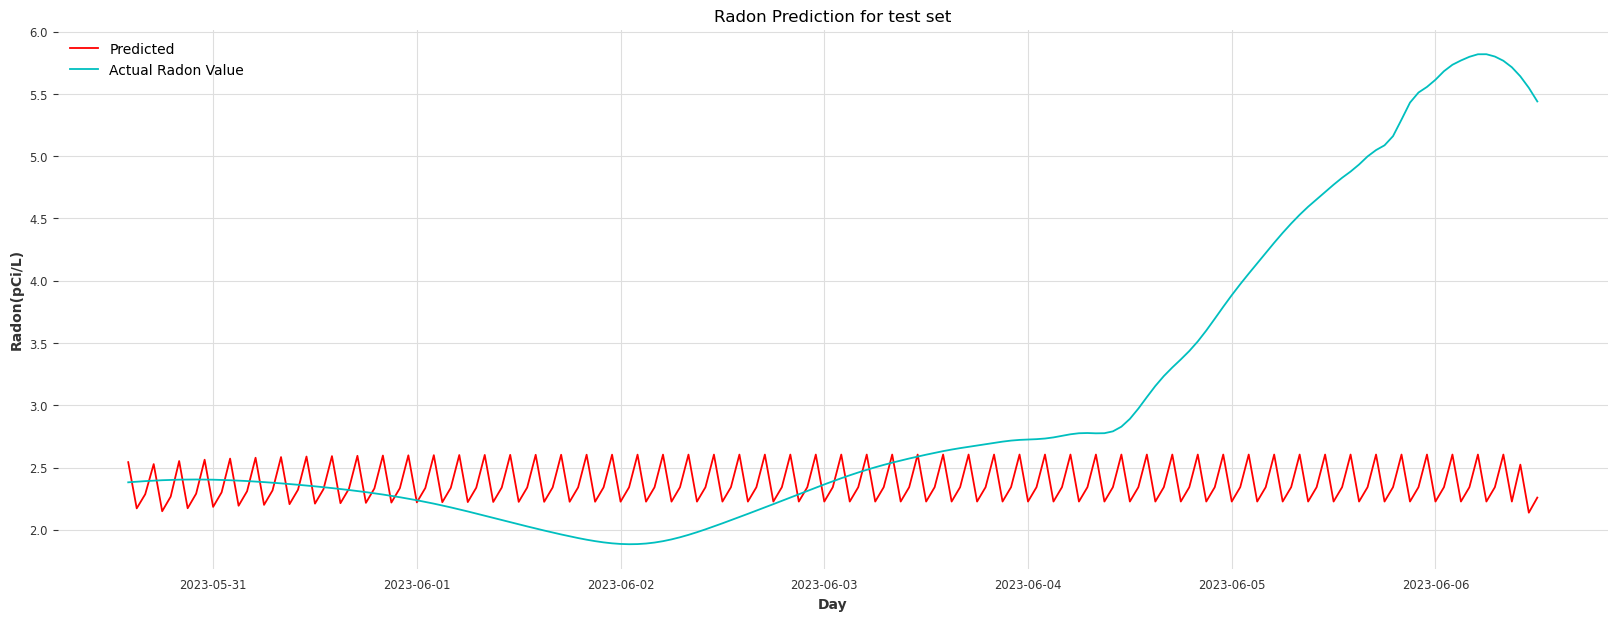

In [33]:
# plot the forecast
plt.figure(100, figsize=(20, 7))
plt.plot(dfY.index, dfY['Predicted'], color='r', label='Predicted')
plt.plot(dfY.index, dfY['Actual'], color='c', label='Actual Radon Value')
plt.legend()
plt.title('Radon Prediction for test set')
plt.xlabel('Day')
plt.ylabel('Radon(pCi/L)')
plt.show()